# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [329]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle
#import sklearn
#from sklearn.linear_model import LinearRegression
import math

plt.rcParams['figure.dpi'] = 400

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [330]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

Files containing wind data:
	['data\\wind\\produkt_zehn_min_ff_19961220_19991231_02115.txt', 'data\\wind\\produkt_zehn_min_ff_20000101_20091231_02115.txt', 'data\\wind\\produkt_zehn_min_ff_20100101_20191231_02115.txt', 'data\\wind\\produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['data\\air_temperature\\produkt_zehn_min_tu_19961219_19991231_02115.txt', 'data\\air_temperature\\produkt_zehn_min_tu_20000101_20091231_02115.txt', 'data\\air_temperature\\produkt_zehn_min_tu_20100101_20191231_02115.txt', 'data\\air_temperature\\produkt_zehn_min_tu_20200101_20221231_02115.txt']
Files containing precipitation data:
	['data\\precipitation\\produkt_zehn_min_rr_19961219_19991231_02115.txt', 'data\\precipitation\\produkt_zehn_min_rr_20000101_20091231_02115.txt', 'data\\precipitation\\produkt_zehn_min_rr_20100101_20191231_02115.txt', 'data\\precipitation\\produkt_zehn_min_rr_20200101_20221231_02115.txt']
Files containing solar data:
	['data\\solar\\produkt_z

In [331]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

wind:
       STATIONS_ID                     MESS_DATUM       QN_wind    FF_10_wind  \
count    1348857.0                        1348857  1.348857e+06  1.348857e+06   
mean        2115.0  2010-02-09 21:28:30.455297280  2.267581e+00 -3.537724e+01   
min         2115.0            1996-12-19 10:40:00  1.000000e+00 -9.990000e+02   
25%         2115.0            2003-09-13 20:10:00  1.000000e+00  4.800000e+00   
50%         2115.0            2010-02-13 02:20:00  3.000000e+00  7.400000e+00   
75%         2115.0            2016-07-12 20:40:00  3.000000e+00  1.030000e+01   
max         2115.0            2022-12-31 23:50:00  3.000000e+00  5.180000e+01   
std            0.0                            NaN  9.586172e-01  2.046541e+02   

         DD_10_wind  
count  1.348857e+06  
mean   1.529980e+02  
min   -9.990000e+02  
25%    1.200000e+02  
50%    2.100000e+02  
75%    2.800000e+02  
max    3.600000e+02  
std    2.606936e+02  
air_temperature:
       STATIONS_ID                     MESS_DATUM

In [332]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

STATIONS_ID          MESS_DATUM    QN_wind  FF_10_wind  DD_10_wind  \
0               2115 1996-12-19 10:40:00          1        15.8          70   
1               2115 1996-12-19 10:50:00          1        16.2          70   
2               2115 1996-12-19 11:00:00          1        16.6          70   
3               2115 1996-12-19 11:10:00          1        16.0          80   
4               2115 1996-12-19 11:20:00          1        16.3          70   
...              ...                 ...        ...         ...         ...   
1348936         2115 2022-12-31 23:10:00          3        13.6         230   
1348937         2115 2022-12-31 23:20:00          3        12.4         230   
1348938         2115 2022-12-31 23:30:00          3        12.6         230   
1348939         2115 2022-12-31 23:40:00          3        12.6         230   
1348940         2115 2022-12-31 23:50:00          3        12.9         230   

        eor_wind  QN_air_temperature  PP_10_air_temperature  \
0            eor                 1.0                 1008.2   
1            eor                 1.0                 1008.1   
2            eor                 1.0                 1008.1   
3            eor                 1.0                 1008.1   
4            eor                 1.0                 1008.0   
...          ...                 ...                    ...   
1348936      eor                 NaN                 1000.6   
1348937      eor                 NaN                 1000.6   
1348938      eor                 NaN                 1000.5   
1348939      eor                 NaN                 1000.6   
1348940      eor                 NaN                 1000.7   

         TT_10_air_temperature  TM5_10_air_temperature  ...  \
0                          2.0                     1.9  ...   
1                          2.0                     1.9  ...   
2                          2.1                     2.1  ...   
3                          2.3                     2.2  ...   
4                          2.1                     2.0  ...   
...                        ...                     ...  ...   
1348936                   11.1                    10.3  ...   
1348937                   10.9                    10.2  ...   
1348938                   11.1                    10.3  ...   
1348939                   11.2                    10.4  ...   
1348940                   11.2                    10.4  ...   

         RWS_IND_10_precipitation    QN_precipitation  eor_precipitation  \
0                               0                 NaN                NaN   
1                               0                 NaN                NaN   
2                               0                 NaN                NaN   
3                               0                 NaN                NaN   
4                               0                 NaN                NaN   
...                           ...                 ...                ...   
1348936                         0                 3.0                eor   
1348937                         0                 3.0                eor   
1348938                         0                 3.0                eor   
1348939                         0                 3.0                eor   
1348940                         0                 3.0                eor   

        QN_solar  DS_10_solar  GS_10_solar  SD_10_solar  LS_10_solar  \
0            1.0       -999.0       -999.0          0.0         -999   
1            1.0       -999.0       -999.0          0.0         -999   
2            1.0       -999.0       -999.0          0.0         -999   
3            1.0       -999.0       -999.0          0.0         -999   
4            1.0       -999.0       -999.0          0.0         -999   
...          ...          ...          ...          ...          ...   
1348936      NaN          0.0          0.0          0.0         -999   
1348937      NaN          0.0          0.0          0.0  

## Explorative Data Analysis

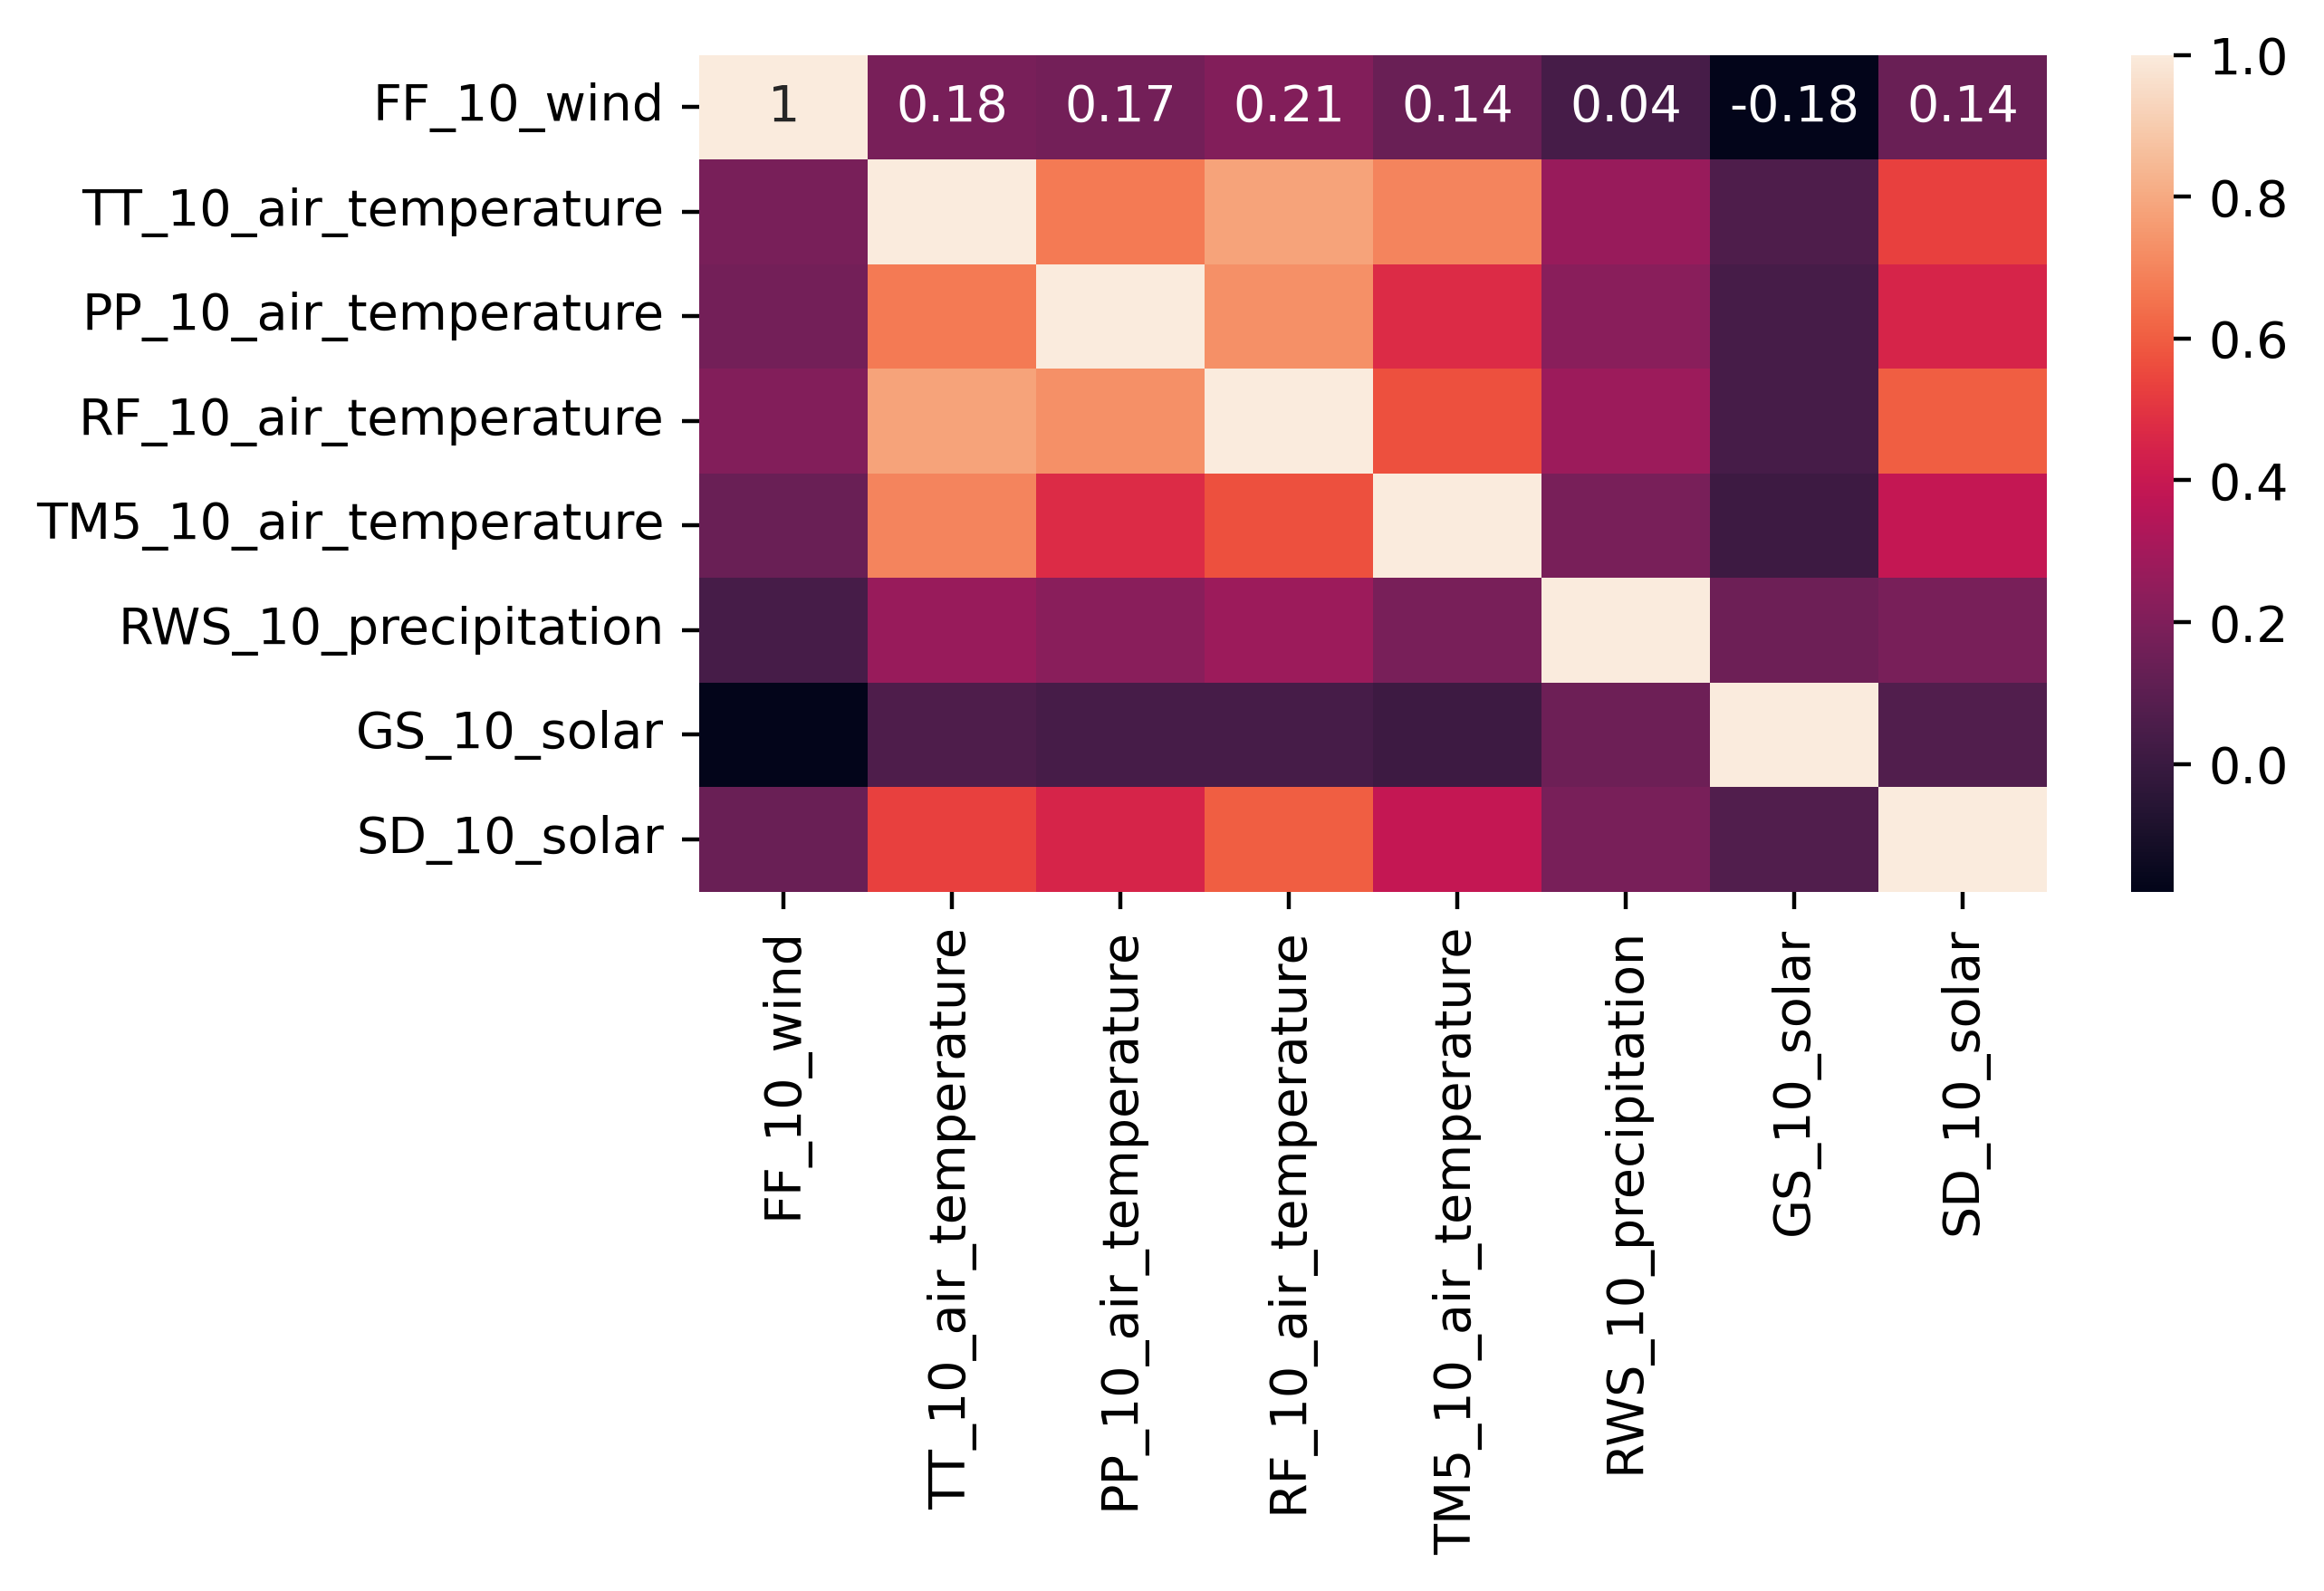

In [333]:
_ = plt.figure(figsize=(6, 3))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

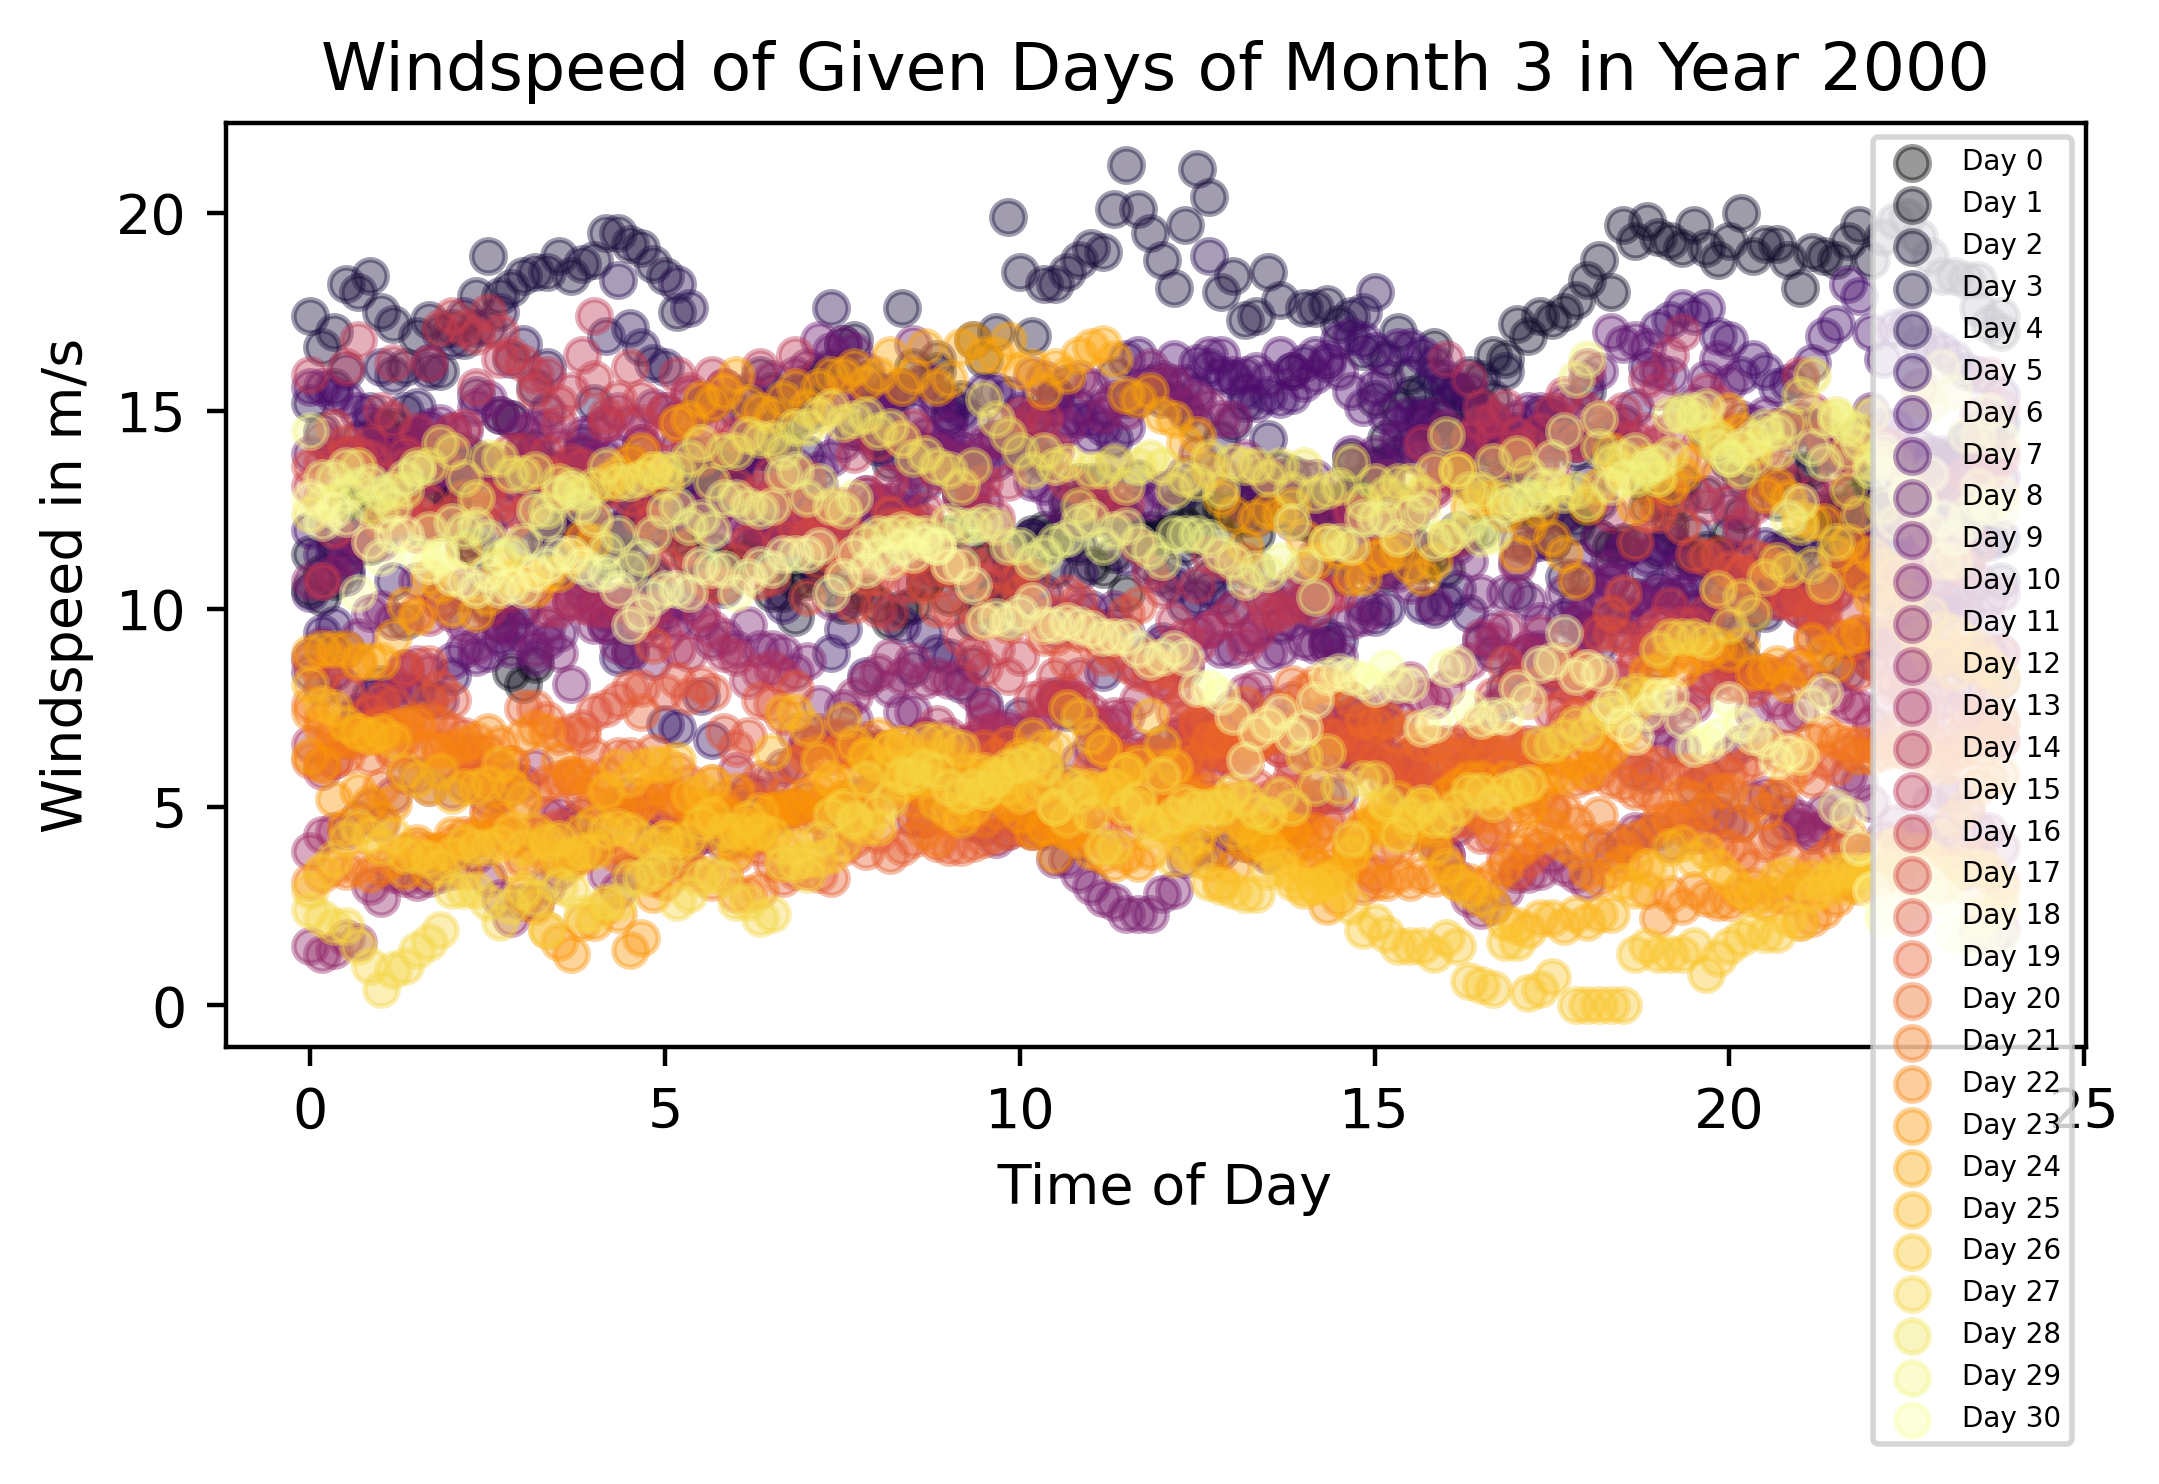

In [334]:
# Parameters for the plot shown: day, month, year
#d=1
m=3
y=2000
colors = plt.cm.inferno(np.linspace(0,1,31))
wind = kind_df["wind"]
for d in range(0,31):
    wind['FF_10_wind'] = wind['FF_10_wind'].replace(-999, float('nan'))
    mask = (wind['MESS_DATUM'].dt.day == d) & (wind['MESS_DATUM'].dt.month == m) & (wind['MESS_DATUM'].dt.year == y)
    plt.scatter( wind[mask]["MESS_DATUM"].dt.hour + (wind[mask]["MESS_DATUM"].dt.minute)*1/60, wind[mask]["FF_10_wind"] , color=colors[d], alpha=0.4, label=f'Day {d}')
# wind[mask]["MESS_DATUM"].dt.hour + (wind[mask]["MESS_DATUM"].dt.minute)*1/60 make this better...
plt.ylabel("Windspeed in m/s")
plt.xlabel(" Time of Day")
plt.title(f'Windspeed of Given Days of Month {m} in Year {y}')
plt.legend(loc='best', fontsize='5')
plt.show()

# Plot the empirical frequency of each windspeed  for each year: 


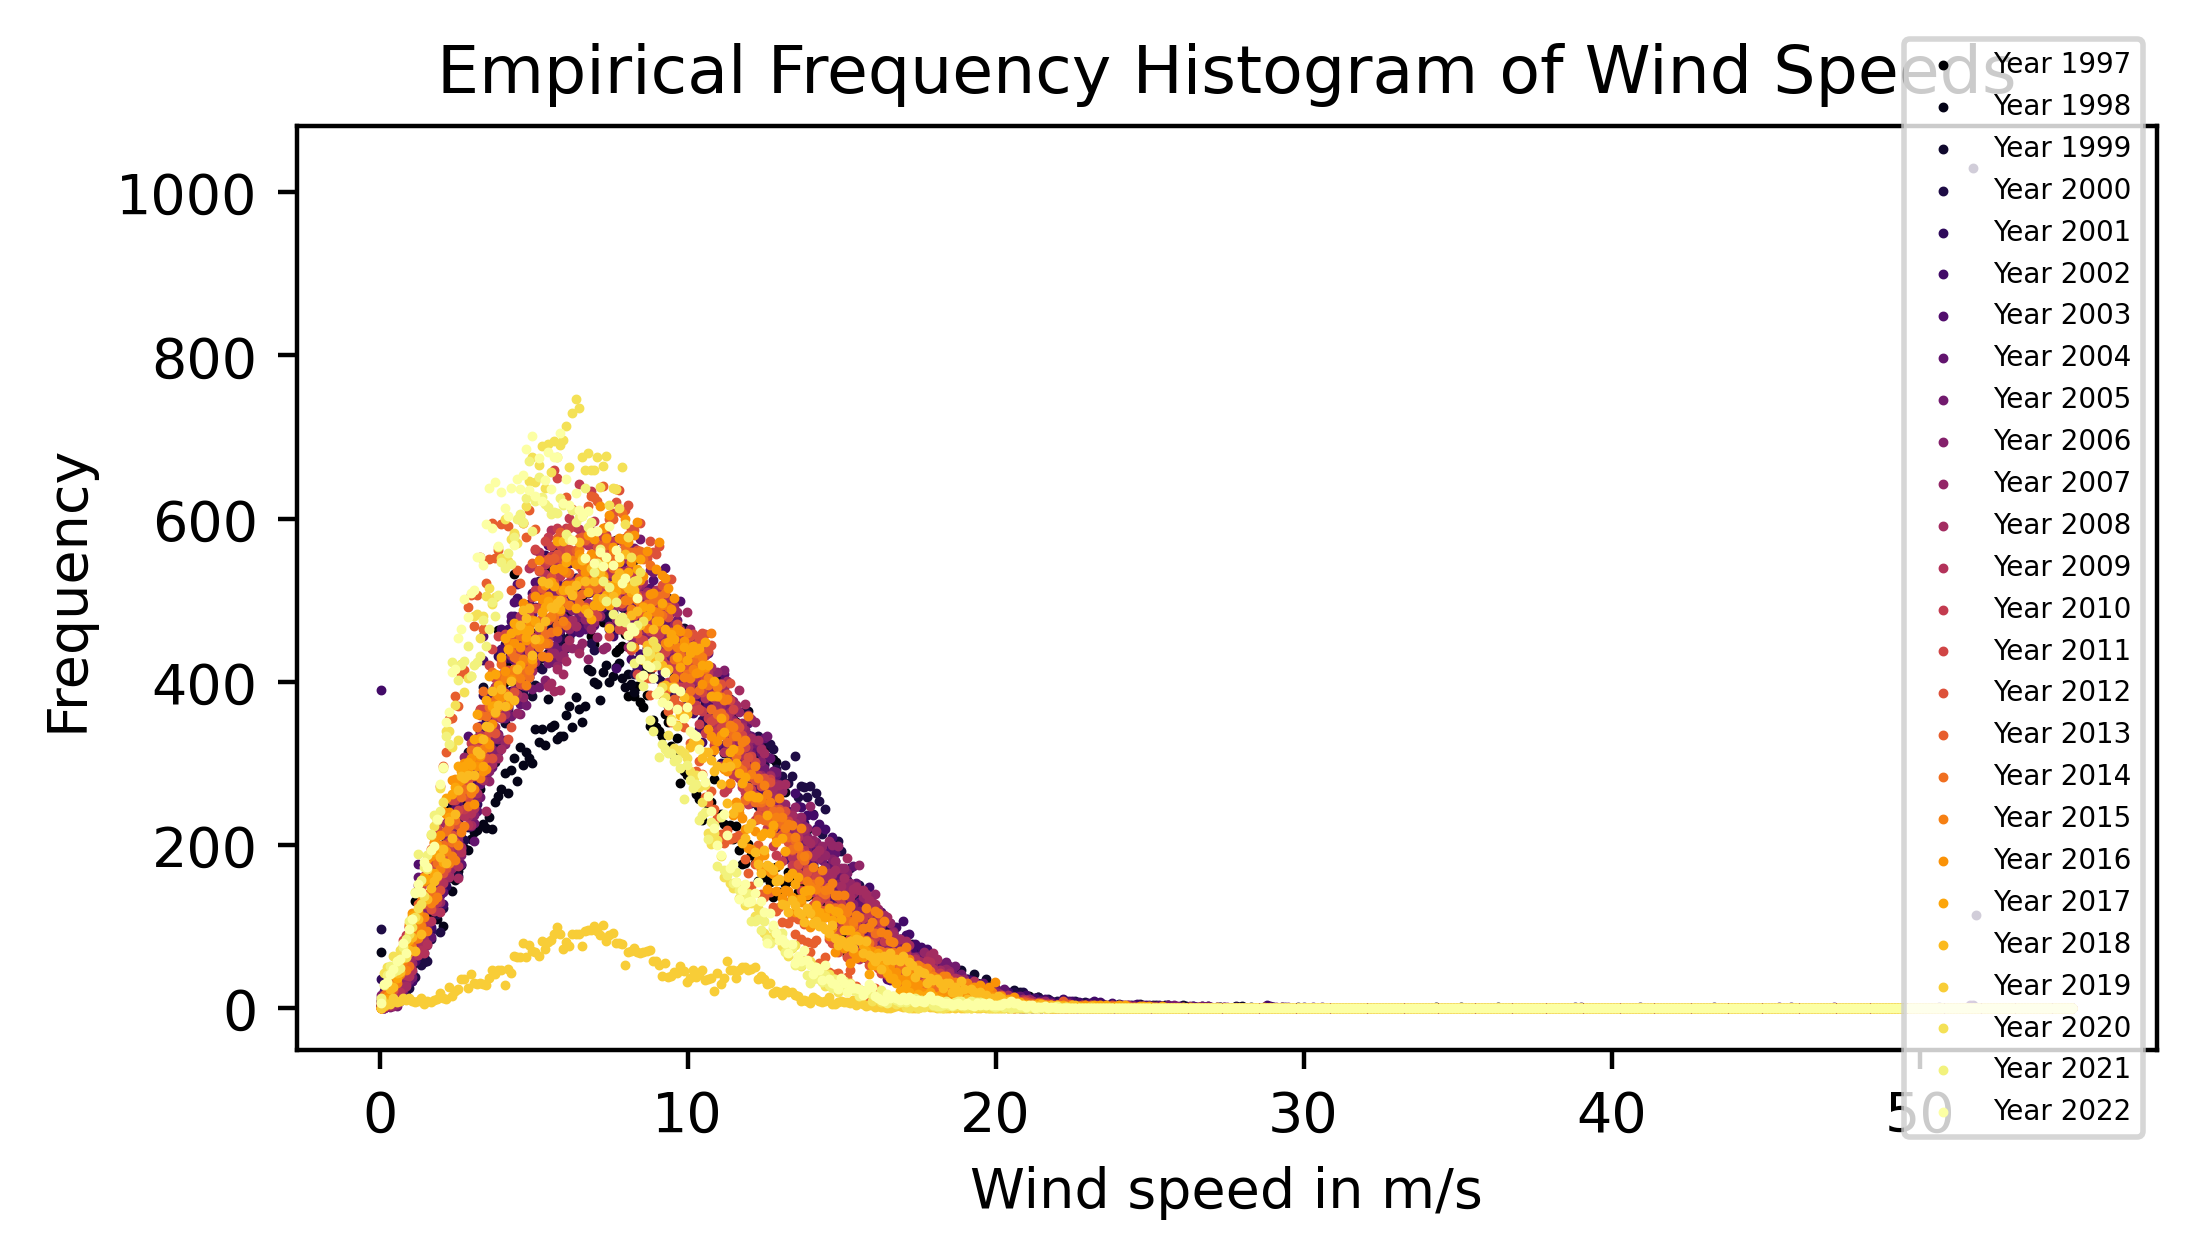

In [335]:

# Specify bin edges with specific width, start, and end
bin_edges = np.linspace(0, 55, 550) 
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2


year_colors = plt.cm.inferno(np.linspace(0,1,26))
for y in range(1997, 2023):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"], bins=bin_edges)[0]
    # Create a plot using midpoints and frequencies
    plt.scatter(bin_midpoints, hist_values, color= year_colors[y-1997], label=f'Year {y}', alpha=1, s=0.6) 

plt.title('Empirical Frequency Histogram of Wind Speeds')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='right', fontsize='5')
plt.show()




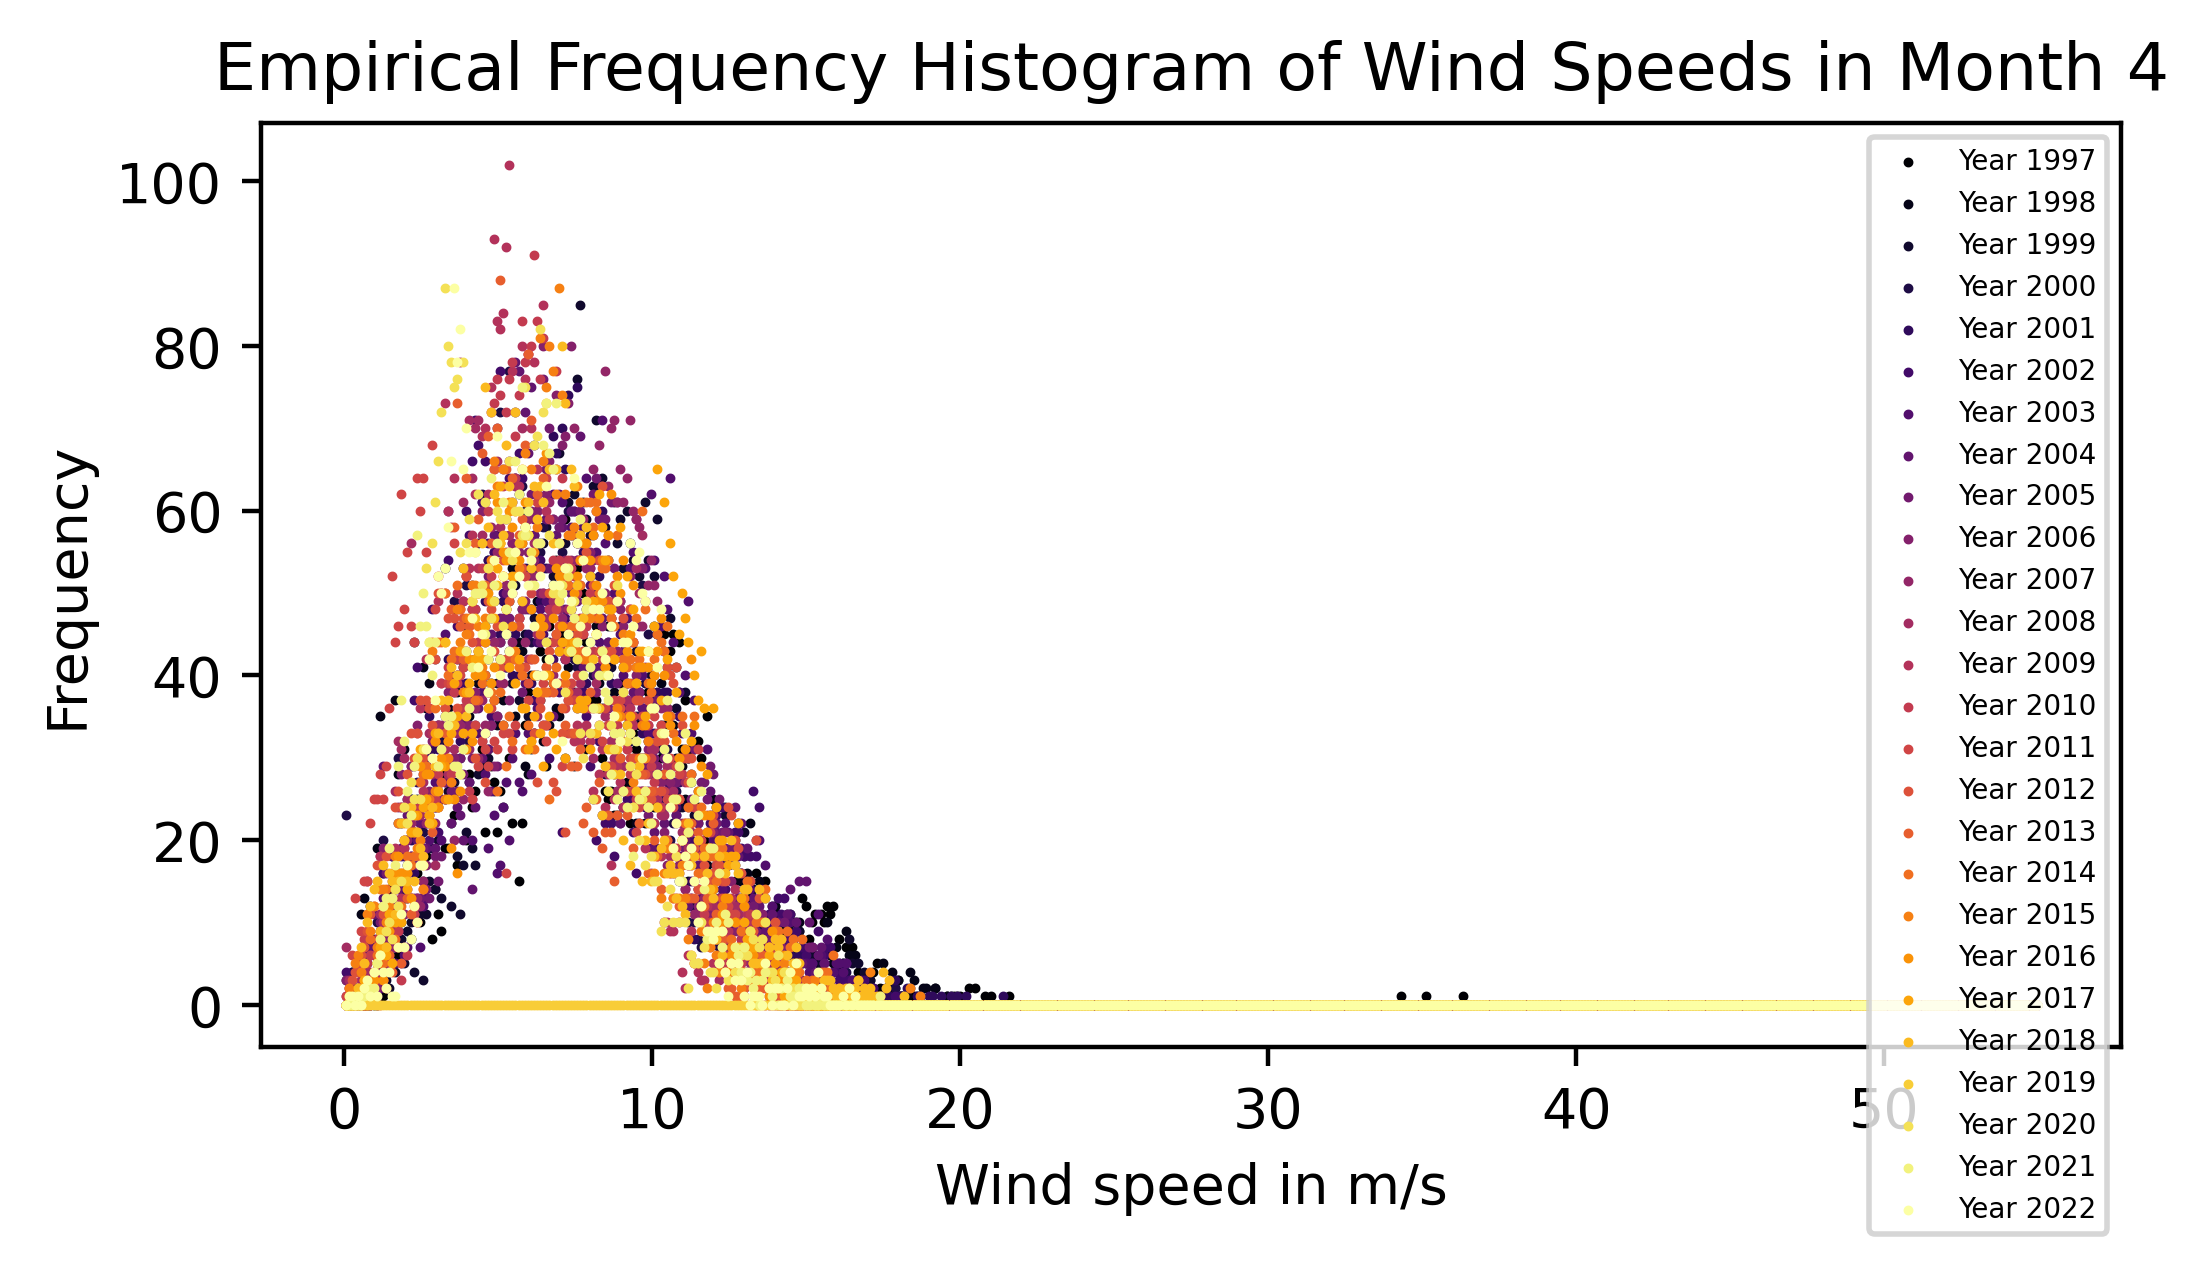

In [336]:
# plot the empirical frequency for a given month for each year: 
month=4
for y in range(1997, 2023):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == y) & (df['MESS_DATUM'].dt.month == month) ]["FF_10_wind"], bins=bin_edges)[0]
    # Create a scatter plot using midpoints and frequencies
    plt.scatter(bin_midpoints, hist_values, color= year_colors[y-1997], label=f'Year {y}', alpha=1, s=0.6 )

plt.title(f'Empirical Frequency Histogram of Wind Speeds in Month {month}')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='best', fontsize='5')
plt.show()



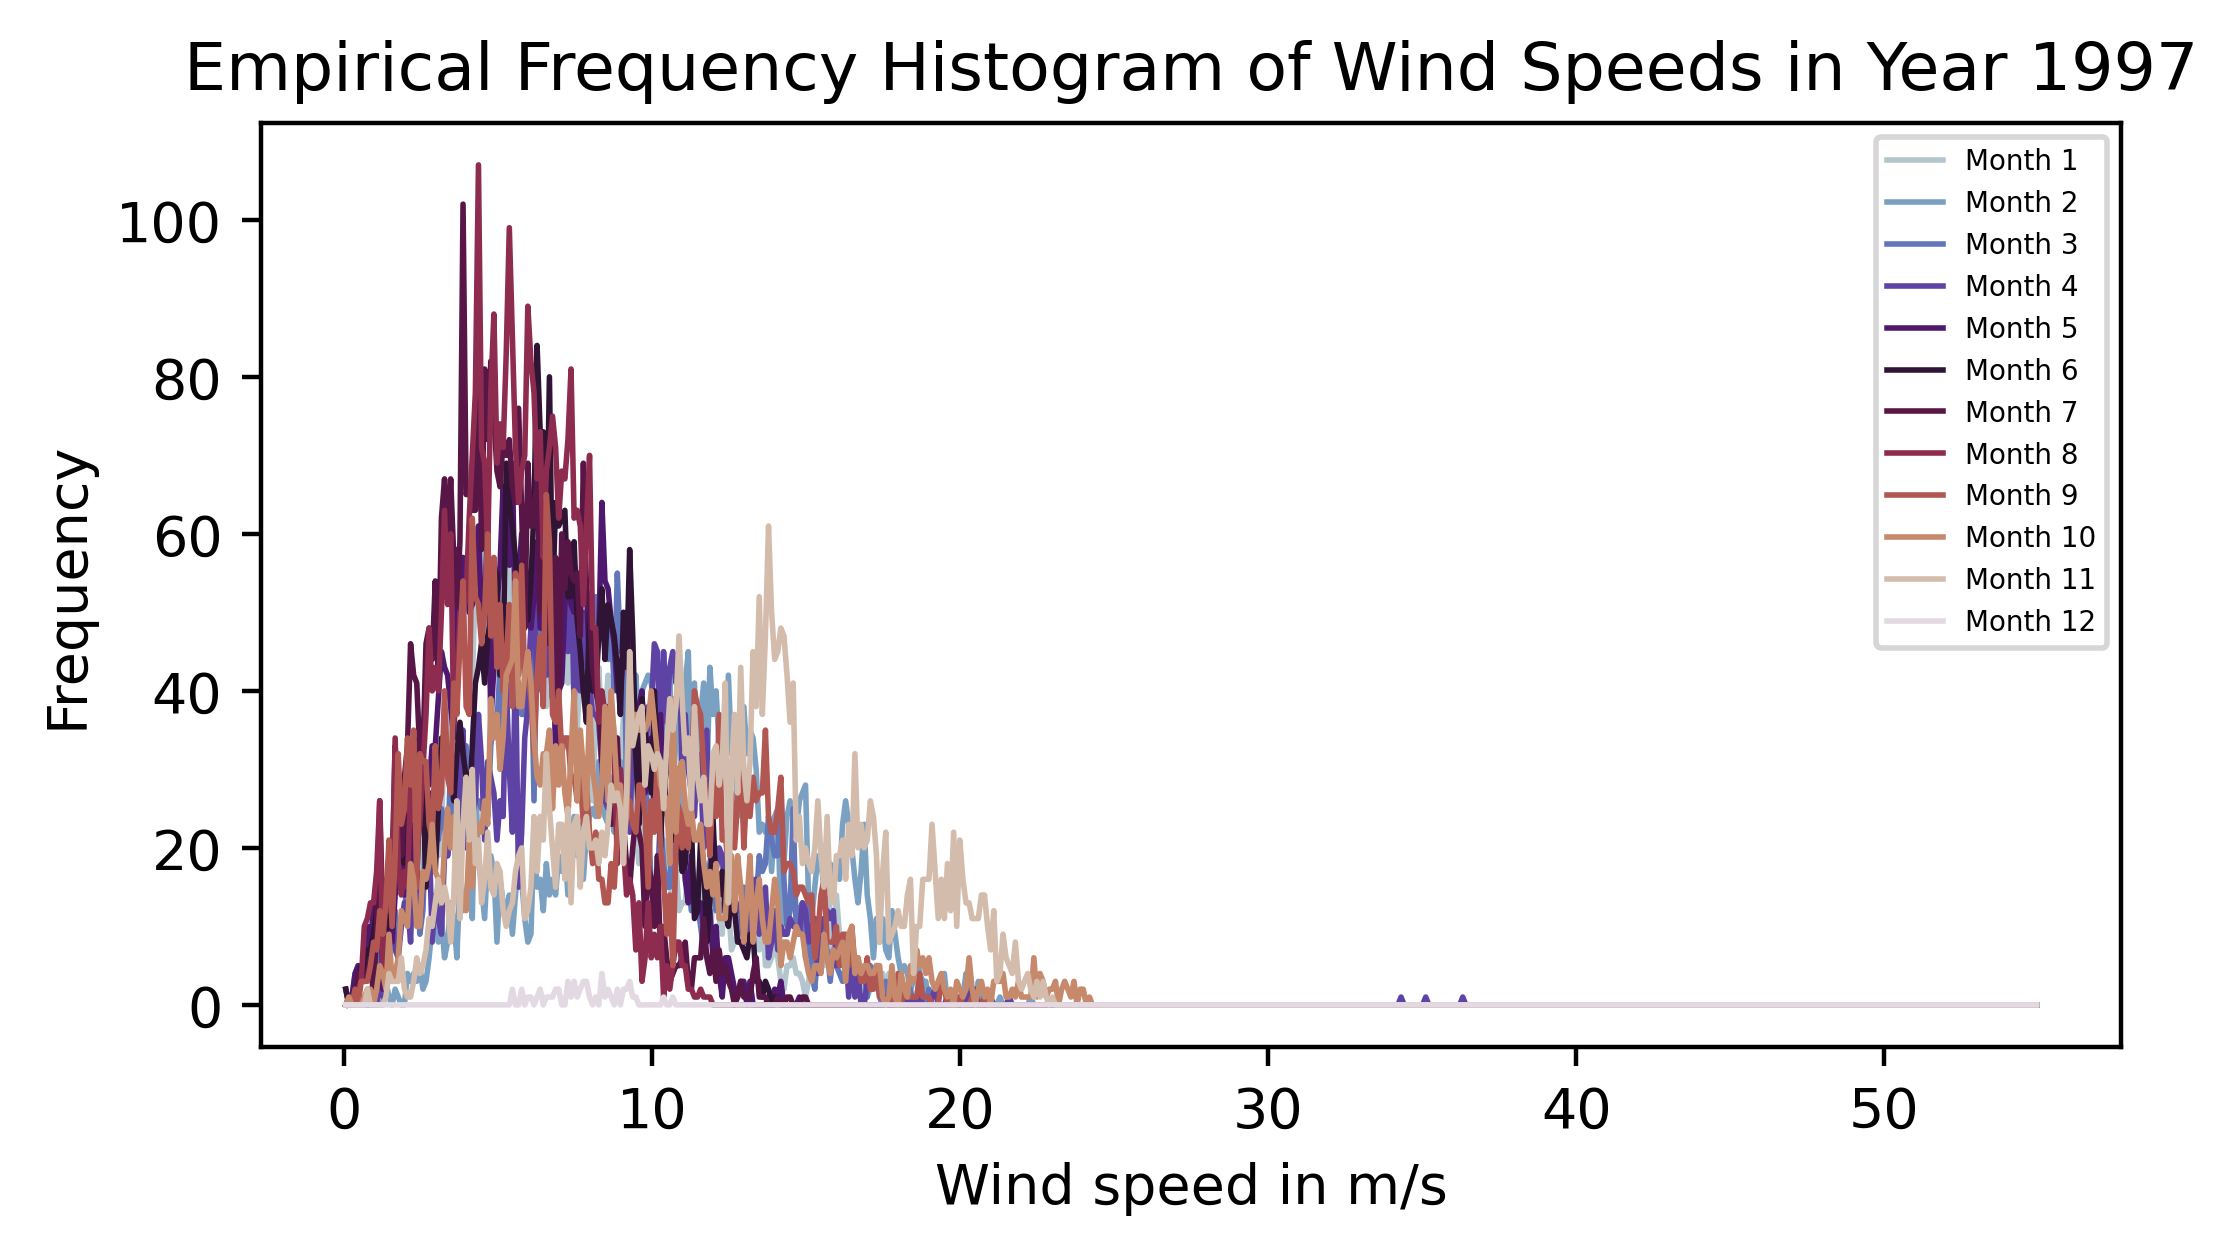

In [337]:
# plot the empirical frequency for a given year for each month: 

month_colors = plt.cm.twilight(np.linspace(0,1,13))
year=1997
for m in range(1, 13):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == year) & (df['MESS_DATUM'].dt.month == m ) ]["FF_10_wind"], bins=bin_edges)[0]
    # Create a scatter plot using midpoints and frequencies
    plt.plot(bin_midpoints, hist_values, color= month_colors[m], label=f'Month {m}', alpha=1, lw=1 )

plt.title(f'Empirical Frequency Histogram of Wind Speeds in Year {year}')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='best', fontsize='5')
plt.show()

## We find the parameters of the Weibull distribution that best fits our empirical data
 Unfortunately, on the monthly basis this is not a good fit...

3


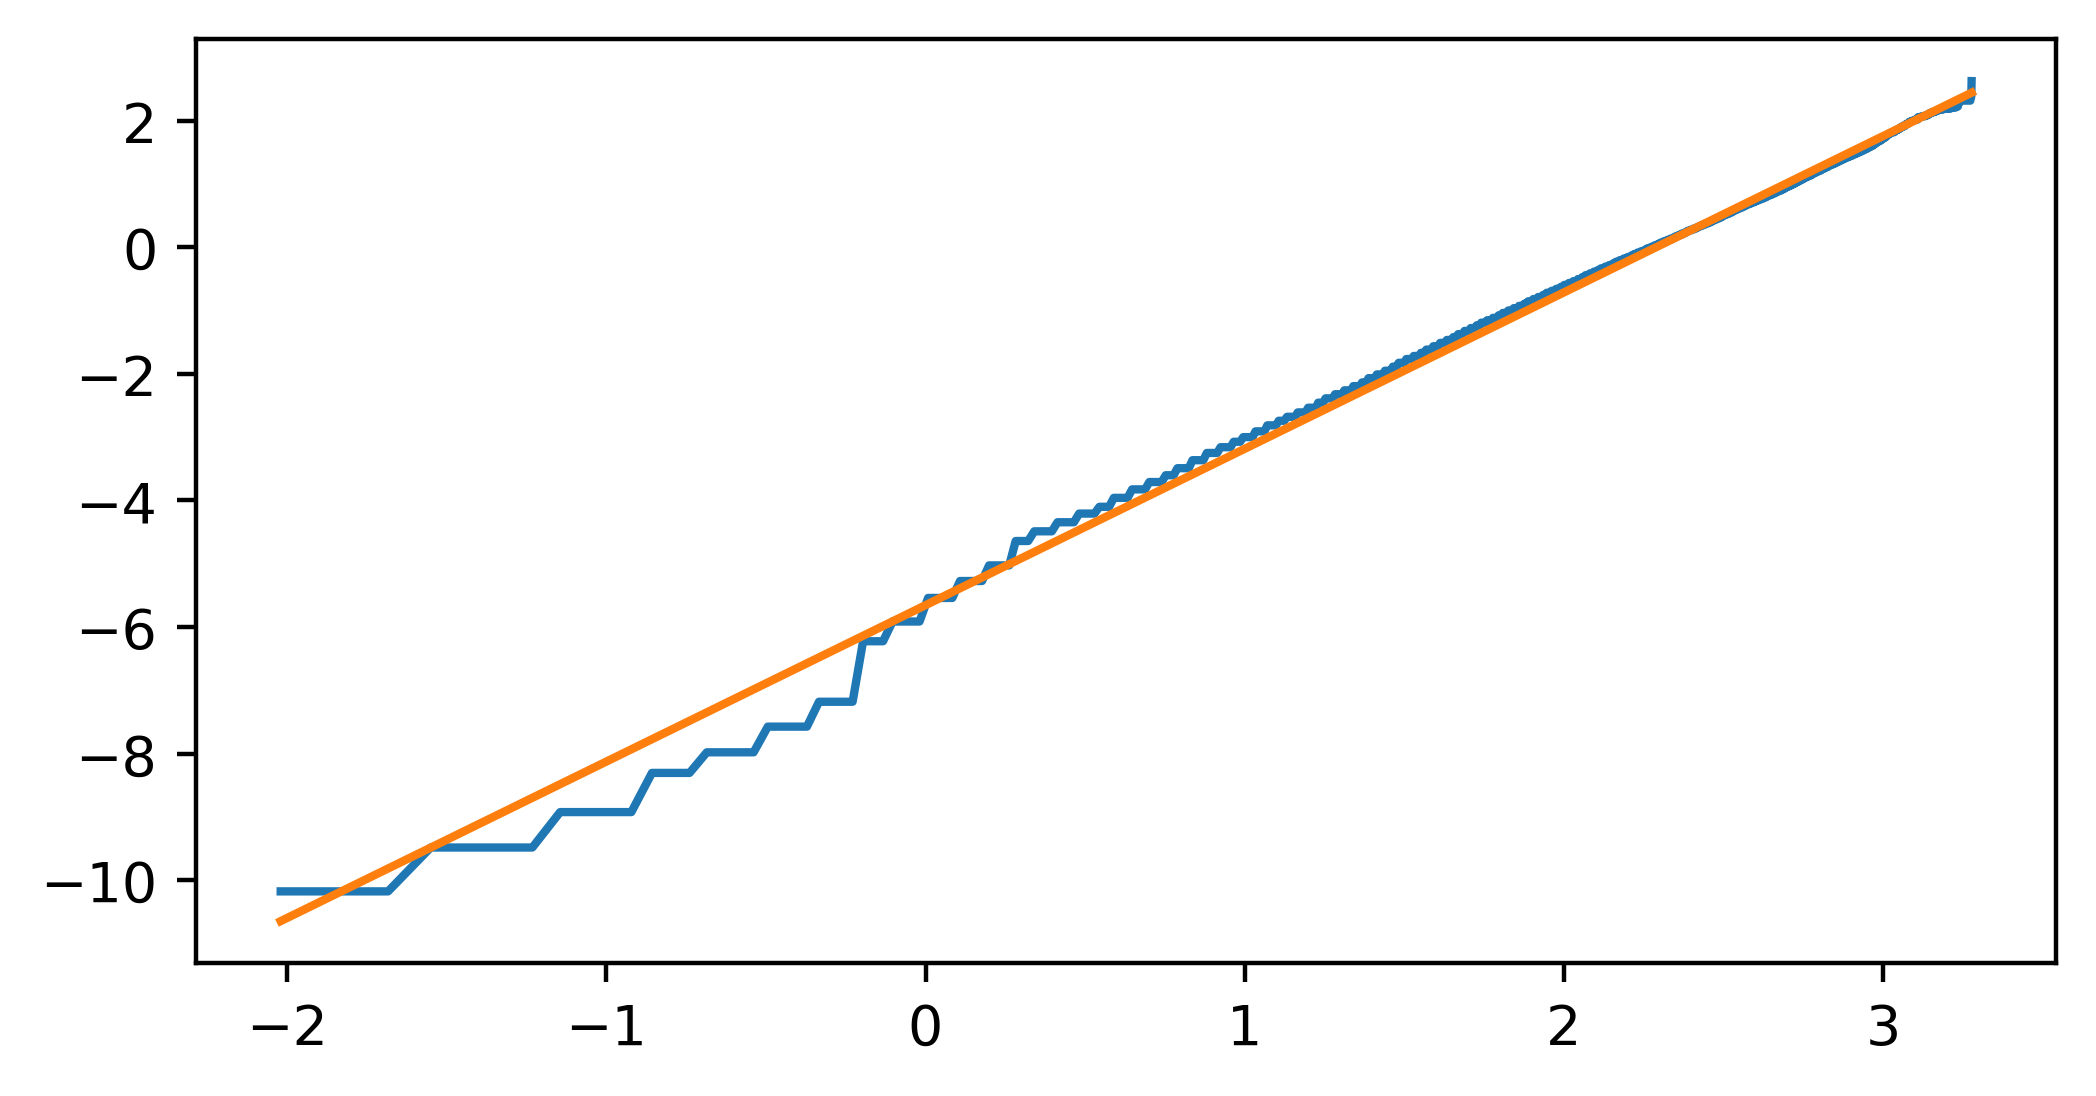

our parameters are k=2.471027020853187 and a=9.860845797621252


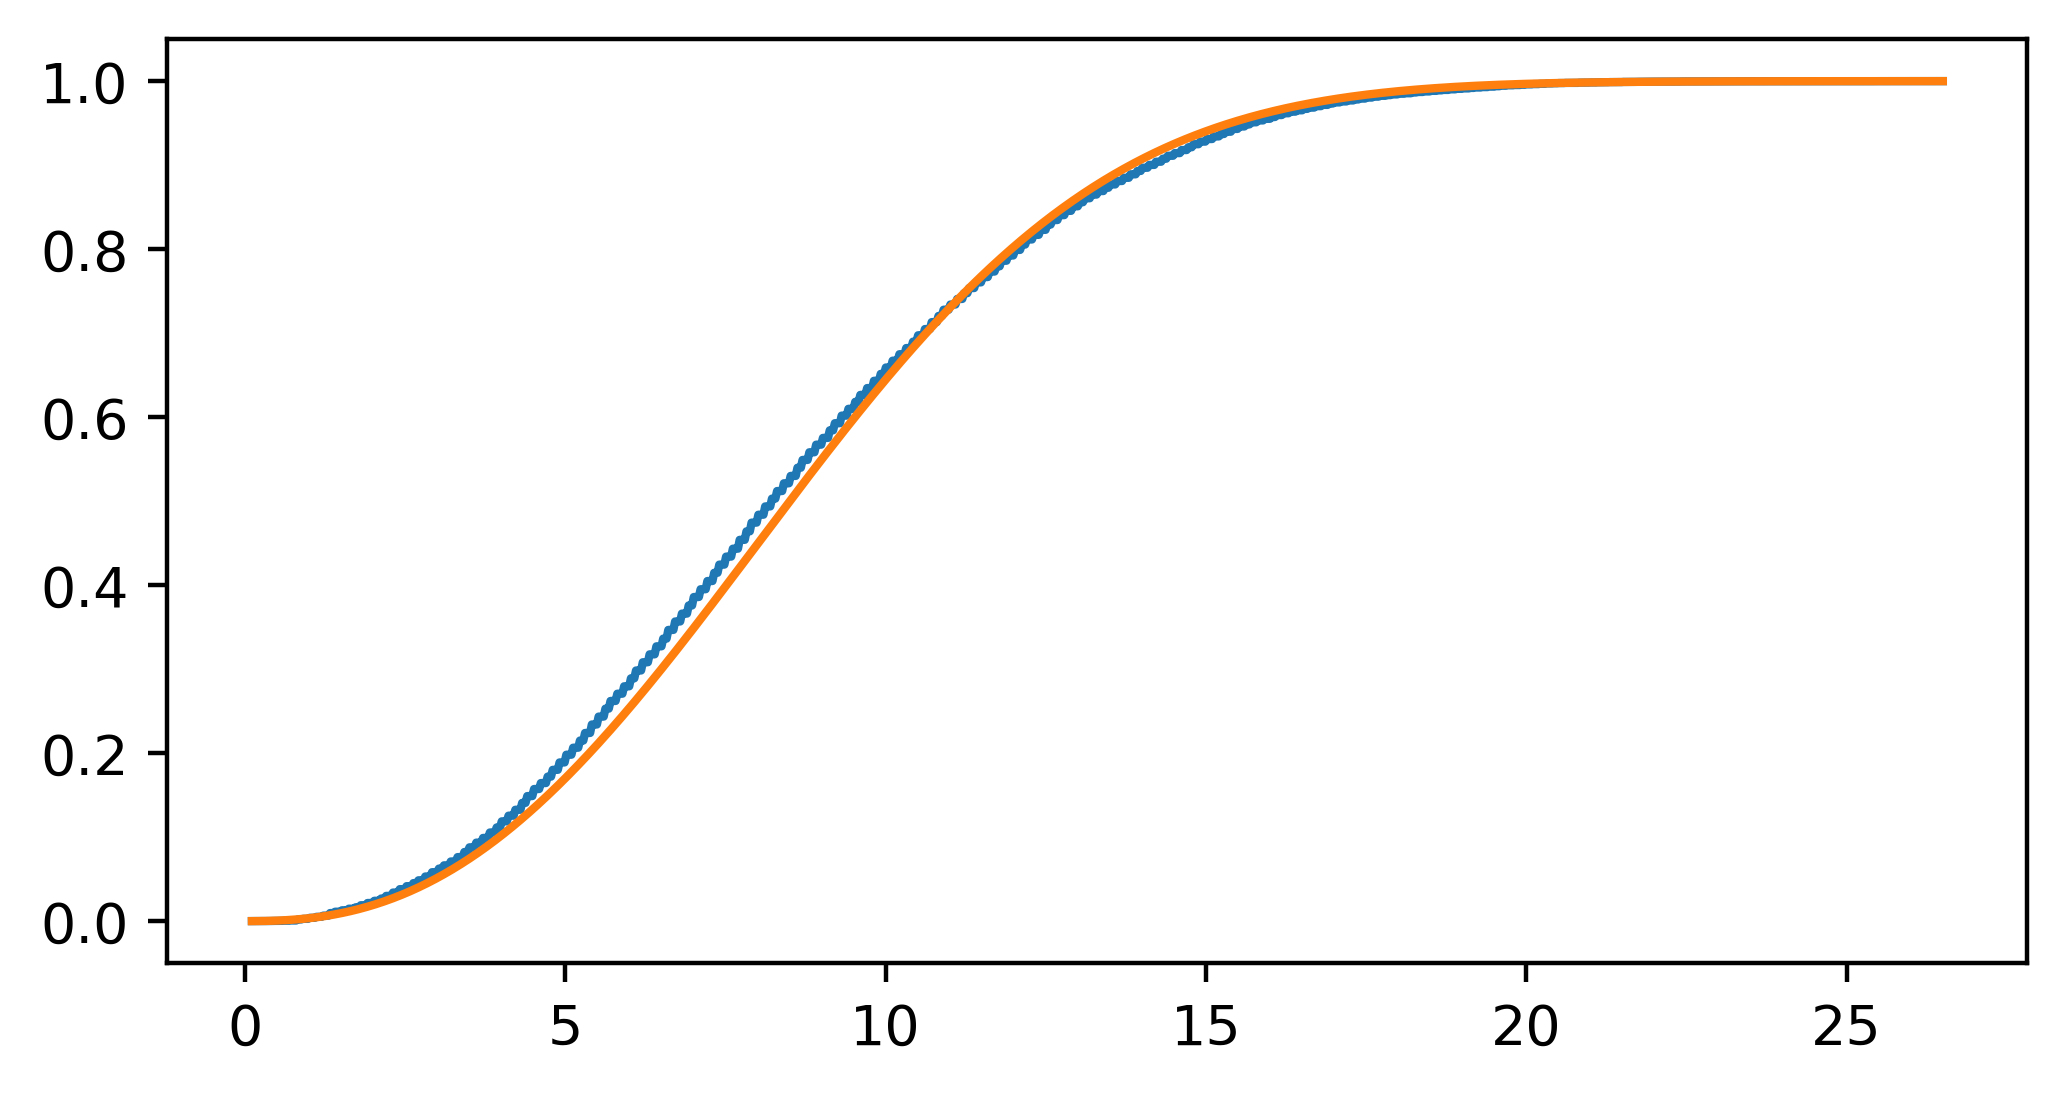

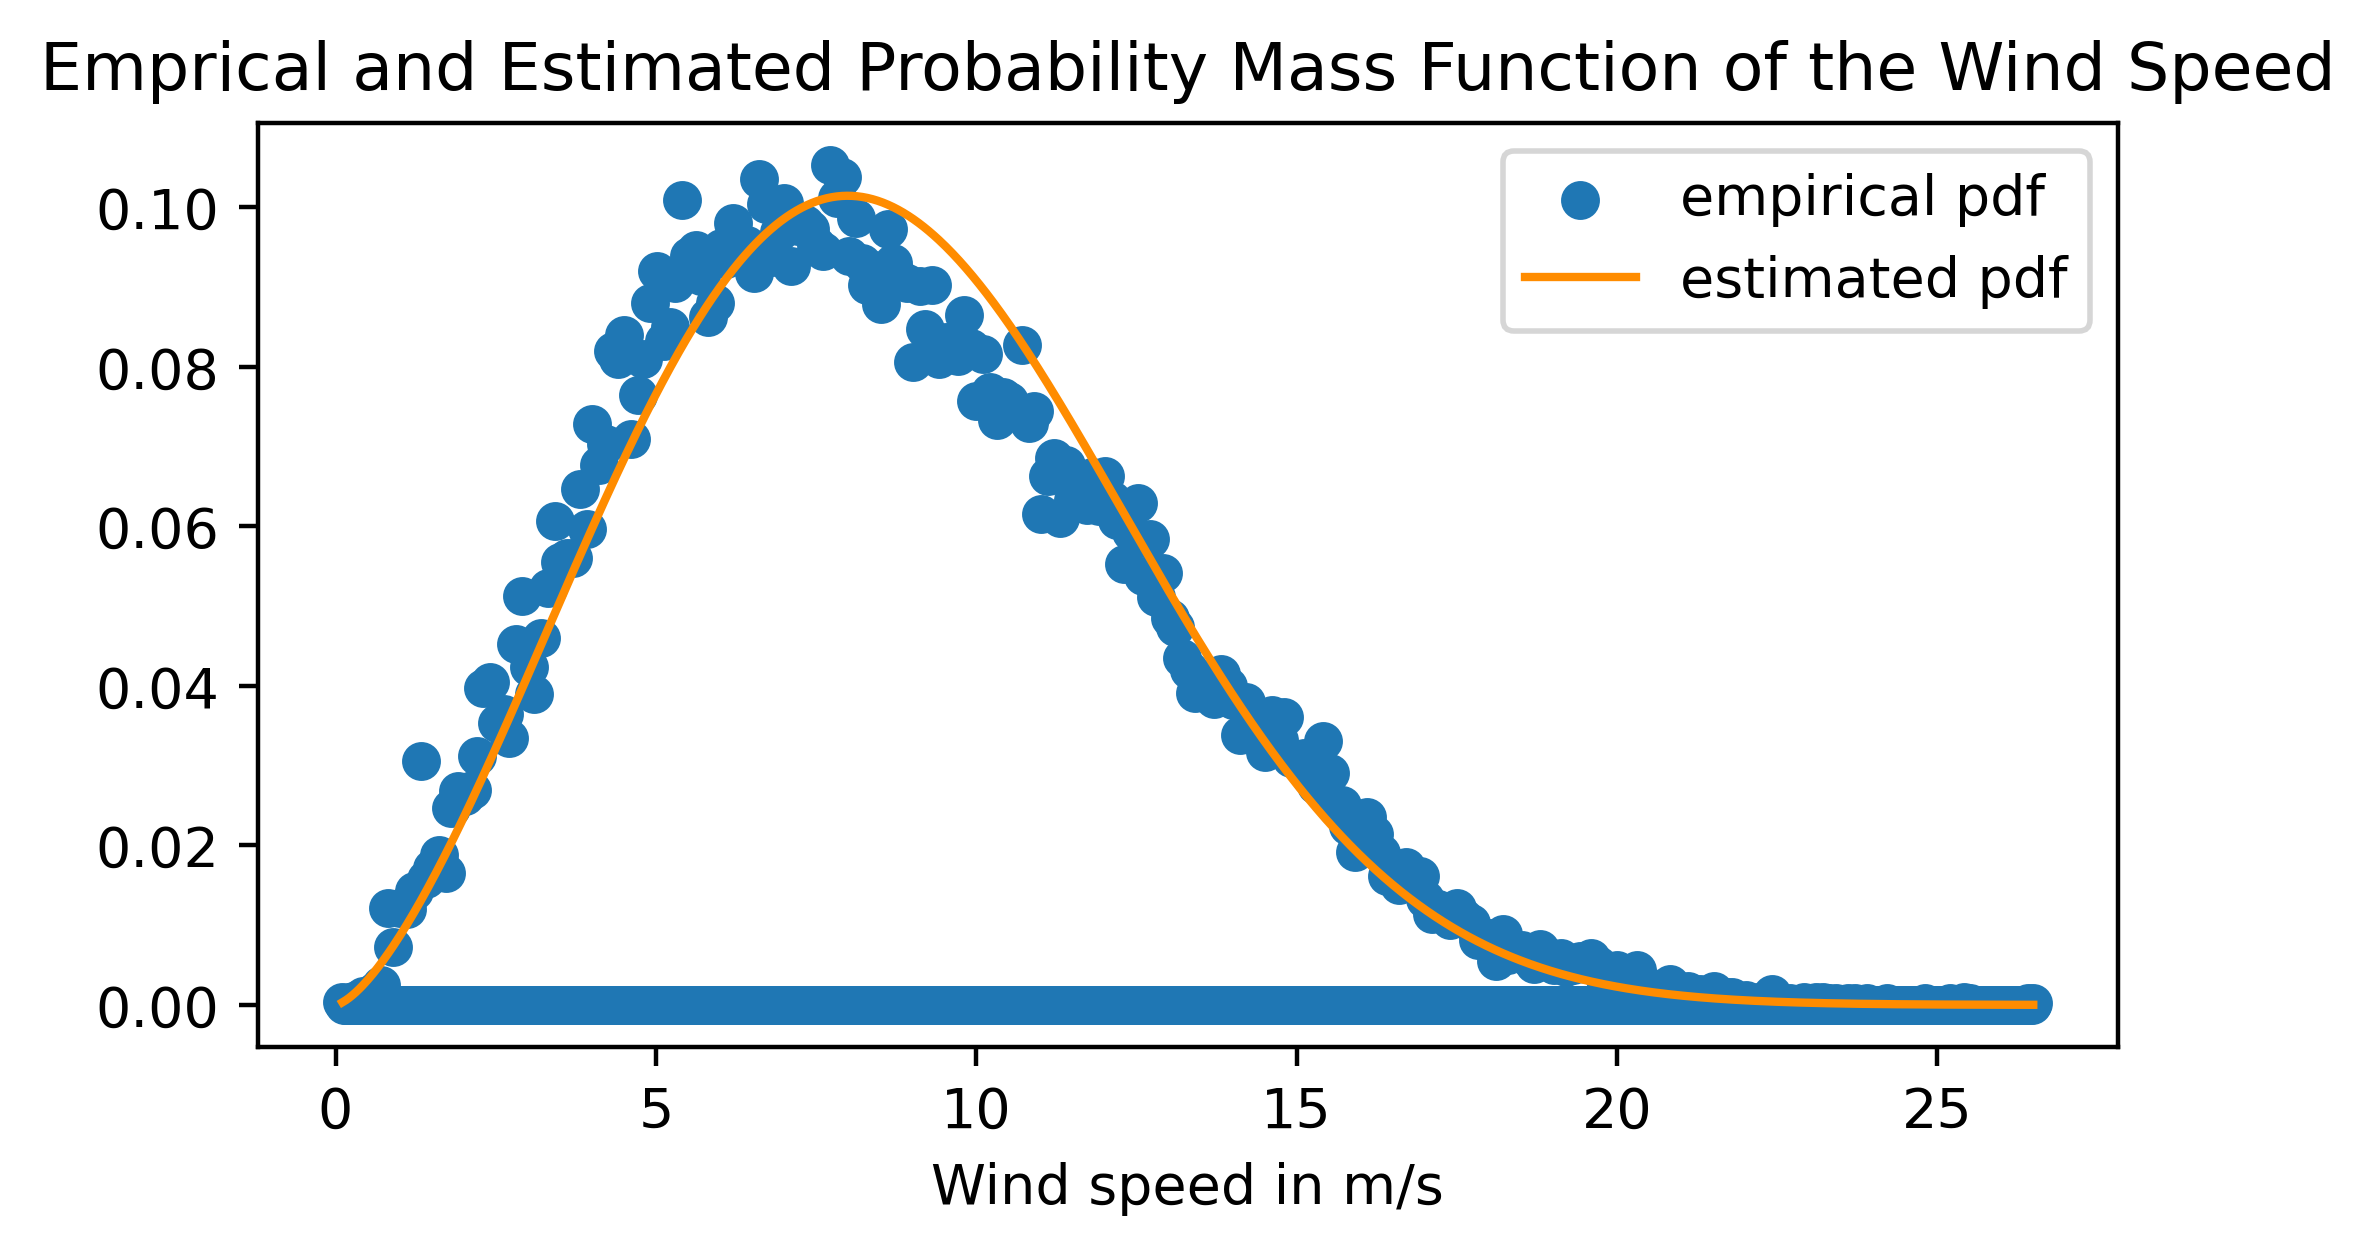

In [371]:
# Define the weibull-pdf and cdf 
def weibull_pdf( k,a,x):
    return (k/a*(x/a)**(k-1) )* np.exp( - (x/ a )**k)

def weibull_cdf( k, a,x):
    return 1-np.exp(-(x/a)**k)


# Find the parameters of the Weibull-Distribution for one year
max_included_windspeed=df[(df['MESS_DATUM'].dt.year == 2004)]["FF_10_wind"].max()
min_included_windspeed=df[(df['MESS_DATUM'].dt.year == 2004)]["FF_10_wind"].min()

number_of_bins=1000
edges=np.linspace(0,max_included_windspeed, number_of_bins)
#Start by computing the empirical CDF:
empiric_pdf= np.histogram(df[(df['MESS_DATUM'].dt.year == 2004)]["FF_10_wind"], bins=edges)[0]

CDF=np.array([empiric_pdf[0]])
for i in range(1, len(empiric_pdf)):
    CDF=np.append(CDF, CDF[i-1]+empiric_pdf[i] )

# disregard the first d  bins?
#d=int(min_included_windspeed*number_of_bins/max_included_windspeed)
d=0
for i in range(0, len(CDF)):
    d=i
    if CDF[i] >0.1:
        break

print(d)
edges=edges[d:]
empiric_pdf=empiric_pdf[d:]
CDF=CDF[d:]

#normalize the CDF and the PDF
empiric_pdf=(empiric_pdf/CDF[len(CDF)-1])*10 # I CANNOT EXPLAIN THIS FACTOR 
CDF=CDF/CDF[len(CDF)-1]

#modify the CDF in order to find the Weibull parameters
mod_CDF= np.log(-np.log(1-CDF[1:] +0.000001) +0.000001) # HOW TO RESOLVE THIS PROPERLY?
log_edges=np.log(edges[2:])

# now do linear regression

linpol=np.polyfit(log_edges, mod_CDF, 1)
mod_CDF_model = np.poly1d(linpol)
#Plot the linear regression:

plt.plot( log_edges, mod_CDF)
plt.plot(log_edges, mod_CDF_model(log_edges))
plt.show()

# the Weibull-parameters are
k1=linpol[0]
a1=np.exp( - linpol[1]/linpol[0])
print(f'our parameters are k={k1} and a={a1}')


# plot the empiric pdf and the estimated pdf

plt.plot(edges[1:], CDF)
plt.plot(edges[1:], weibull_cdf(k1,a1, edges[1:]))
plt.show()

plt.scatter( edges[1:], empiric_pdf, label='empirical pdf')
plt.plot( edges[1:], weibull_pdf( k1,a1,edges[1:]), color='darkorange', label='estimated pdf')
plt.legend()
plt.title('Emprical and Estimated Probability Mass Function of the Wind Speed')
plt.xlabel('Wind speed in m/s')
plt.show()


In [339]:
# Define what we did before as a proper function that can be called:
def get_weibull_parameters( dataframe):
    max_included_windspeed=int(dataframe.max()+1)
    number_of_bins=int(dataframe.max()*200)
    edges=np.linspace(0,max_included_windspeed, number_of_bins)
    #Start by computing the empirical CDF:
    empiric_pdf= np.histogram(dataframe, bins=edges)[0]
    CDF=np.array([empiric_pdf[0]])
    for i in range(1, len(empiric_pdf)):
        CDF=np.append(CDF, CDF[i-1]+empiric_pdf[i] )

    # disregard the first d  bins? -> This makes sure we have no near-constant part in the beginning
    d=0
    for i in range(0, len(CDF)):
        d=i
        if CDF[i] >0.1:
            break

    edges=edges[d:]
    empiric_pdf=empiric_pdf[d:]
    CDF=CDF[d:]

    #normalize the CDF and the PDF
    empiric_pdf=(empiric_pdf/CDF[len(CDF)-1])*10 # I CANNOT EXPLAIN THIS FACTOR 
    CDF=CDF/CDF[len(CDF)-1]

    #modify the CDF in order to find the Weibull parameters
    mod_CDF= np.log(-np.log(1-CDF[1:] +0.000001) +0.000001) # HOW TO RESOLVE THIS PROPERLY?
    log_edges=np.log(edges[2:])

    # now do linear regression
    linpol=np.polyfit(log_edges, mod_CDF, 1)
    mod_CDF_model = np.poly1d(linpol)
    k=linpol[0]
    a=np.exp( - linpol[1]/linpol[0])
    return [k,a]

# Test wether it's correct:
print(get_weibull_parameters(df[(df['MESS_DATUM'].dt.year == 2011)]["FF_10_wind"]))


[2.2925271016425164, 8.7779814505759]


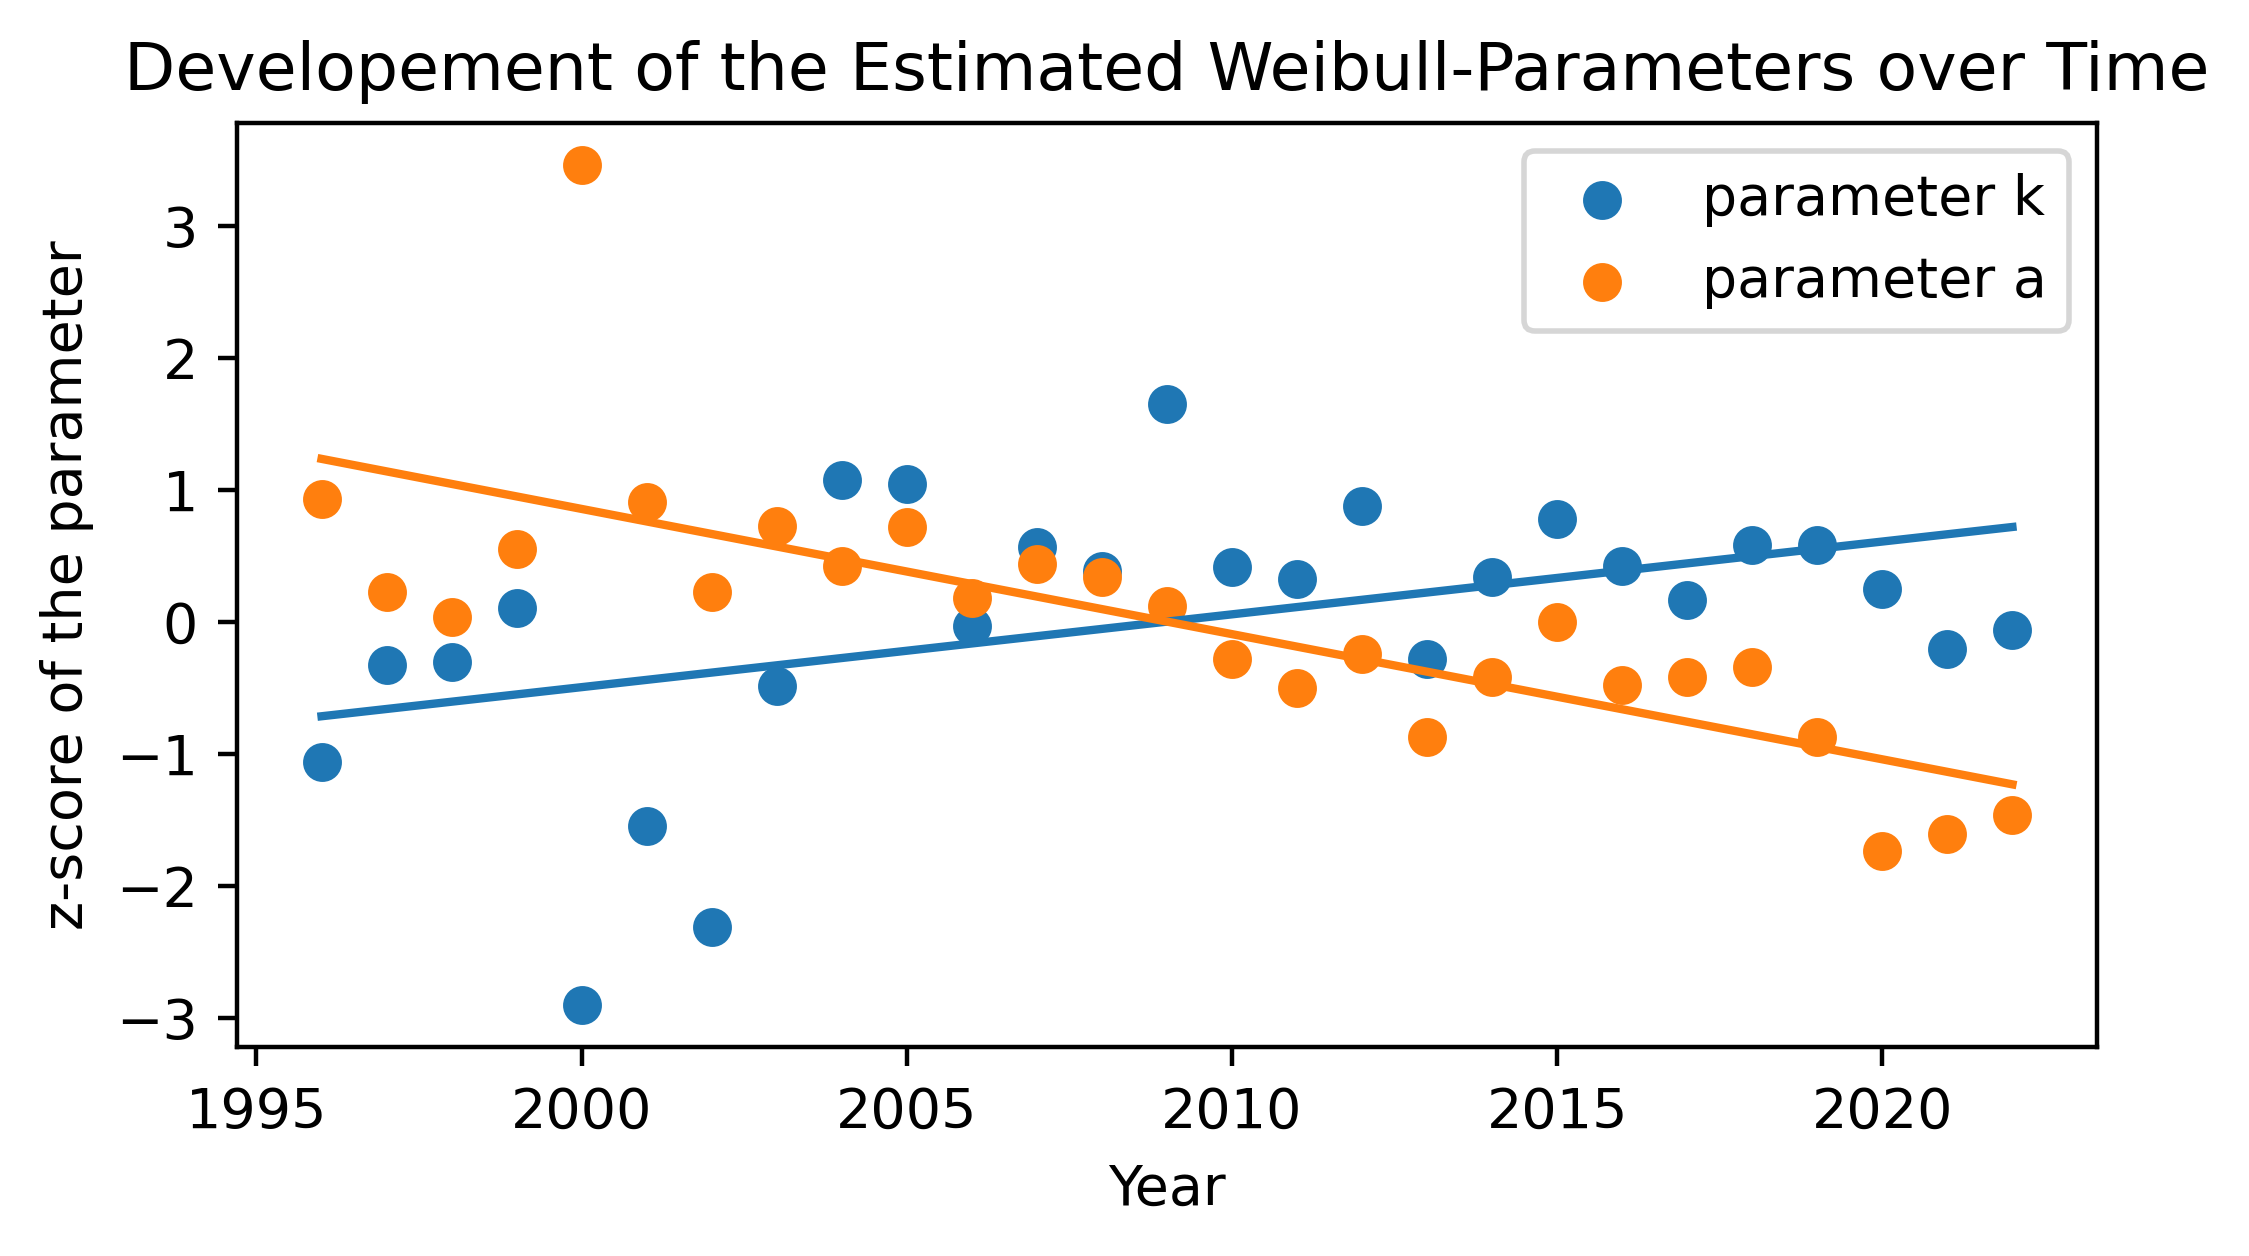

In [360]:
# plot the development of the parameters over the years: 

# add the parameters into a dataframe
yearly_df=pd.DataFrame()
year_arr=np.linspace(1996, 2022,27)
yearly_df['YEAR']=year_arr

yearly_df['parameter_k']=0.0
yearly_df['parameter_a']=0.0

for y in year_arr:
    yearly_df.loc[y-1996, 'parameter_k' ], yearly_df.loc[y-1996, 'parameter_a' ]=get_weibull_parameters(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])

# find the corresponding z-scores
yearly_df['z_parameter_k']=(yearly_df['parameter_k']-yearly_df['parameter_k'].mean())/yearly_df['parameter_k'].std()

yearly_df['z_parameter_a']=(yearly_df['parameter_a']-yearly_df['parameter_a'].mean())/yearly_df['parameter_a'].std()

# plot the z-scores of the parameters and do linear regression: 
plt.scatter(year_arr, yearly_df['z_parameter_k'], label='parameter k')
plt.scatter(year_arr, yearly_df['z_parameter_a'], label='parameter a')

k_pol=np.polyfit(year_arr, yearly_df['z_parameter_k'], 1)
k_model = np.poly1d(k_pol)
plt.plot(year_arr,k_model(year_arr))

a_pol=np.polyfit(year_arr, yearly_df['z_parameter_a'], 1)
a_model = np.poly1d(a_pol)
plt.plot(year_arr,a_model(year_arr))
plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('z-score of the parameter')
plt.legend()
plt.show()

## Now classify each data point in df according to the Beaufort Scale:


In [341]:
def bf_classifier(data):
    if data >24.5:
        return 10
    elif data >20.8:
        return 9
    elif data >17.2:
        return 8
    elif data >13.9:
        return 7
    elif data >10.8:
        return 6
    elif data >8.0:
        return 5
    elif data >5.5:
        return 4
    elif data >3.4:
        return 3
    elif data >1.6:
        return 2
    elif data >0.3:
        return 1
    else:
        return 0
    
# Vectorize the scalar function to make it work on arrays
bf_classifier_vectorized = np.vectorize(bf_classifier)

# Add a new column to our dataframe that displays the beaufort classification of each wind measurement:
df['bf_classification']=bf_classifier_vectorized(df["FF_10_wind"])
#df



In [342]:
# Make a new dataframe with one frame for each day, that has min max and mean speed of the day as feature
from datetime import datetime
df['YEAR'] = df["MESS_DATUM"].dt.year
df['MONTH'] = df["MESS_DATUM"].dt.month
df['DAY'] = df["MESS_DATUM"].dt.day

daily_df = (df.groupby(['YEAR', 'MONTH', 'DAY'])['FF_10_wind']
      .agg([('Count','size'), ('Min','min'), ('Max','max'), ('Mean','mean')]).reset_index())


def make_date( y, m, d):
    return(datetime(y,m,d))

make_date_vectorized=np.vectorize(make_date)

# add a column for the date
daily_df['DATE']=make_date_vectorized(daily_df['YEAR'], daily_df['MONTH'], daily_df['DAY'])
#add a column for the beaufort classification based on the max windspeed
daily_df['bf_classification']=bf_classifier_vectorized(daily_df["Max"])

daily_df

YEAR  MONTH  DAY  Count   Min   Max       Mean       DATE  \
0     1996     12   19     64   9.4  20.9  17.642187 1996-12-19   
1     1996     12   20    131  13.4  20.7  15.690840 1996-12-20   
2     1996     12   21    122   0.8  14.0   6.729508 1996-12-21   
3     1996     12   22    127   1.3   8.8   3.934646 1996-12-22   
4     1996     12   23    122   8.6  15.1  12.627049 1996-12-23   
...    ...    ...  ...    ...   ...   ...        ...        ...   
9392  2022     12   27    144   6.4  13.2   9.678472 2022-12-27   
9393  2022     12   28    144   6.8  14.5  10.448611 2022-12-28   
9394  2022     12   29    144   8.7  13.5  11.094444 2022-12-29   
9395  2022     12   30    144   7.3  12.8   9.769444 2022-12-30   
9396  2022     12   31    144   3.5  14.0   8.383333 2022-12-31   

      bf_classification  
0                     9  
1                     8  
2                     7  
3                     5  
4                     7  
...                 ...  
9392                  6  
9393                  7  
9394                  6  
9395                  6  
9396                  7  

[9397 rows x 9 columns]

## Now analyze the frequency of each Beaufort class per year

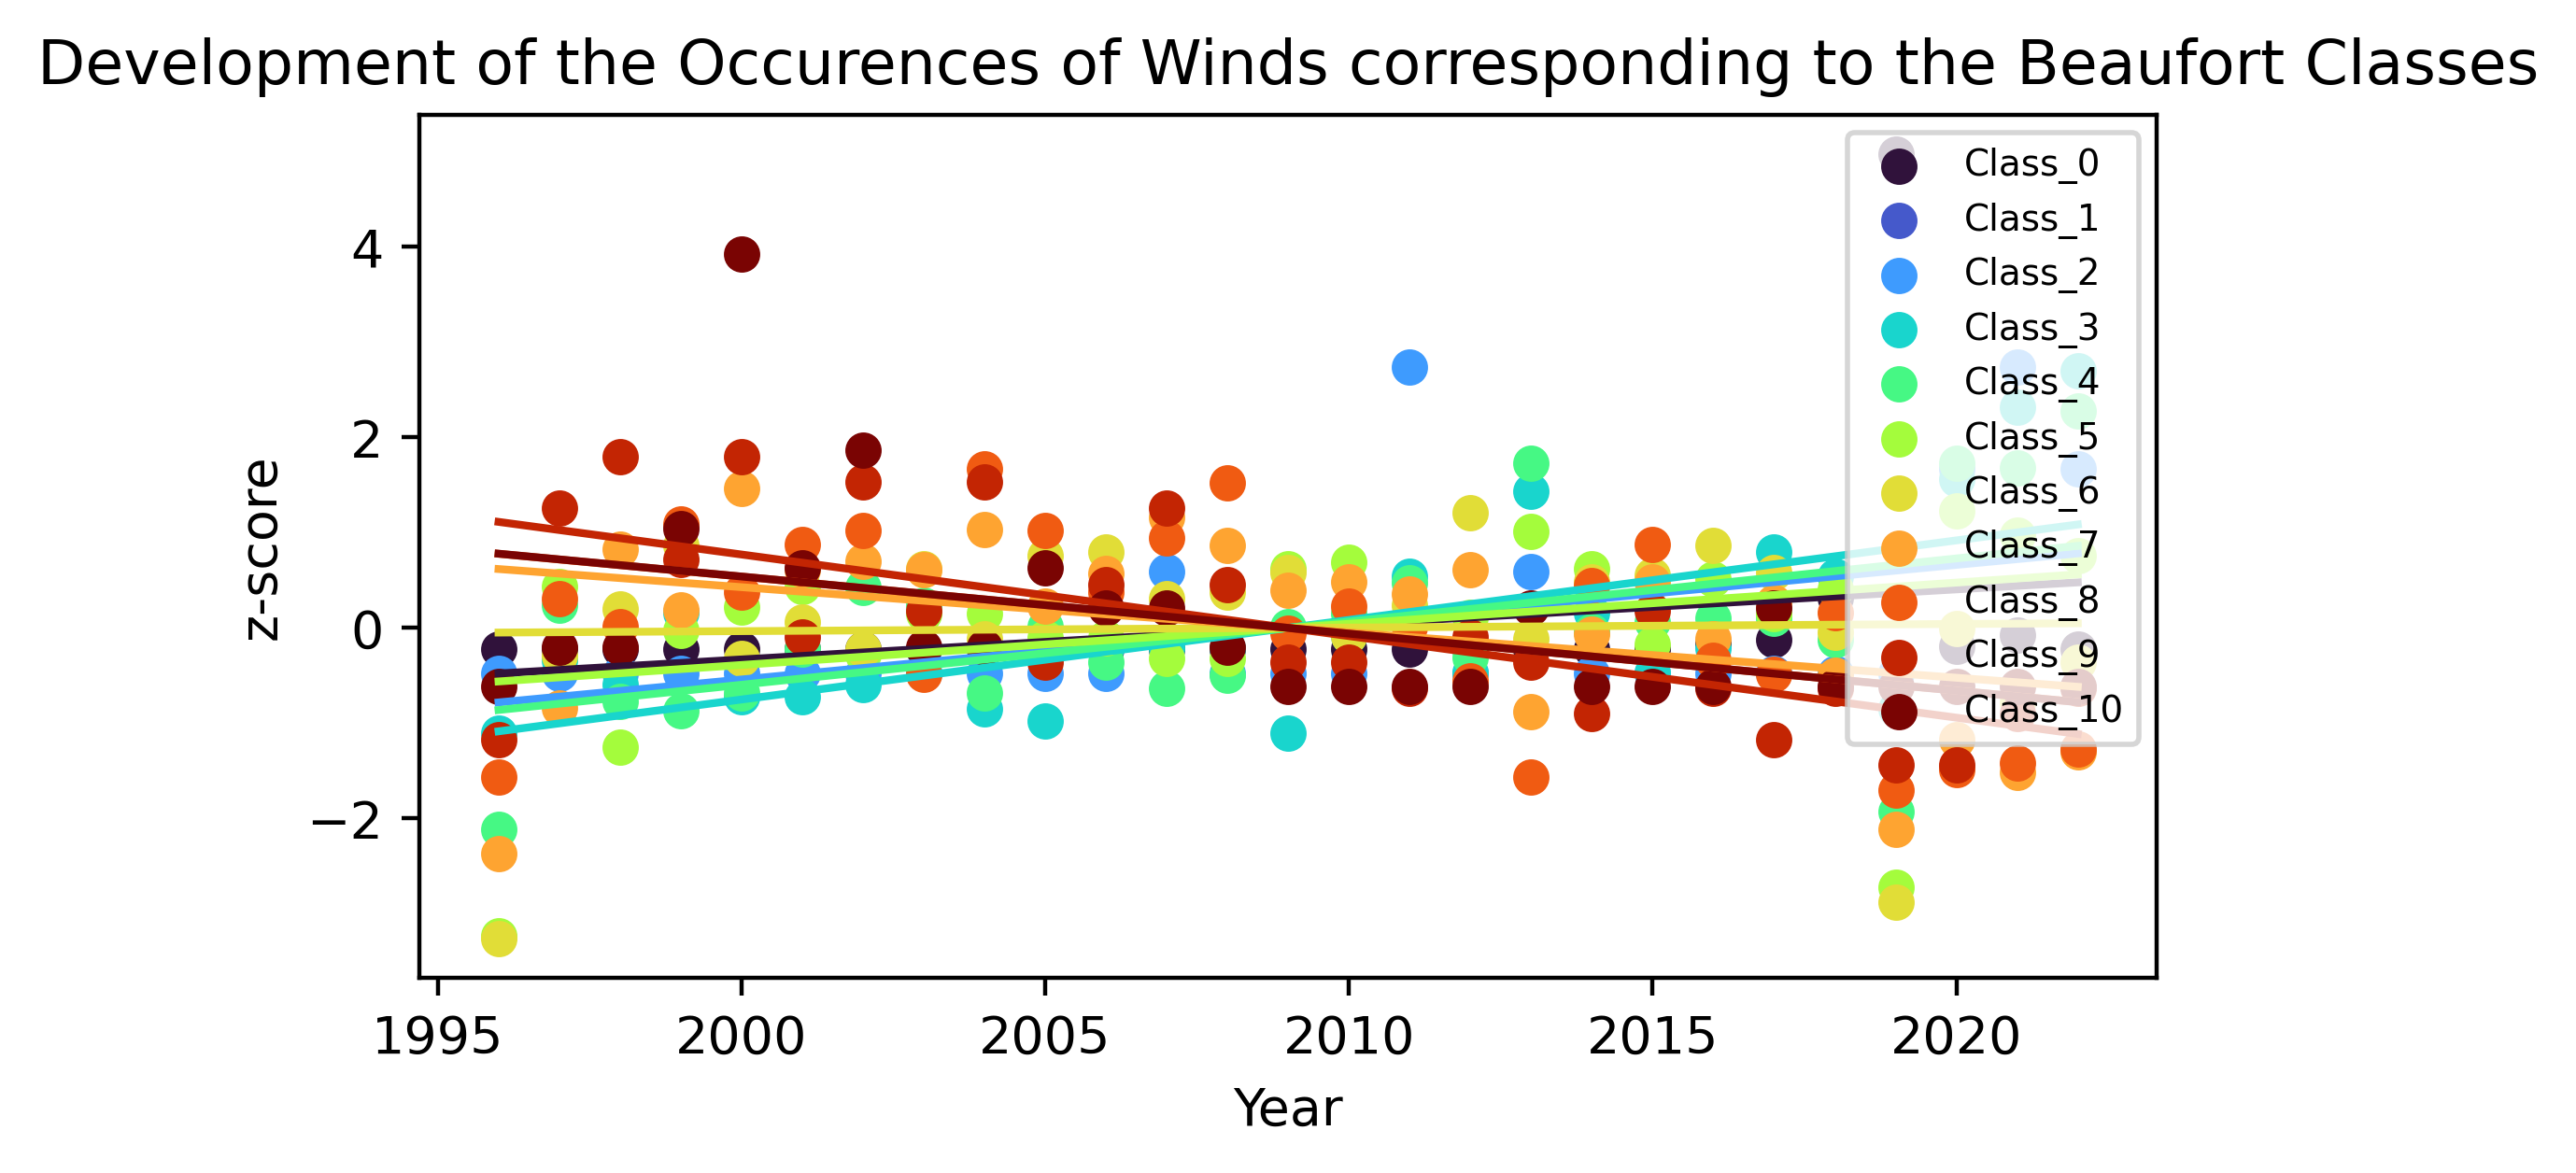

In [364]:
# First count the occurences and save them in a dataframe

for n in range(0,11):
    yearly_df[f'Class_{n}']=0
for y in year_arr:
    for n in range(0,11):
        yearly_df.loc[y-1996, f'Class_{n}']=len(daily_df[(daily_df['YEAR']==y) &(daily_df['bf_classification']==n)])

#compute the z-scores
for n in range(0,11):
    yearly_df[f'z_Class_{n}']= (yearly_df[f'Class_{n}']- yearly_df[f'Class_{n}'].mean())/yearly_df[f'Class_{n}'].std()

#print(yearly_df)


# now plot their z-scores and the corresponding linear regressions:

from matplotlib.colors import to_hex
class_colors = plt.cm.turbo(np.linspace(0,1,11))
class_colors= [to_hex(color) for color in class_colors]
for n in range(0,11):  
    plt.scatter(yearly_df['YEAR'], yearly_df[f'z_Class_{n}'],color=class_colors[n], label=f'Class_{n}')
    if n !=1 : # HERE IS AN ISSUE WITH CONVERGENCE
        pol=np.polyfit(year_arr, yearly_df[f'z_Class_{n}'] , 1)
        model = np.poly1d(pol)
        plt.plot(year_arr,model(year_arr),color=class_colors[n])

plt.legend(loc='best', fontsize=7)
plt.title('Development of the Occurences of Winds corresponding to the Beaufort Classes')
plt.ylabel('z-score')
plt.xlabel('Year')
plt.show()


['#30123b', '#4559cb', '#3e9bfe', '#19d5cd', '#46f884', '#a4fc3c', '#e1dd37', '#fea431', '#f05b12', '#c32503', '#7a0403']


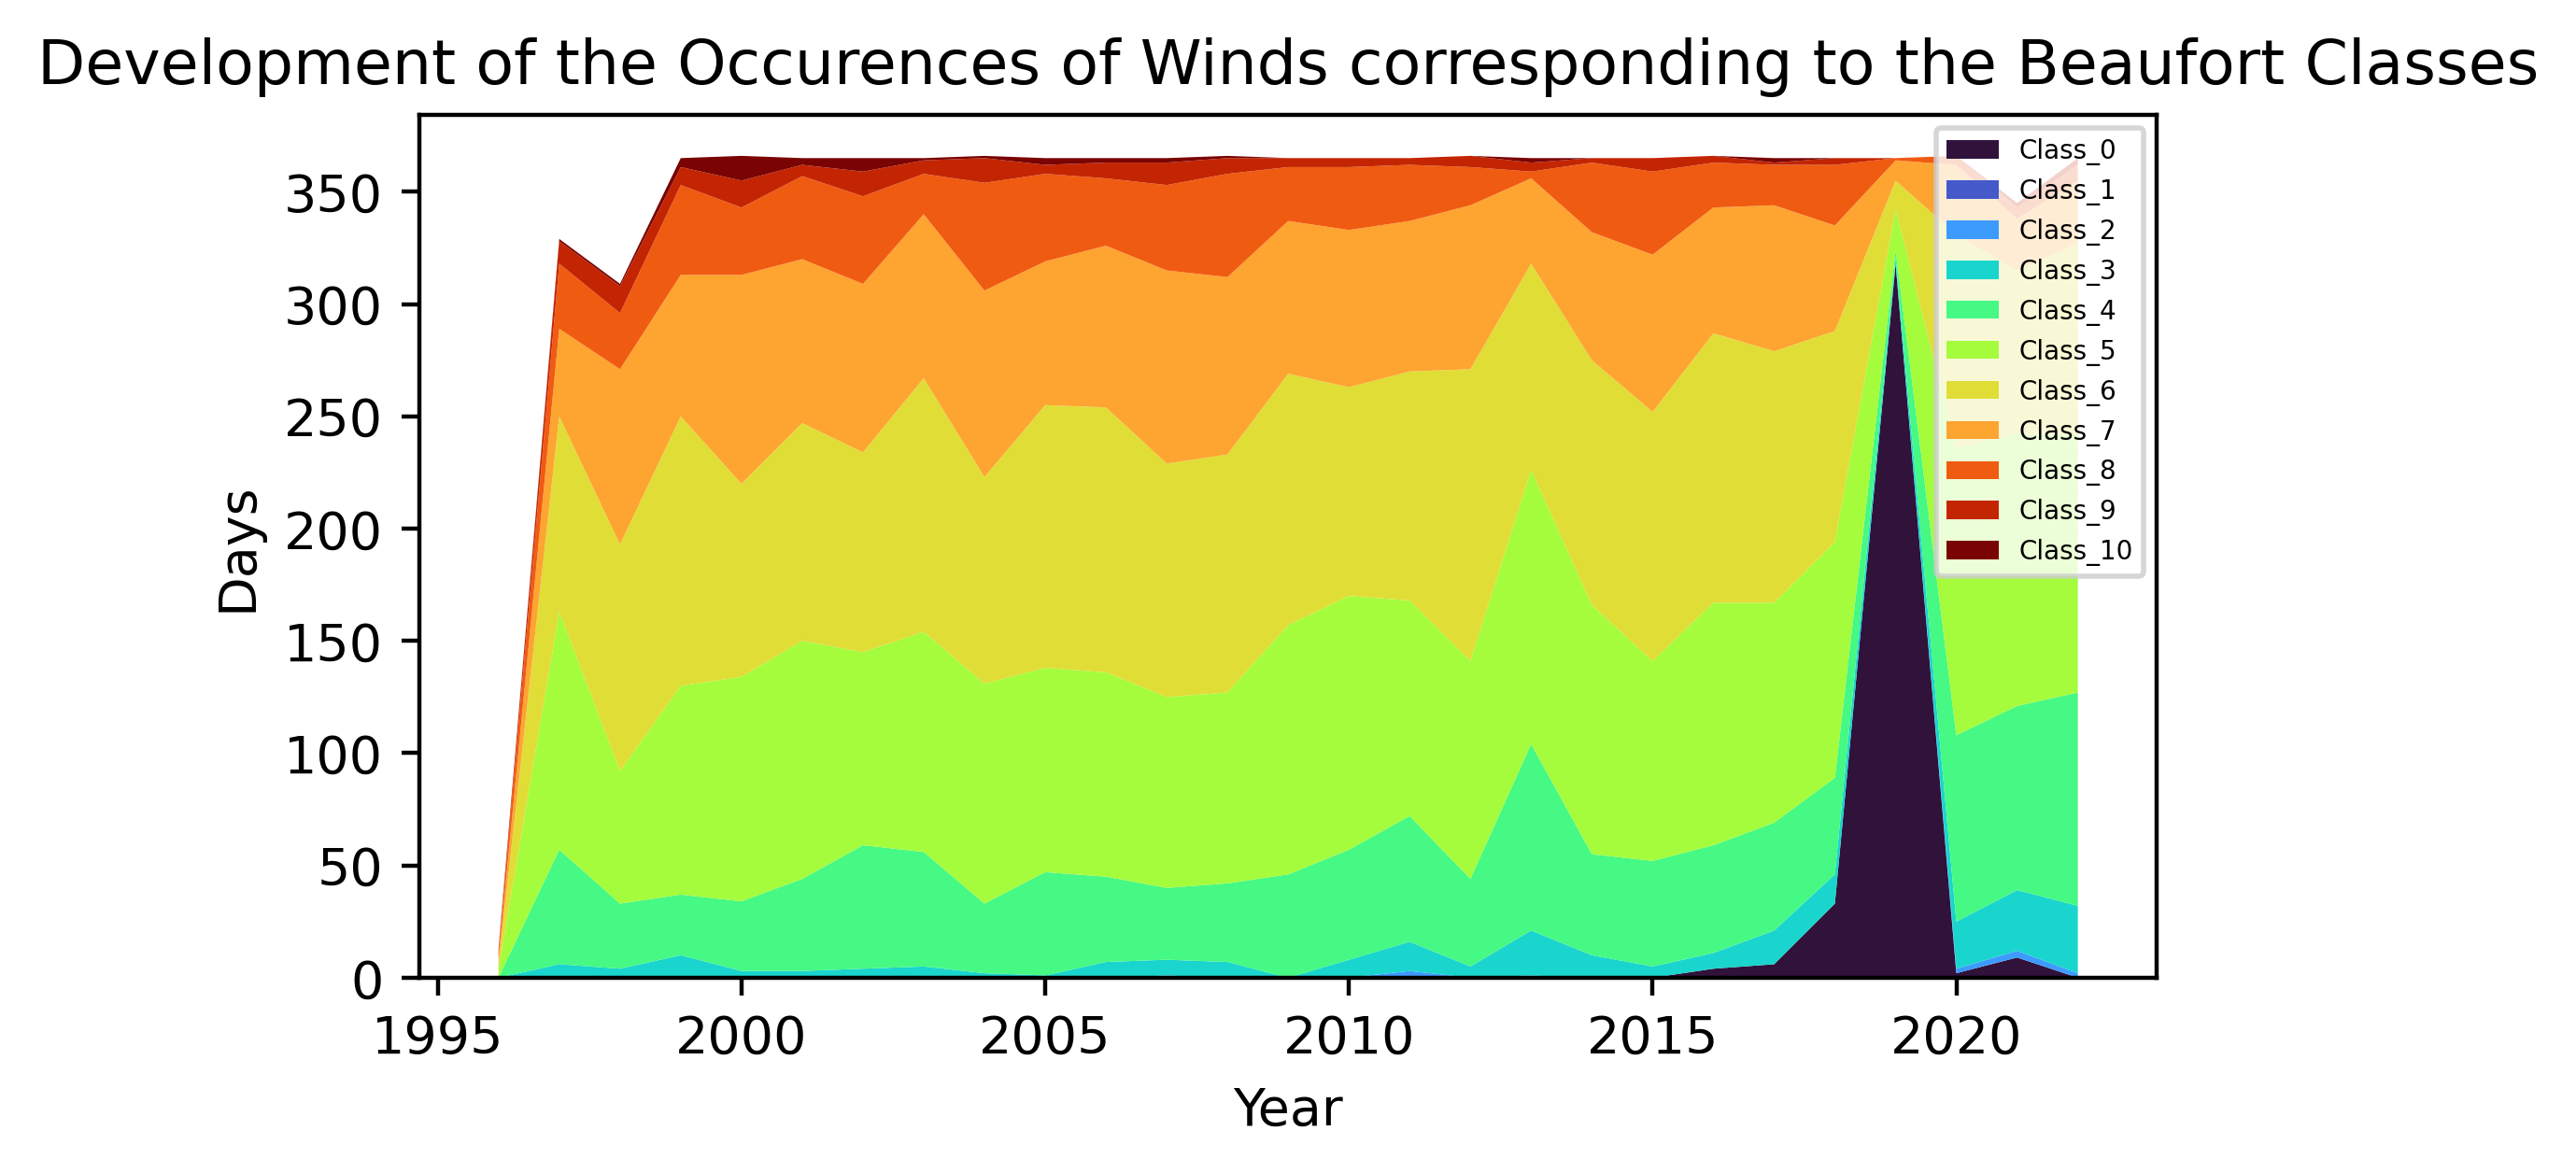

In [365]:
# Make a stackplot:
mylabels=[]
for n in range(0,11):
    mylabels=np.append(mylabels, f'Class_{n}')
print(class_colors)
plt.stackplot(year_arr,[yearly_df[f'Class_0'], yearly_df[f'Class_1'], yearly_df[f'Class_2'], yearly_df[f'Class_3'], yearly_df[f'Class_4'],
              yearly_df[f'Class_5'],yearly_df[f'Class_6'],yearly_df[f'Class_7'],yearly_df[f'Class_8'],yearly_df[f'Class_9'], yearly_df[f'Class_10']], 
              colors=class_colors, labels=mylabels)
plt.legend(loc='best', fontsize=5)

plt.title('Development of the Occurences of Winds corresponding to the Beaufort Classes')
plt.ylabel('Days')
plt.xlabel('Year')
plt.show()

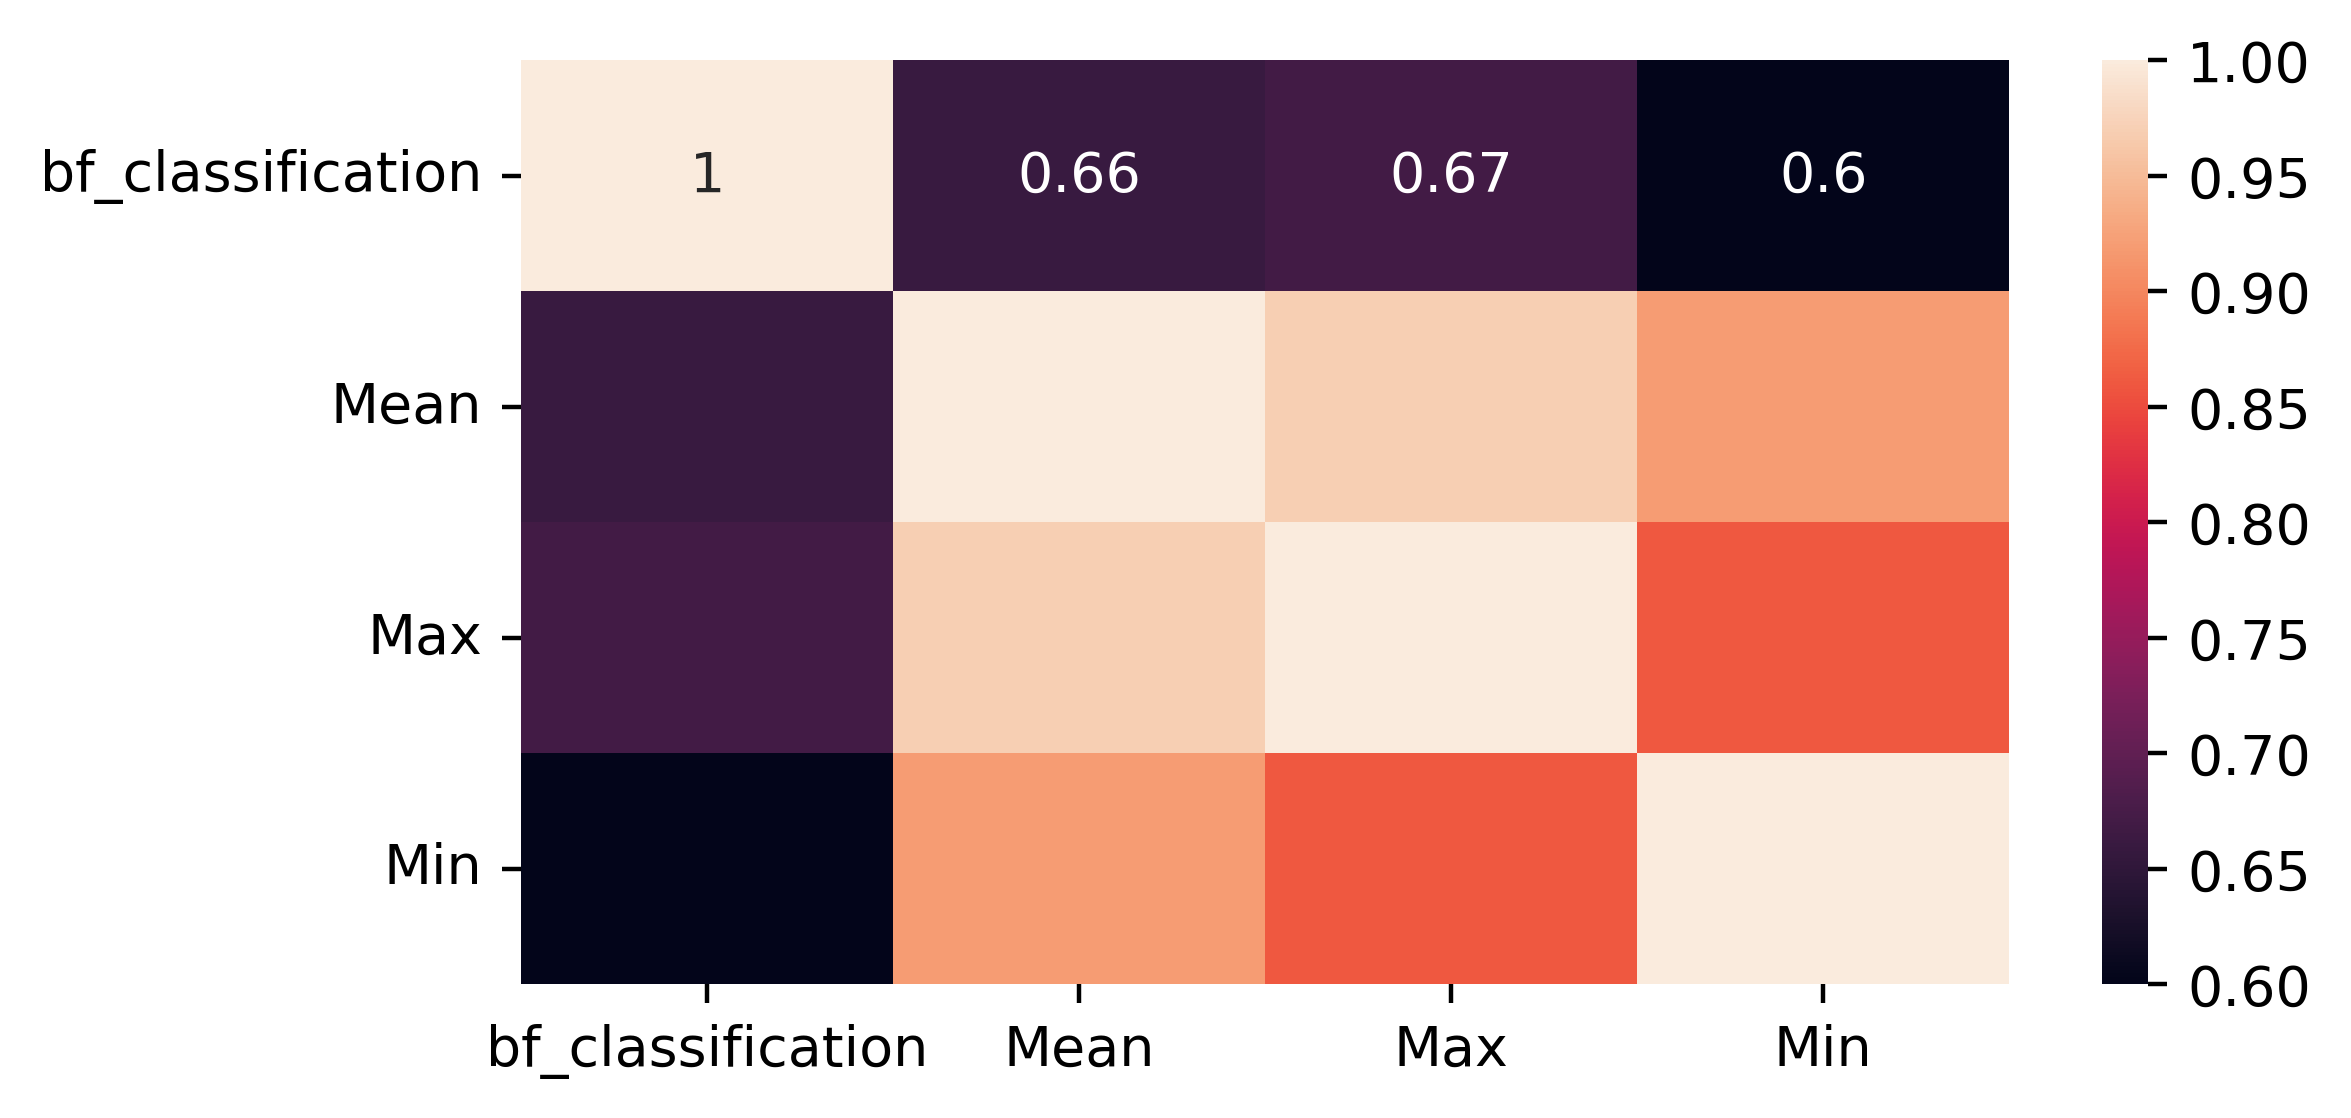

In [345]:
# check corellation of daily mean  etc. and classification: 
_ = plt.figure(figsize=(6, 3))
dm_corr_df = daily_df[['bf_classification','Mean', 'Max', 'Min'] ].corr().round(2)
sns.heatmap(dm_corr_df, annot=True)
plt.show()


# Load the data that starts in the 1950s

In [346]:
# contains the daily average windspeed starting in the 1950s
early_df = pd.read_csv(
    "FG_STAID000468.csv",
    skiprows=19,
    sep=",",
    index_col=None,
    skipfooter=0,
    engine="python",
)
    
column_headers = list(early_df.columns.values)
#print("The column headers are :", column_headers)
early_df=early_df.rename(columns={' SOUID': "SOUID", '    DATE': "DATE", '   FG': "FG", ' Q_FG' : "Q_FG"}) 

# convert the date and divide the windspeed by 10, so it's given in m/s
early_df['DATE']=pd.to_datetime(early_df["DATE"], format="%Y%m%d")
early_df['FG']=early_df['FG']/10
early_df['YEAR']=early_df['DATE'].dt.year

# classify the winspeeds again by the bf-scale (even though this does not really make sense for the daily averages): SHOULD CHANGE THIS
early_df['bf_classification']=bf_classifier_vectorized(early_df["FG"])

# make a dataframe that contains for each year how often each class for the daily mean occured

early_yearly_df=pd.DataFrame()
early_year_arr=np.linspace(1952, 2023,72)
early_yearly_df['YEAR']=early_year_arr

for n in range(0,11): 
    early_yearly_df[f'Class_{n}']=0
for y in early_year_arr:
    for n in range(0,11):
        early_yearly_df.loc[y-1952, f'Class_{n}']=len(early_df[(early_df['YEAR']==y) &(early_df['bf_classification']==n)])

#proper measurement starts not until 1959
early_yearly_df=early_yearly_df[7:]


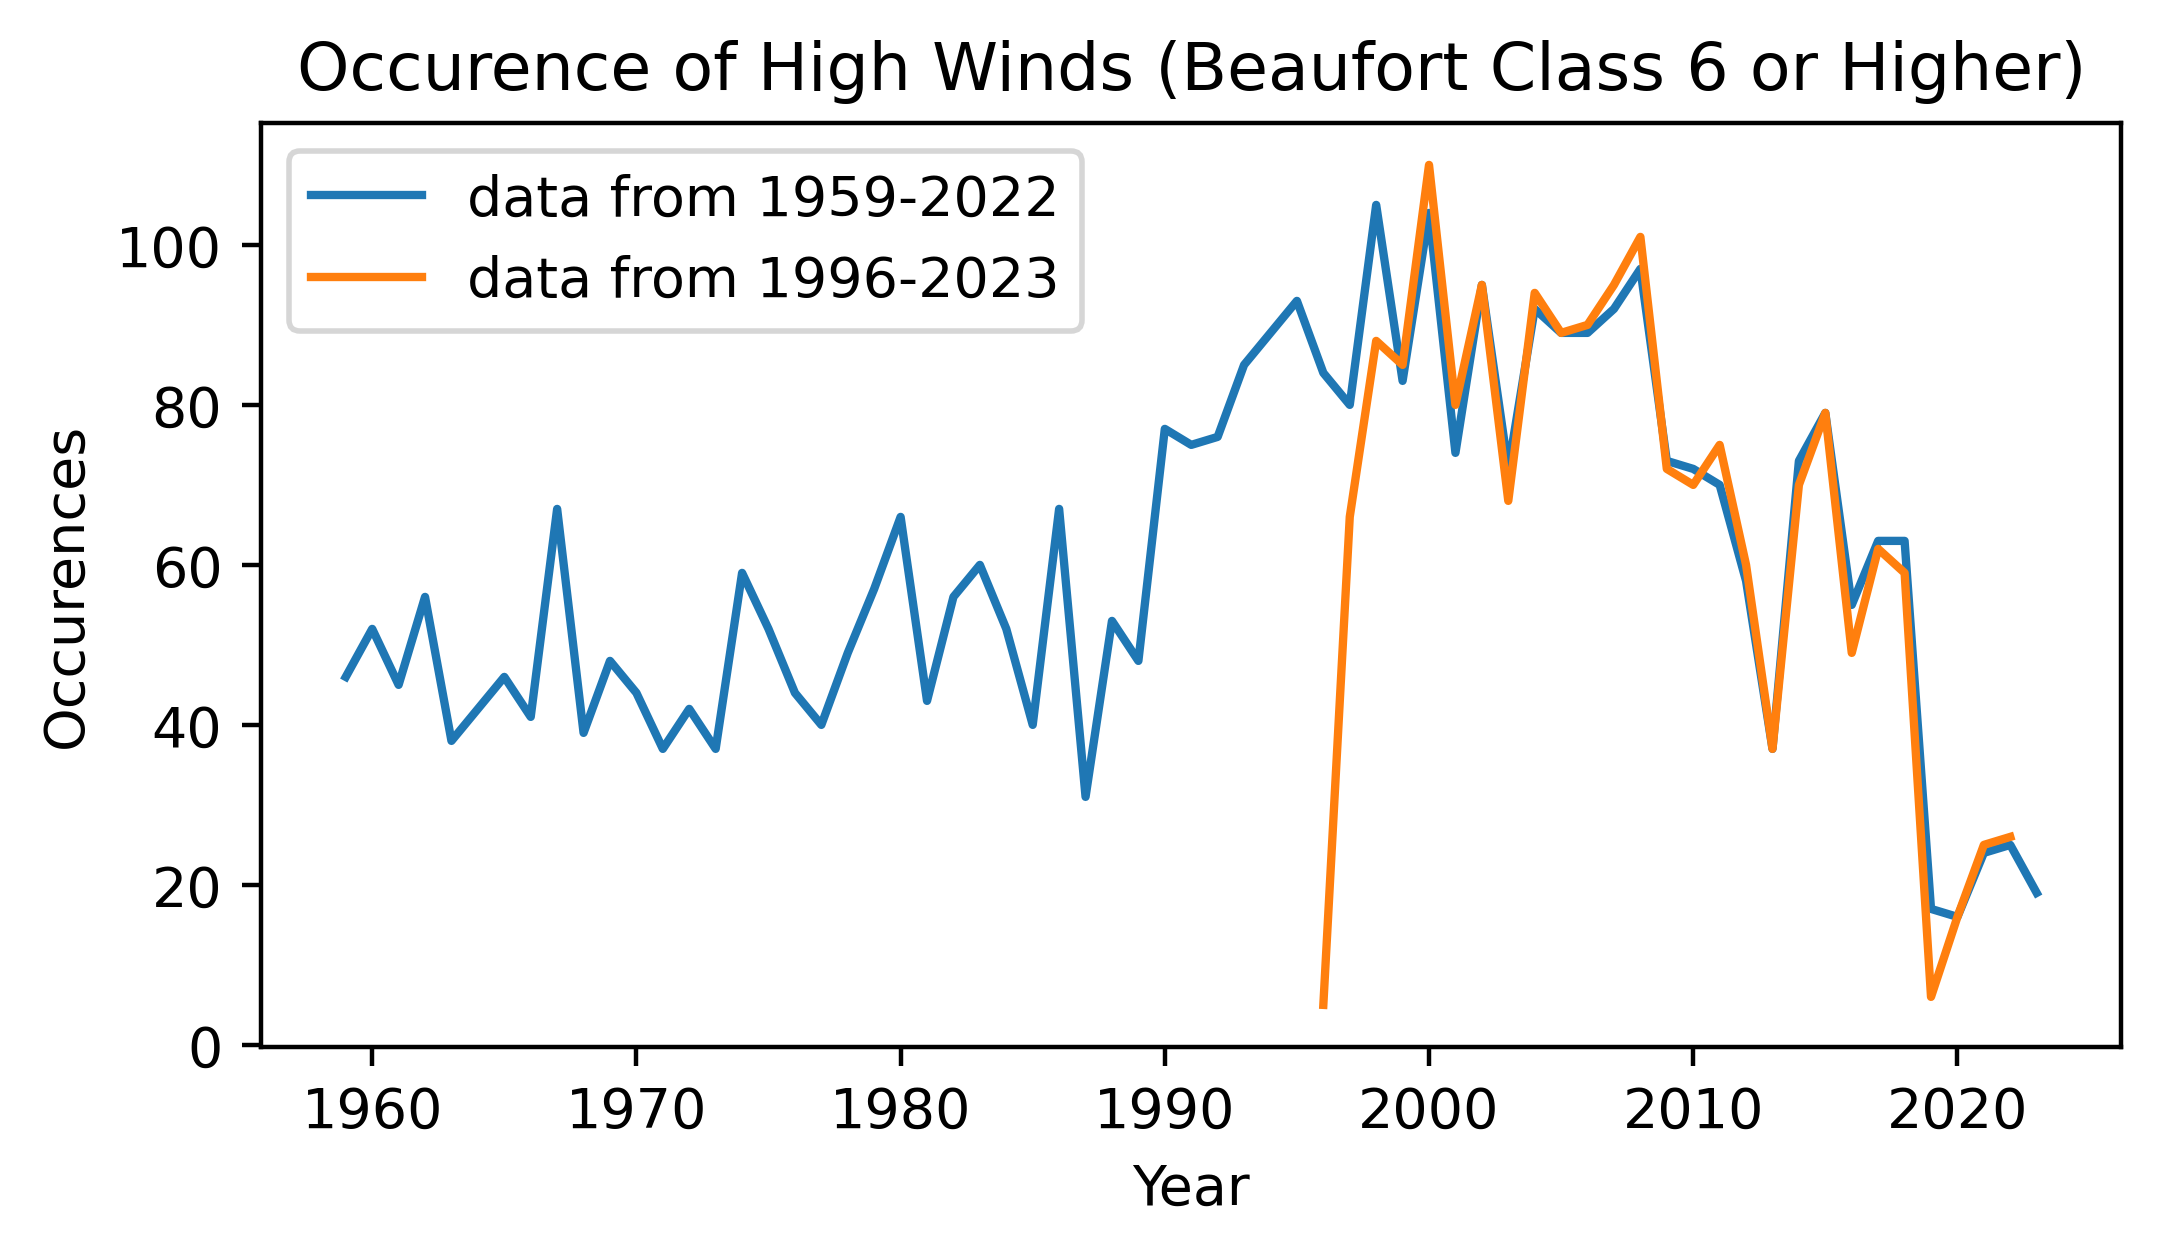

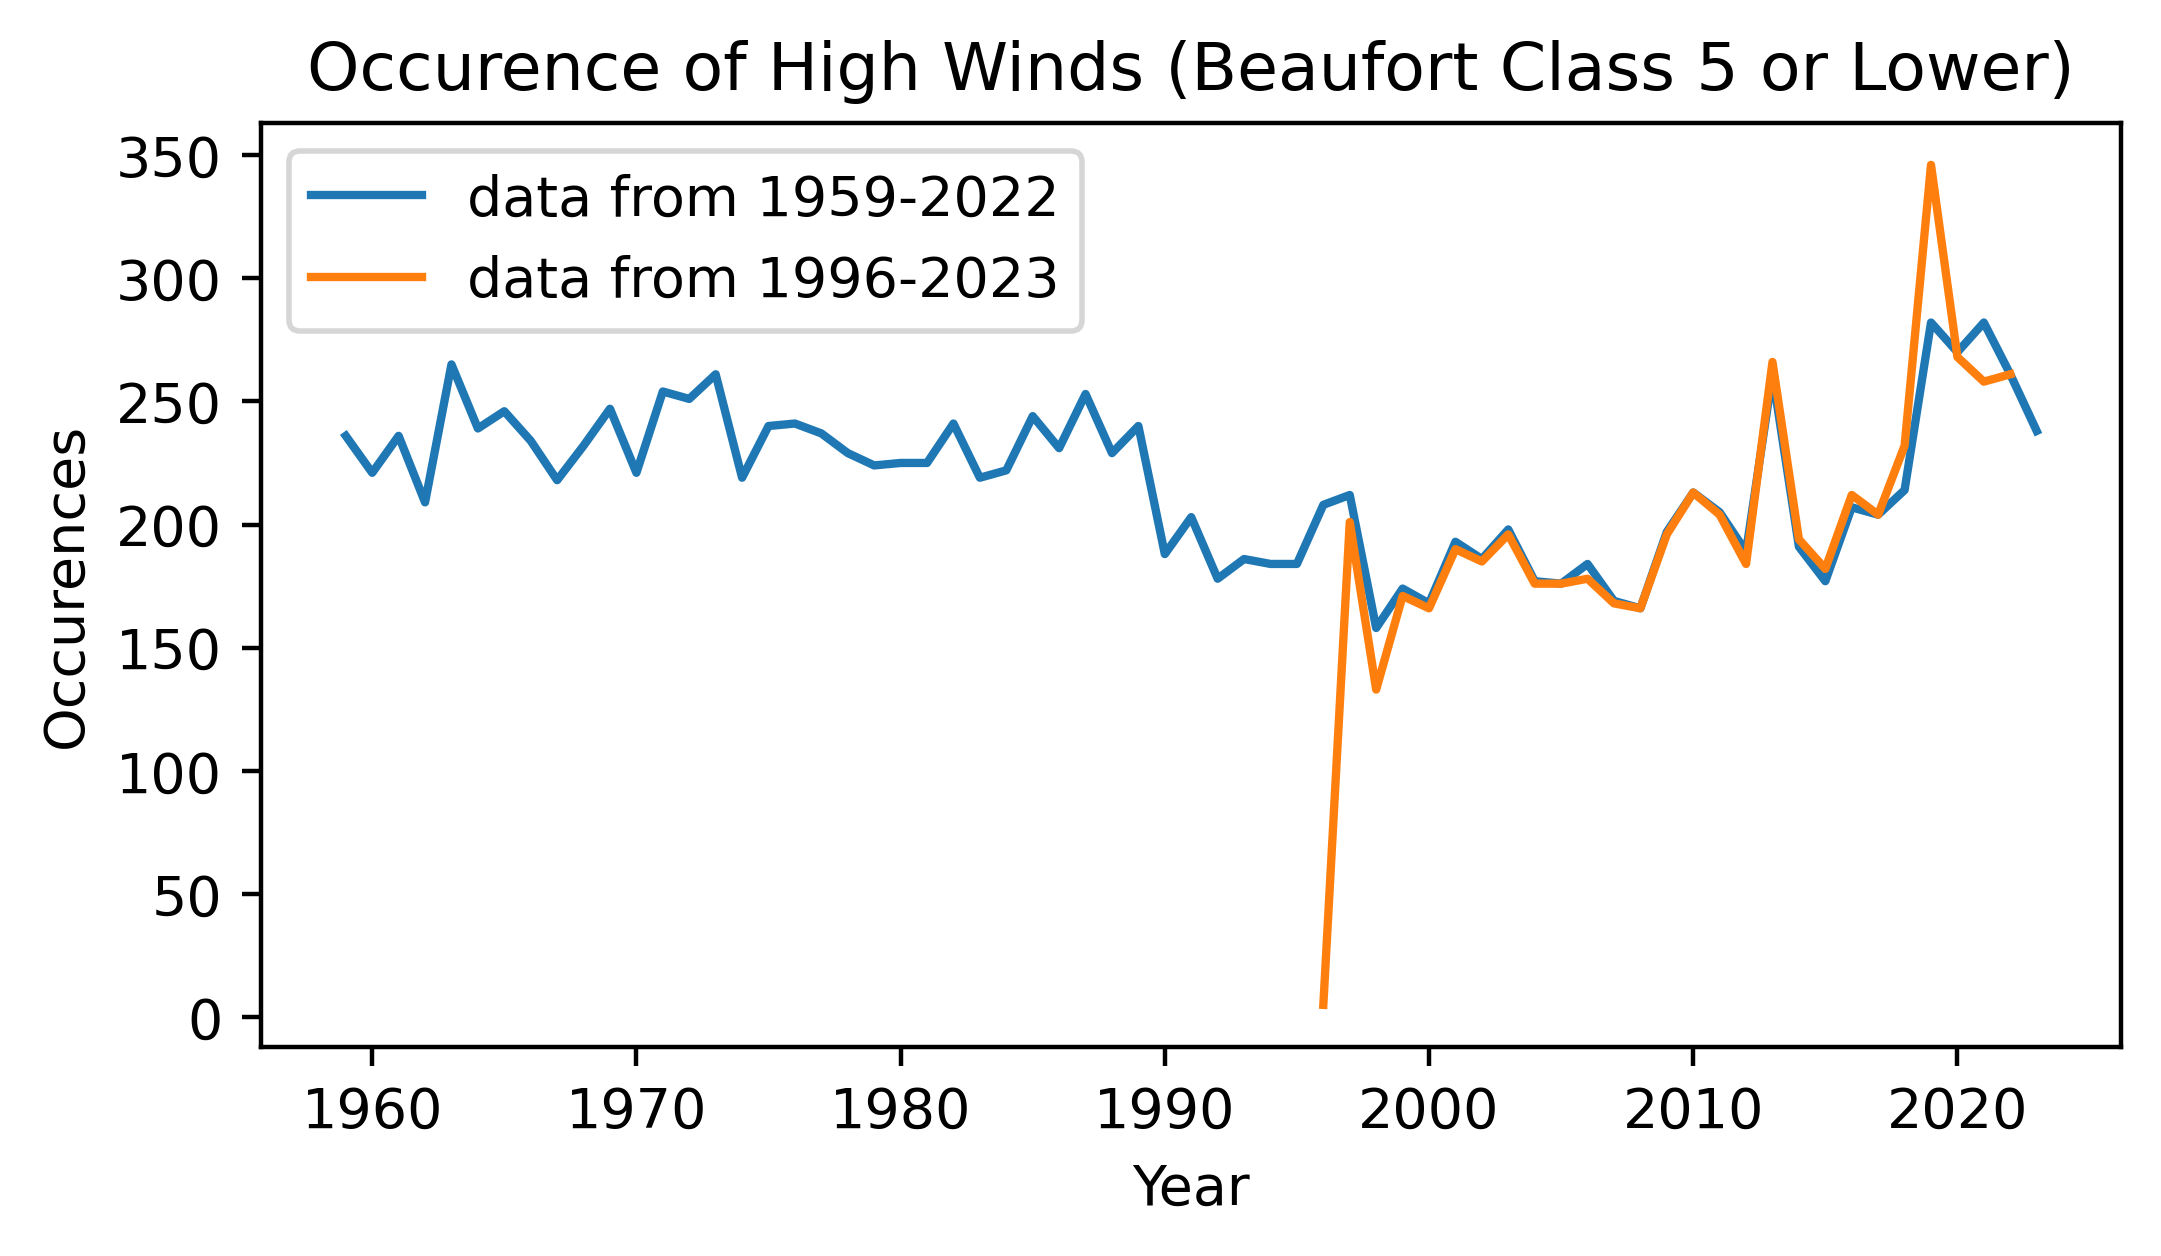

In [370]:
# Crosscheck with the other dataset that starts in 1996:
# do the classification of the mean in addition to the one by the max


daily_df['mean_bf_classification']=bf_classifier_vectorized(daily_df["Mean"])

for n in range(0,11):
    yearly_df[f'mean_Class_{n}']=0
for y in year_arr:
    for n in range(0,11):
        yearly_df.loc[y-1996, f'mean_Class_{n}']=len(daily_df[(daily_df['YEAR']==y) &(daily_df['mean_bf_classification']==n)])

yearly_df 



# for each year, plot how many days had an average of more than a class 6
plt.plot(early_yearly_df['YEAR'], early_yearly_df['Class_6'] +early_yearly_df['Class_7'] 
         +early_yearly_df['Class_8']+early_yearly_df['Class_9'] +early_yearly_df['Class_10'], label='data from 1959-2022')
plt.plot(yearly_df['YEAR'], yearly_df['mean_Class_6'] +yearly_df['mean_Class_7'] 
         +yearly_df['mean_Class_8']+yearly_df['mean_Class_9']+ yearly_df['mean_Class_10'], label='data from 1996-2023')
plt.title('Occurence of High Winds (Beaufort Class 6 or Higher)')
plt.ylabel('Occurences')
plt.xlabel('Year')
plt.legend()
plt.show()


# for each year, plot how many days had an average of less than a class 5
plt.plot(early_yearly_df['YEAR'], early_yearly_df['Class_0'] +early_yearly_df['Class_1'] 
         +early_yearly_df['Class_2']+early_yearly_df['Class_3'] +early_yearly_df['Class_4'], label='data from 1959-2022')
plt.plot(yearly_df['YEAR'], yearly_df['mean_Class_0'] +yearly_df['mean_Class_1'] 
         +yearly_df['mean_Class_2']+yearly_df['mean_Class_3']+ yearly_df['mean_Class_4'], label='data from 1996-2023')
plt.title('Occurence of High Winds (Beaufort Class 5 or Lower)')
plt.ylabel('Occurences')
plt.xlabel('Year')
plt.legend()
plt.show()

#### Ignore everything from here downwards

In [348]:
from datetime import datetime
# Find all the storms, as classified by the Beaufort-scale
storm_df=df.copy() 
storm_df=storm_df.loc[storm_df["FF_10_wind"] >=24.5]
#for i in storm_df.index:
  #print(i)
  #print(f'This is the row: {storm_df.loc[i, "FF_10_wind"]}')
  #if storm_df.loc[i, "FF_10_wind"] < 250:
   #storm_df.drop(i, inplace = True)
  

#print(storm_df)
#plt.scatter( storm_df['MESS_DATUM'],storm_df['FF_10_wind'] )
#plt.show()

maxstorm_df=storm_df.copy()
storm_df.reset_index(drop=True, inplace=True)
# for each stormy day only keep the data point with the max windsped
current_date=datetime(1000, 1 , 1)
current_max_speed=0
maxdict=dict()

for i in maxstorm_df.index :
    # add a new dictionary entry, wehenever a new day begins 
    if  (current_date != maxstorm_df.loc[i, 'MESS_DATUM'].date()):
        current_date=maxstorm_df.loc[i, 'MESS_DATUM'].date()
        #print(maxstorm_df.loc[i, 'MESS_DATUM'].date())
        #print(current_date)
        maxdict[current_date]=0
    if maxdict[current_date]< maxstorm_df.loc[i, "FF_10_wind"]:
        maxdict[current_date]=maxstorm_df.loc[i, "FF_10_wind"]



'''
for i in maxstorm_df.index :
    if i < l-1:
        if (maxstorm_df.loc[i, "FF_10_wind"] == maxstorm_df.loc[i+1, "FF_10_wind"]):
            maxstorm_df.drop(i, inplace = True)
'''

for i in maxstorm_df.index :
    if maxdict[maxstorm_df.loc[i, 'MESS_DATUM'].date()] != maxstorm_df.loc[i, "FF_10_wind"]:
        maxstorm_df.drop(i, inplace = True)


maxstorm_df.reset_index(drop=True, inplace=True)
l=len(maxstorm_df)
for i in maxstorm_df.index :
    if i < l-1:
        if (maxstorm_df.loc[i, "MESS_DATUM"].date() == maxstorm_df.loc[i+1, "MESS_DATUM"].date()):
            maxstorm_df.drop(i, inplace = True)





In [349]:
# Find df for a beaufort 9 but not a 10
bf9_df=df.copy() 
bf9_df=bf9_df.loc[bf9_df["FF_10_wind"] >=20.8 ]

bf9_df=bf9_df.loc[bf9_df["FF_10_wind"] <24.5 ]

#find individual days

bf9_days_df=bf9_df.copy()
bf9_days_df.reset_index(drop=True, inplace=True)
l9=len(bf9_days_df)
for i in bf9_days_df.index :
    if i < l9-1:
        if (bf9_days_df.loc[i, "MESS_DATUM"].date() == bf9_days_df.loc[i+1, "MESS_DATUM"].date()):
            bf9_days_df.drop(i, inplace = True)

In [350]:
# Find df for a beaufort 8 but not a 9
bf8_df=df.copy() 
bf8_df=bf8_df.loc[bf8_df["FF_10_wind"] >=17.2 ]

bf8_df=bf8_df.loc[bf8_df["FF_10_wind"] <20.8 ]

#find individual days

bf8_days_df=bf8_df.copy()
bf8_days_df.reset_index(drop=True, inplace=True)
l8=len(bf8_days_df)
for i in bf8_days_df.index :
    if i < l8-1:
        if (bf8_days_df.loc[i, "MESS_DATUM"].date() == bf8_days_df.loc[i+1, "MESS_DATUM"].date()):
            bf8_days_df.drop(i, inplace = True)

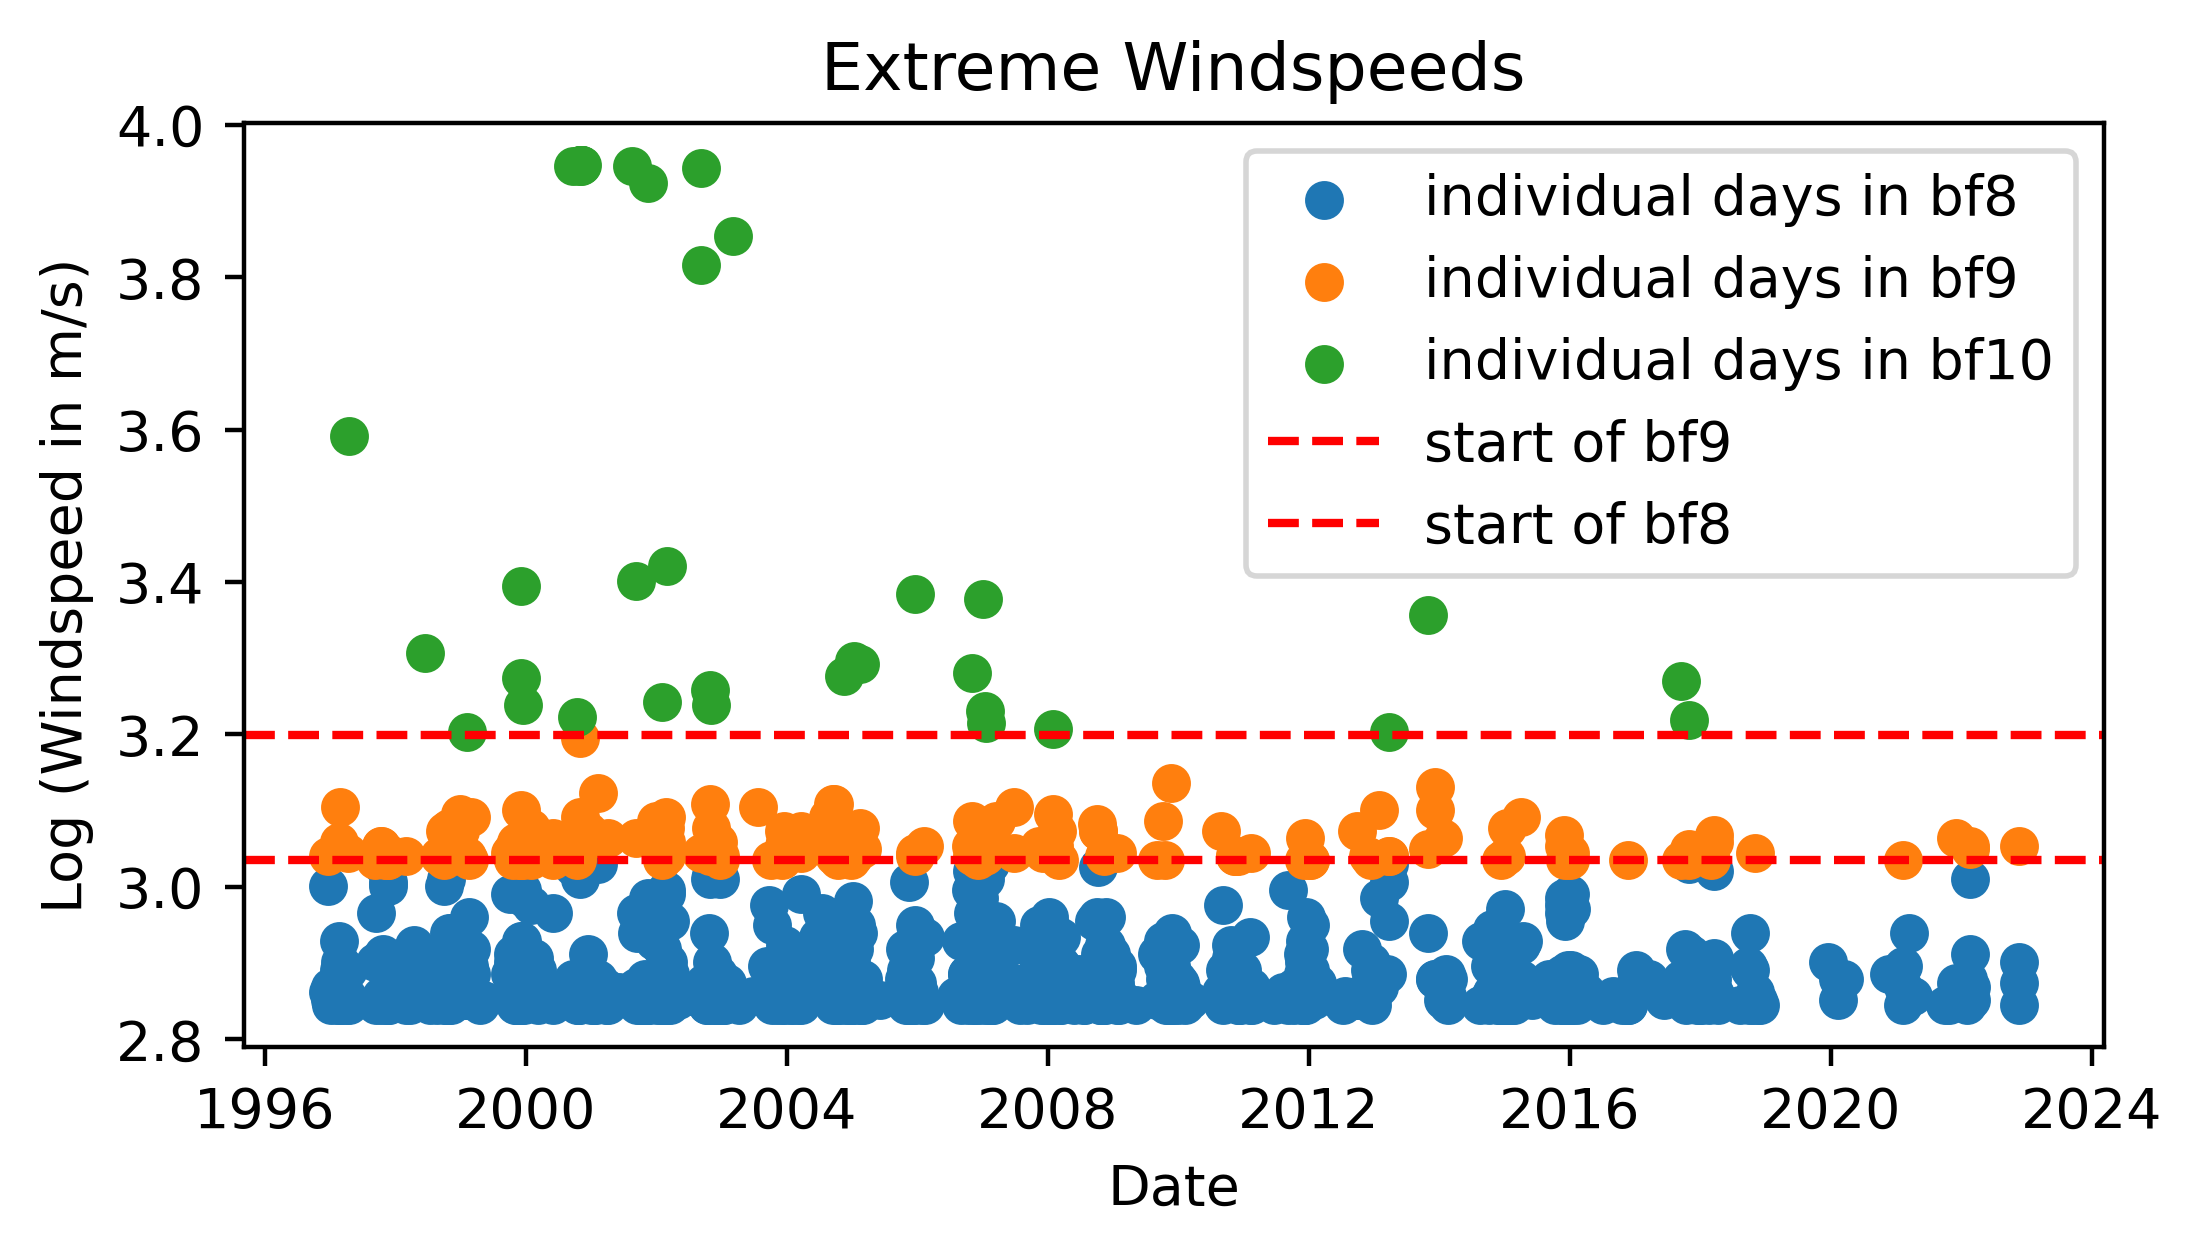

'\nplt.scatter(np.linspace(0, len(maxstorm_df), len(maxstorm_df)),maxstorm_df["FF_10_wind"])\nplt.show()\n\nplt.scatter(np.linspace(0, len(bf9_days_df), len(bf9_days_df)),bf9_days_df["FF_10_wind"])\nplt.show()\n'

In [351]:

plt.scatter(bf8_days_df["MESS_DATUM"],np.log(bf8_days_df["FF_10_wind"]), label='individual days in bf8')
plt.scatter(bf9_days_df["MESS_DATUM"],np.log(bf9_days_df["FF_10_wind"]), label='individual days in bf9')
#plt.scatter(storm_df["MESS_DATUM"],storm_df["FF_10_wind"], label='all data points in bf10')
plt.scatter(maxstorm_df["MESS_DATUM"],np.log(maxstorm_df["FF_10_wind"]), label='individual days in bf10')

plt.axhline(y=np.log(24.5), color='red', linestyle='--', label='start of bf9')

plt.axhline(y=np.log(20.8), color='red', linestyle='--', label='start of bf8')

plt.title('Extreme Windspeeds')
plt.xlabel('Date')
plt.ylabel('Log (Windspeed in m/s)')
plt.legend(loc='best')
plt.show()

'''
plt.scatter(np.linspace(0, len(maxstorm_df), len(maxstorm_df)),maxstorm_df["FF_10_wind"])
plt.show()

plt.scatter(np.linspace(0, len(bf9_days_df), len(bf9_days_df)),bf9_days_df["FF_10_wind"])
plt.show()
'''


#maxstorm_df.to_csv('storm_data2.csv', index=False, sep='\t', header=True)

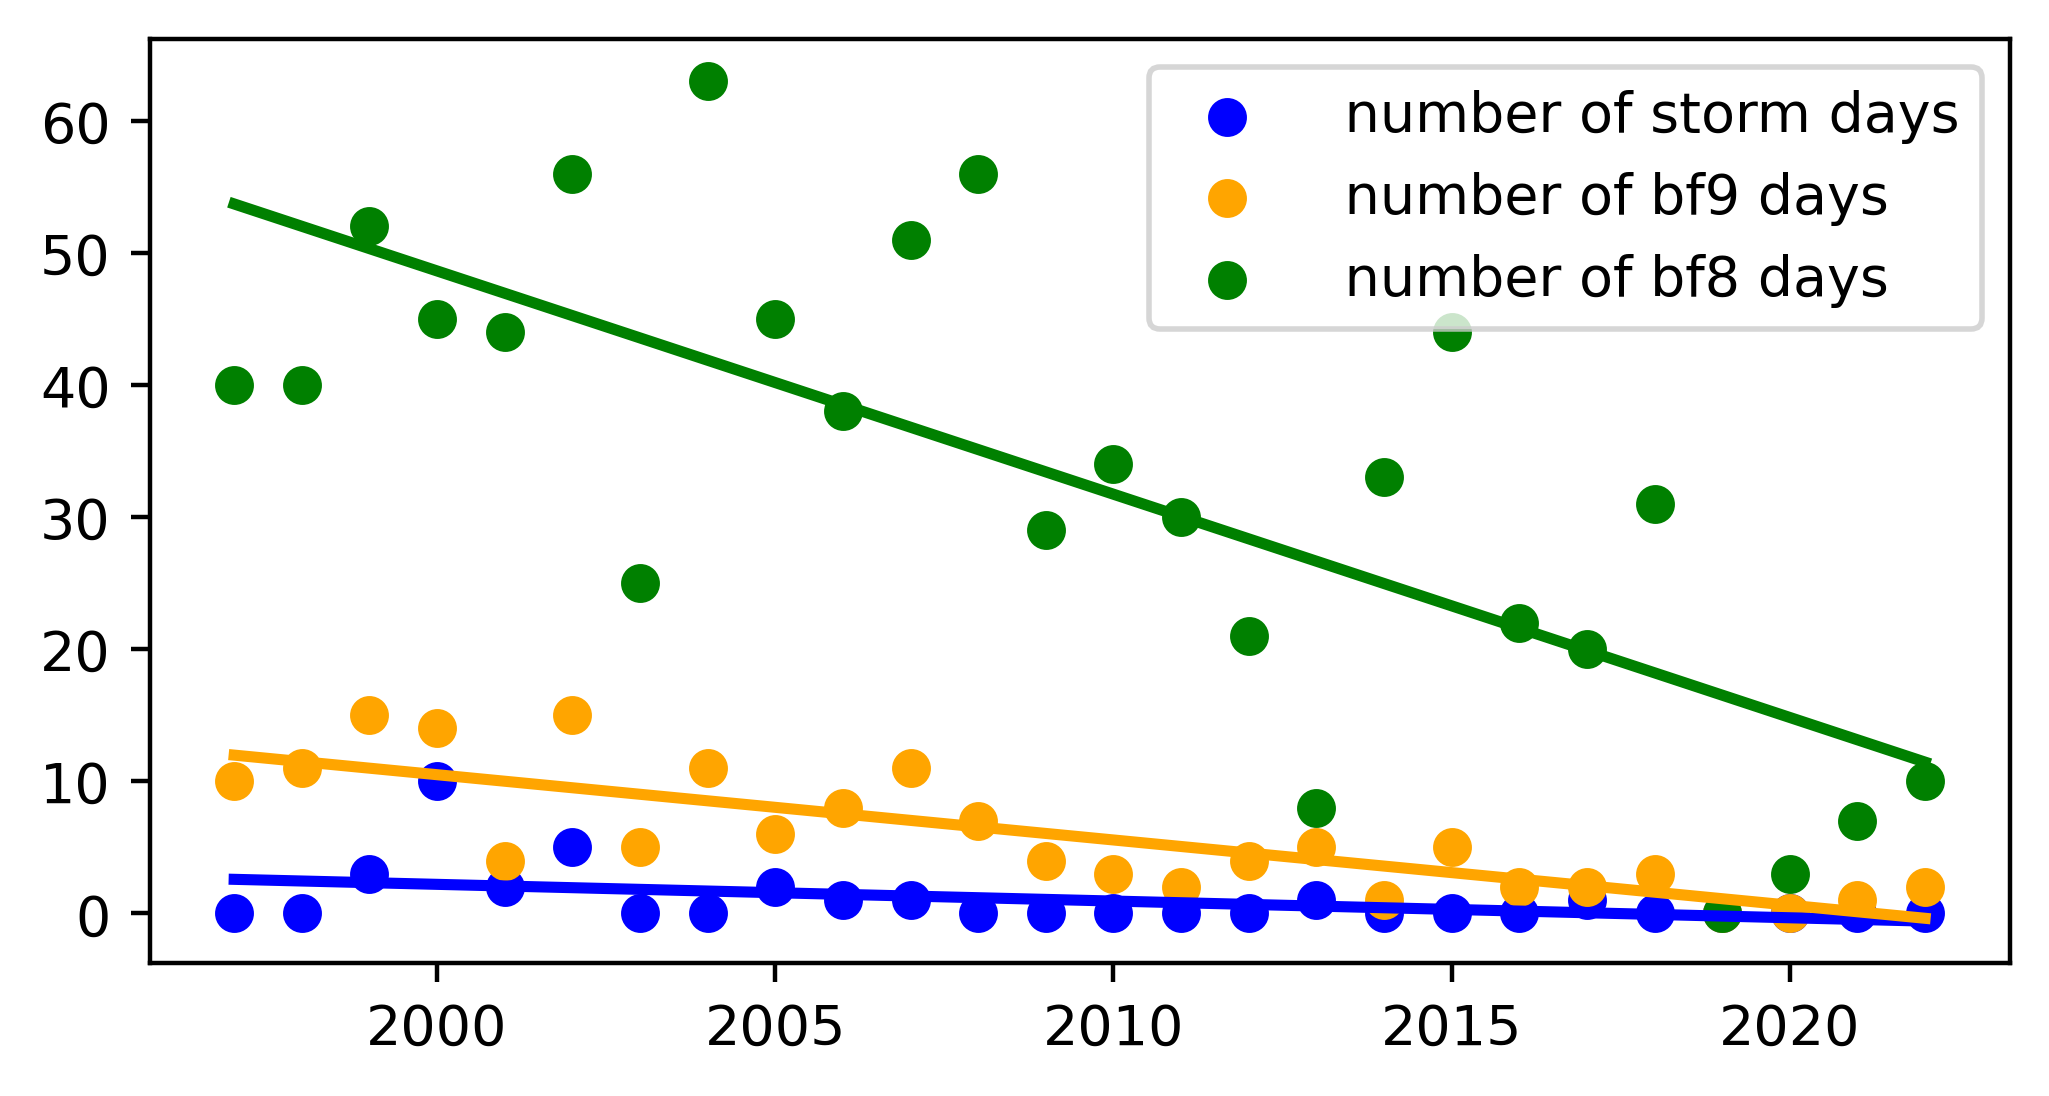

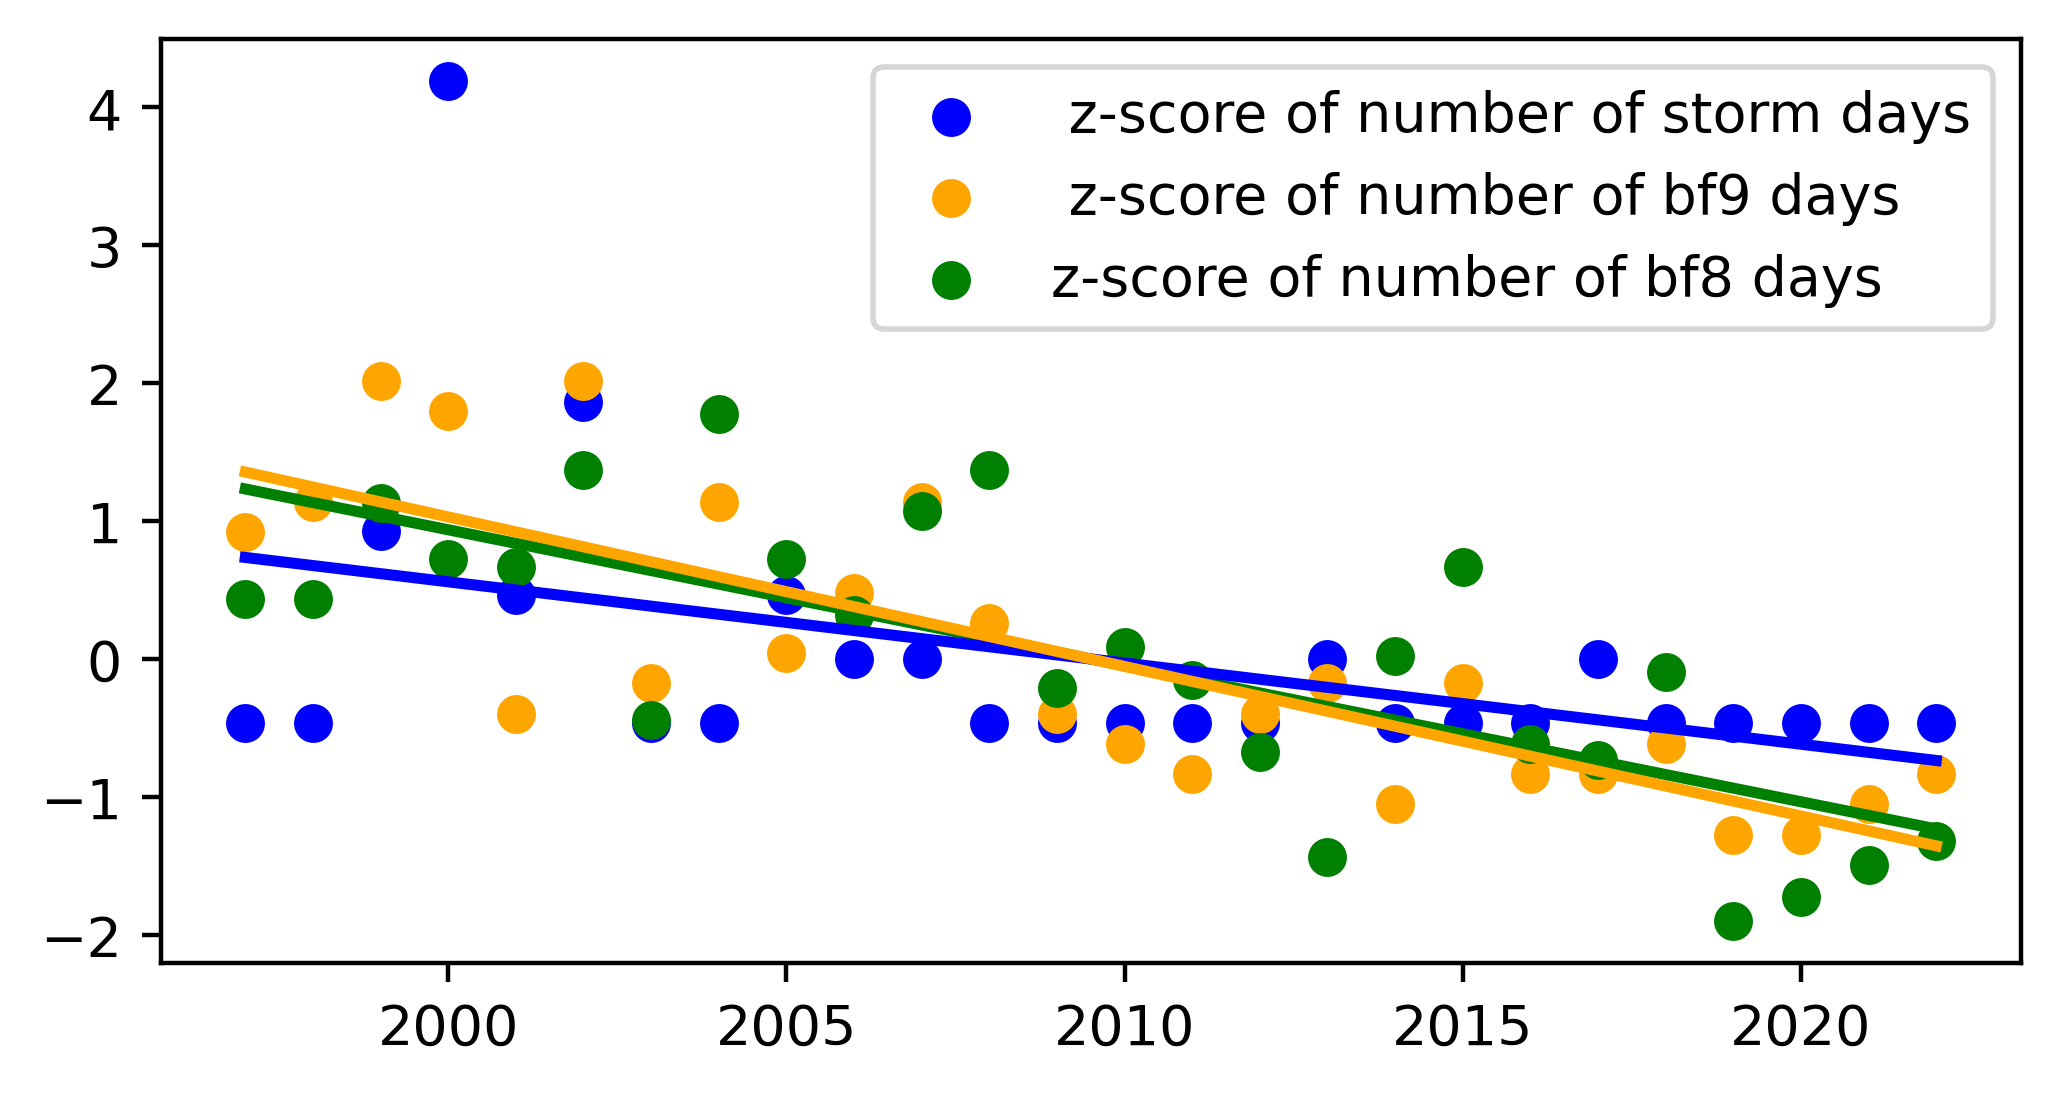

In [352]:
# plot the number of extreme windspeeds by year
xarr=np.arange(1997, 2023)

number_of_stormy_days=dict()
number_of_bf9_days=dict()
number_of_bf8_days=dict()

for i in maxstorm_df.index:
    if maxstorm_df.loc[i, "MESS_DATUM"].year not in number_of_stormy_days:
        number_of_stormy_days[maxstorm_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_stormy_days[maxstorm_df.loc[i, "MESS_DATUM"].year]+=1


for i in bf9_days_df.index:
    if bf9_days_df.loc[i, "MESS_DATUM"].year not in number_of_bf9_days:
        number_of_bf9_days[bf9_days_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_bf9_days[bf9_days_df.loc[i, "MESS_DATUM"].year]+=1

for i in bf8_days_df.index:
    if bf8_days_df.loc[i, "MESS_DATUM"].year not in number_of_bf8_days:
        number_of_bf8_days[bf8_days_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_bf8_days[bf8_days_df.loc[i, "MESS_DATUM"].year]+=1

# turn dictionarys to arrays
storm_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_stormy_days:
        storm_arr=np.append(storm_arr, number_of_stormy_days[xarr[i]])
   else:
      storm_arr=np.append(storm_arr,0) 

bf9_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf9_days:
        bf9_arr=np.append(bf9_arr, number_of_bf9_days[xarr[i]])
   else:
      bf9_arr=np.append(bf9_arr,0) 

bf8_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf8_days:
        bf8_arr=np.append(bf8_arr, number_of_bf8_days[xarr[i]])
   else:
      bf8_arr=np.append(bf8_arr,0) 


# polynomial regression and plotting
bf9_pol=np.polyfit(xarr, bf9_arr, 1)
bf9_model = np.poly1d(bf9_pol)

bf8_pol=np.polyfit(xarr, bf8_arr, 1)
bf8_model = np.poly1d(bf8_pol)

storm_pol=np.polyfit(xarr, storm_arr, 1)
storm_model = np.poly1d(storm_pol)

plt.scatter(xarr, storm_arr, color='blue', label=' number of storm days')
plt.scatter(xarr, bf9_arr,  color='orange', label=' number of bf9 days ')

plt.scatter(xarr, bf8_arr,  color='green', label=' number of bf8 days ')
plt.plot(xarr, bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, bf9_model(xarr), color='orange', linewidth = 2)
plt.legend()
plt.show()


# Now plot the z-scores: 
z_bf9_arr=(bf9_arr- np.mean(bf9_arr))/np.std(bf9_arr)

z_bf8_arr=(bf8_arr- np.mean(bf8_arr))/np.std(bf8_arr)

z_storm_arr=(storm_arr- np.mean(storm_arr))/np.std(storm_arr)


z_bf9_pol=np.polyfit(xarr, z_bf9_arr, 1)
z_bf9_model = np.poly1d(z_bf9_pol)

z_bf8_pol=np.polyfit(xarr, z_bf8_arr, 1)
z_bf8_model = np.poly1d(z_bf8_pol)

z_storm_pol=np.polyfit(xarr, z_storm_arr, 1)
z_storm_model = np.poly1d(z_storm_pol)

plt.scatter(xarr, z_storm_arr, color='blue', label=' z-score of number of storm days')
plt.scatter(xarr, z_bf9_arr,  color='orange', label=' z-score of number of bf9 days ')
plt.scatter(xarr, z_bf8_arr,  color='green', label='z-score of number of bf8 days ')

plt.plot(xarr, z_bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, z_storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, z_bf9_model(xarr), color='orange', linewidth = 2)

plt.legend()
plt.show()




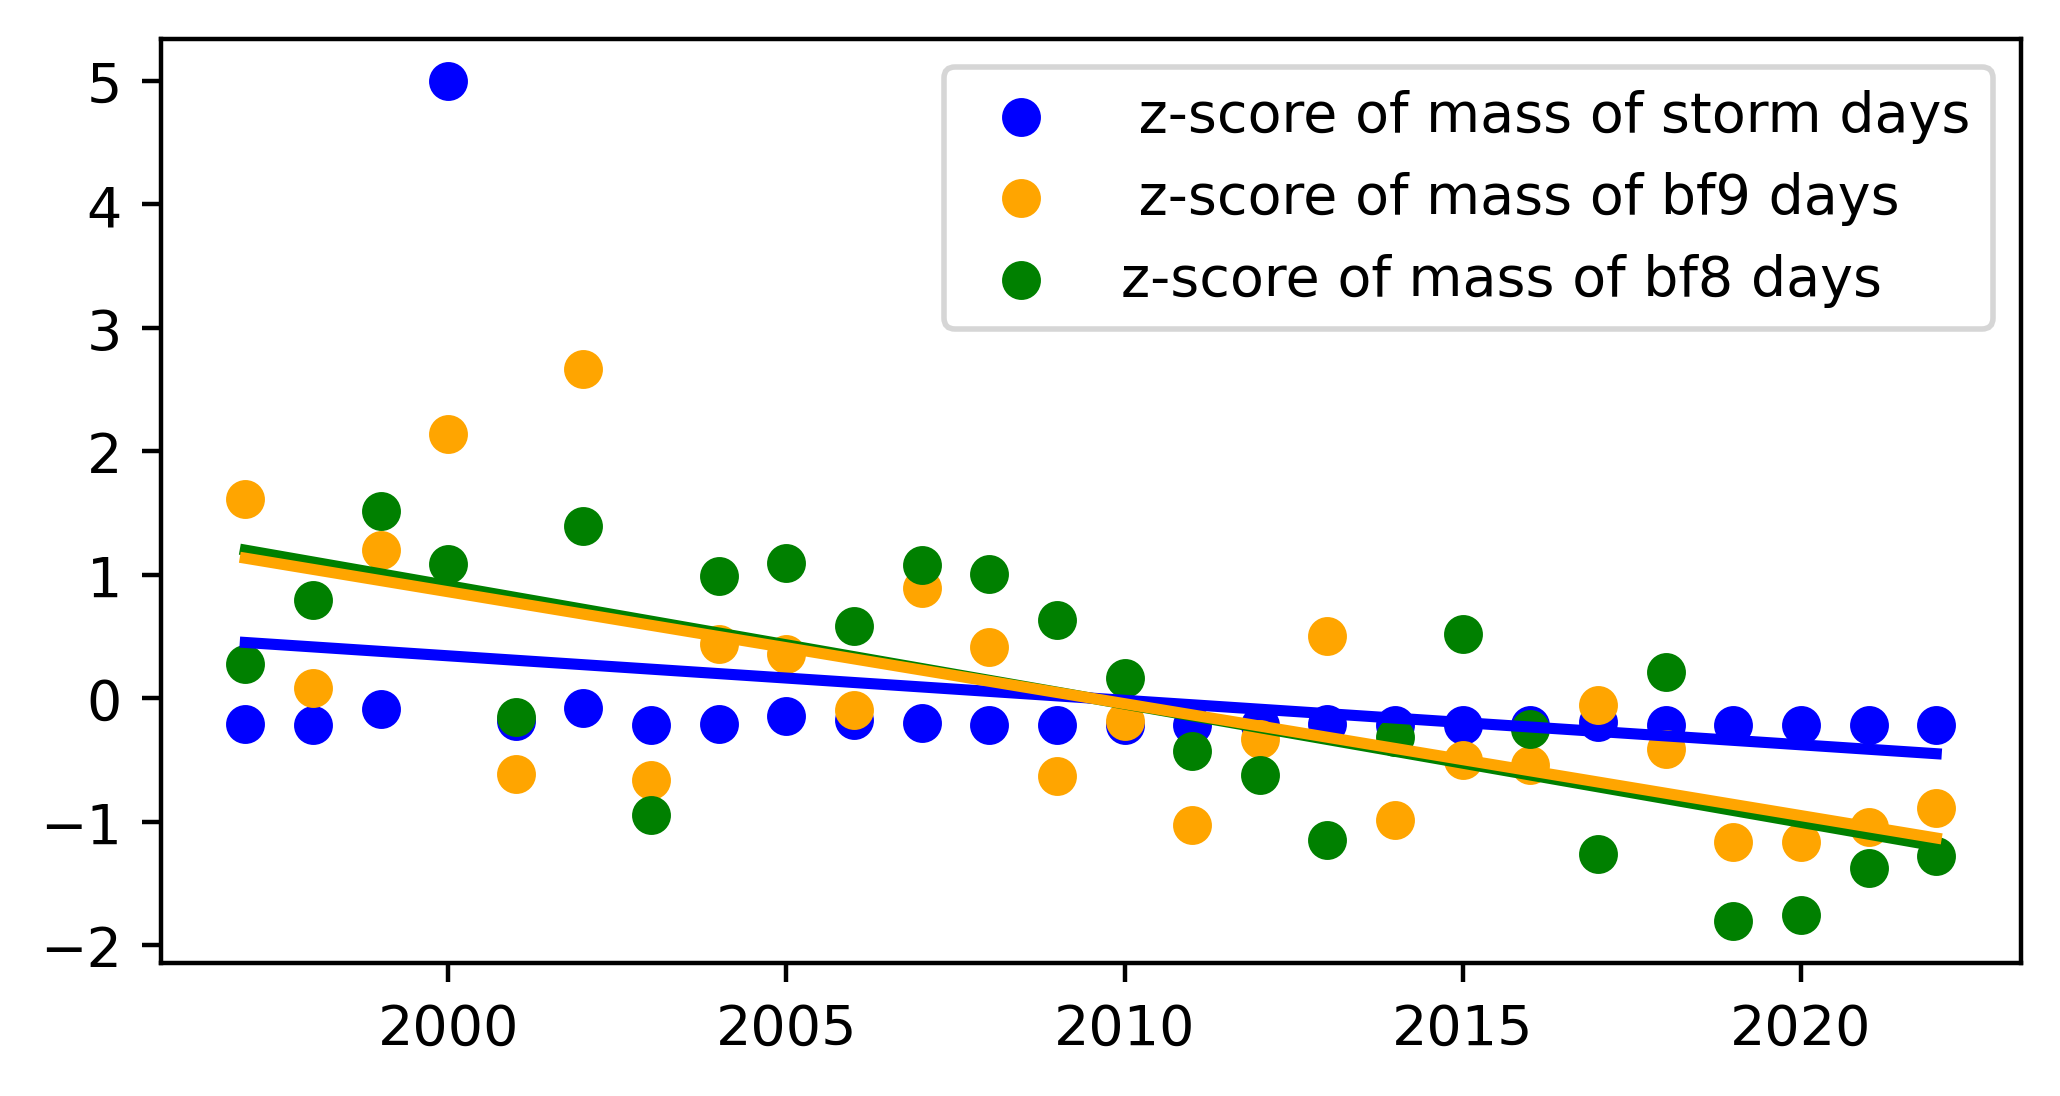

In [353]:
#plot the mass of the different wind categories, accounting for duration and speed:

mass_of_storms=dict()
mass_of_bf9=dict()
mass_of_bf8=dict()

for i in storm_df.index:
    if storm_df.loc[i, "MESS_DATUM"].year not in mass_of_storms:
       mass_of_storms[storm_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_storms[storm_df.loc[i, "MESS_DATUM"].year]+=storm_df.loc[i,"FF_10_wind"]


for i in bf9_df.index:
    if bf9_df.loc[i, "MESS_DATUM"].year not in mass_of_bf9:
        mass_of_bf9[bf9_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_bf9[bf9_df.loc[i, "MESS_DATUM"].year]+= bf9_df.loc[i,"FF_10_wind"]


for i in bf8_df.index:
    if bf8_df.loc[i, "MESS_DATUM"].year not in mass_of_bf8:
        mass_of_bf8[bf8_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_bf8[bf8_df.loc[i, "MESS_DATUM"].year]+=bf8_df.loc[i,"FF_10_wind"]

# turn dictionarys into arrays
mass_storm_arr= np.empty([1,0]) 
for i in range(0, len(xarr)):
   if xarr[i] in mass_of_storms:
        mass_storm_arr=np.append(mass_storm_arr, mass_of_storms[xarr[i]])
   else:
      mass_storm_arr=np.append(mass_storm_arr,0) 

mass_bf9_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf9_days:
        mass_bf9_arr=np.append(mass_bf9_arr, mass_of_bf9[xarr[i]])
   else:
      mass_bf9_arr=np.append(mass_bf9_arr,0) 

mass_bf8_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf8_days:
        mass_bf8_arr=np.append(mass_bf8_arr, mass_of_bf8[xarr[i]])
   else:
      mass_bf8_arr=np.append(mass_bf8_arr,0) 


# normalize
mass_bf9_arr=(mass_bf9_arr - np.mean(mass_bf9_arr))/np.std(mass_bf9_arr)
mass_bf8_arr=(mass_bf8_arr - np.mean(mass_bf8_arr))/np.std(mass_bf8_arr)
mass_storm_arr=(mass_storm_arr - np.mean(mass_storm_arr))/np.std(mass_storm_arr)


#polynomial regression and plotting
mass_bf9_pol=np.polyfit(xarr, mass_bf9_arr, 1)
mass_bf9_model = np.poly1d(mass_bf9_pol)

mass_bf8_pol=np.polyfit(xarr, mass_bf8_arr, 1)
mass_bf8_model = np.poly1d(mass_bf8_pol)

mass_storm_pol=np.polyfit(xarr, mass_storm_arr, 1)
mass_storm_model = np.poly1d(mass_storm_pol)


plt.scatter(xarr, mass_storm_arr, color='blue', label=' z-score of mass of storm days')
plt.scatter(xarr, mass_bf9_arr,  color='orange', label=' z-score of mass of bf9 days ')

plt.scatter(xarr, mass_bf8_arr,  color='green', label='z-score of mass of bf8 days ')
plt.plot(xarr, mass_bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, mass_storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, mass_bf9_model(xarr), color='orange', linewidth = 2)
plt.legend()
plt.show()





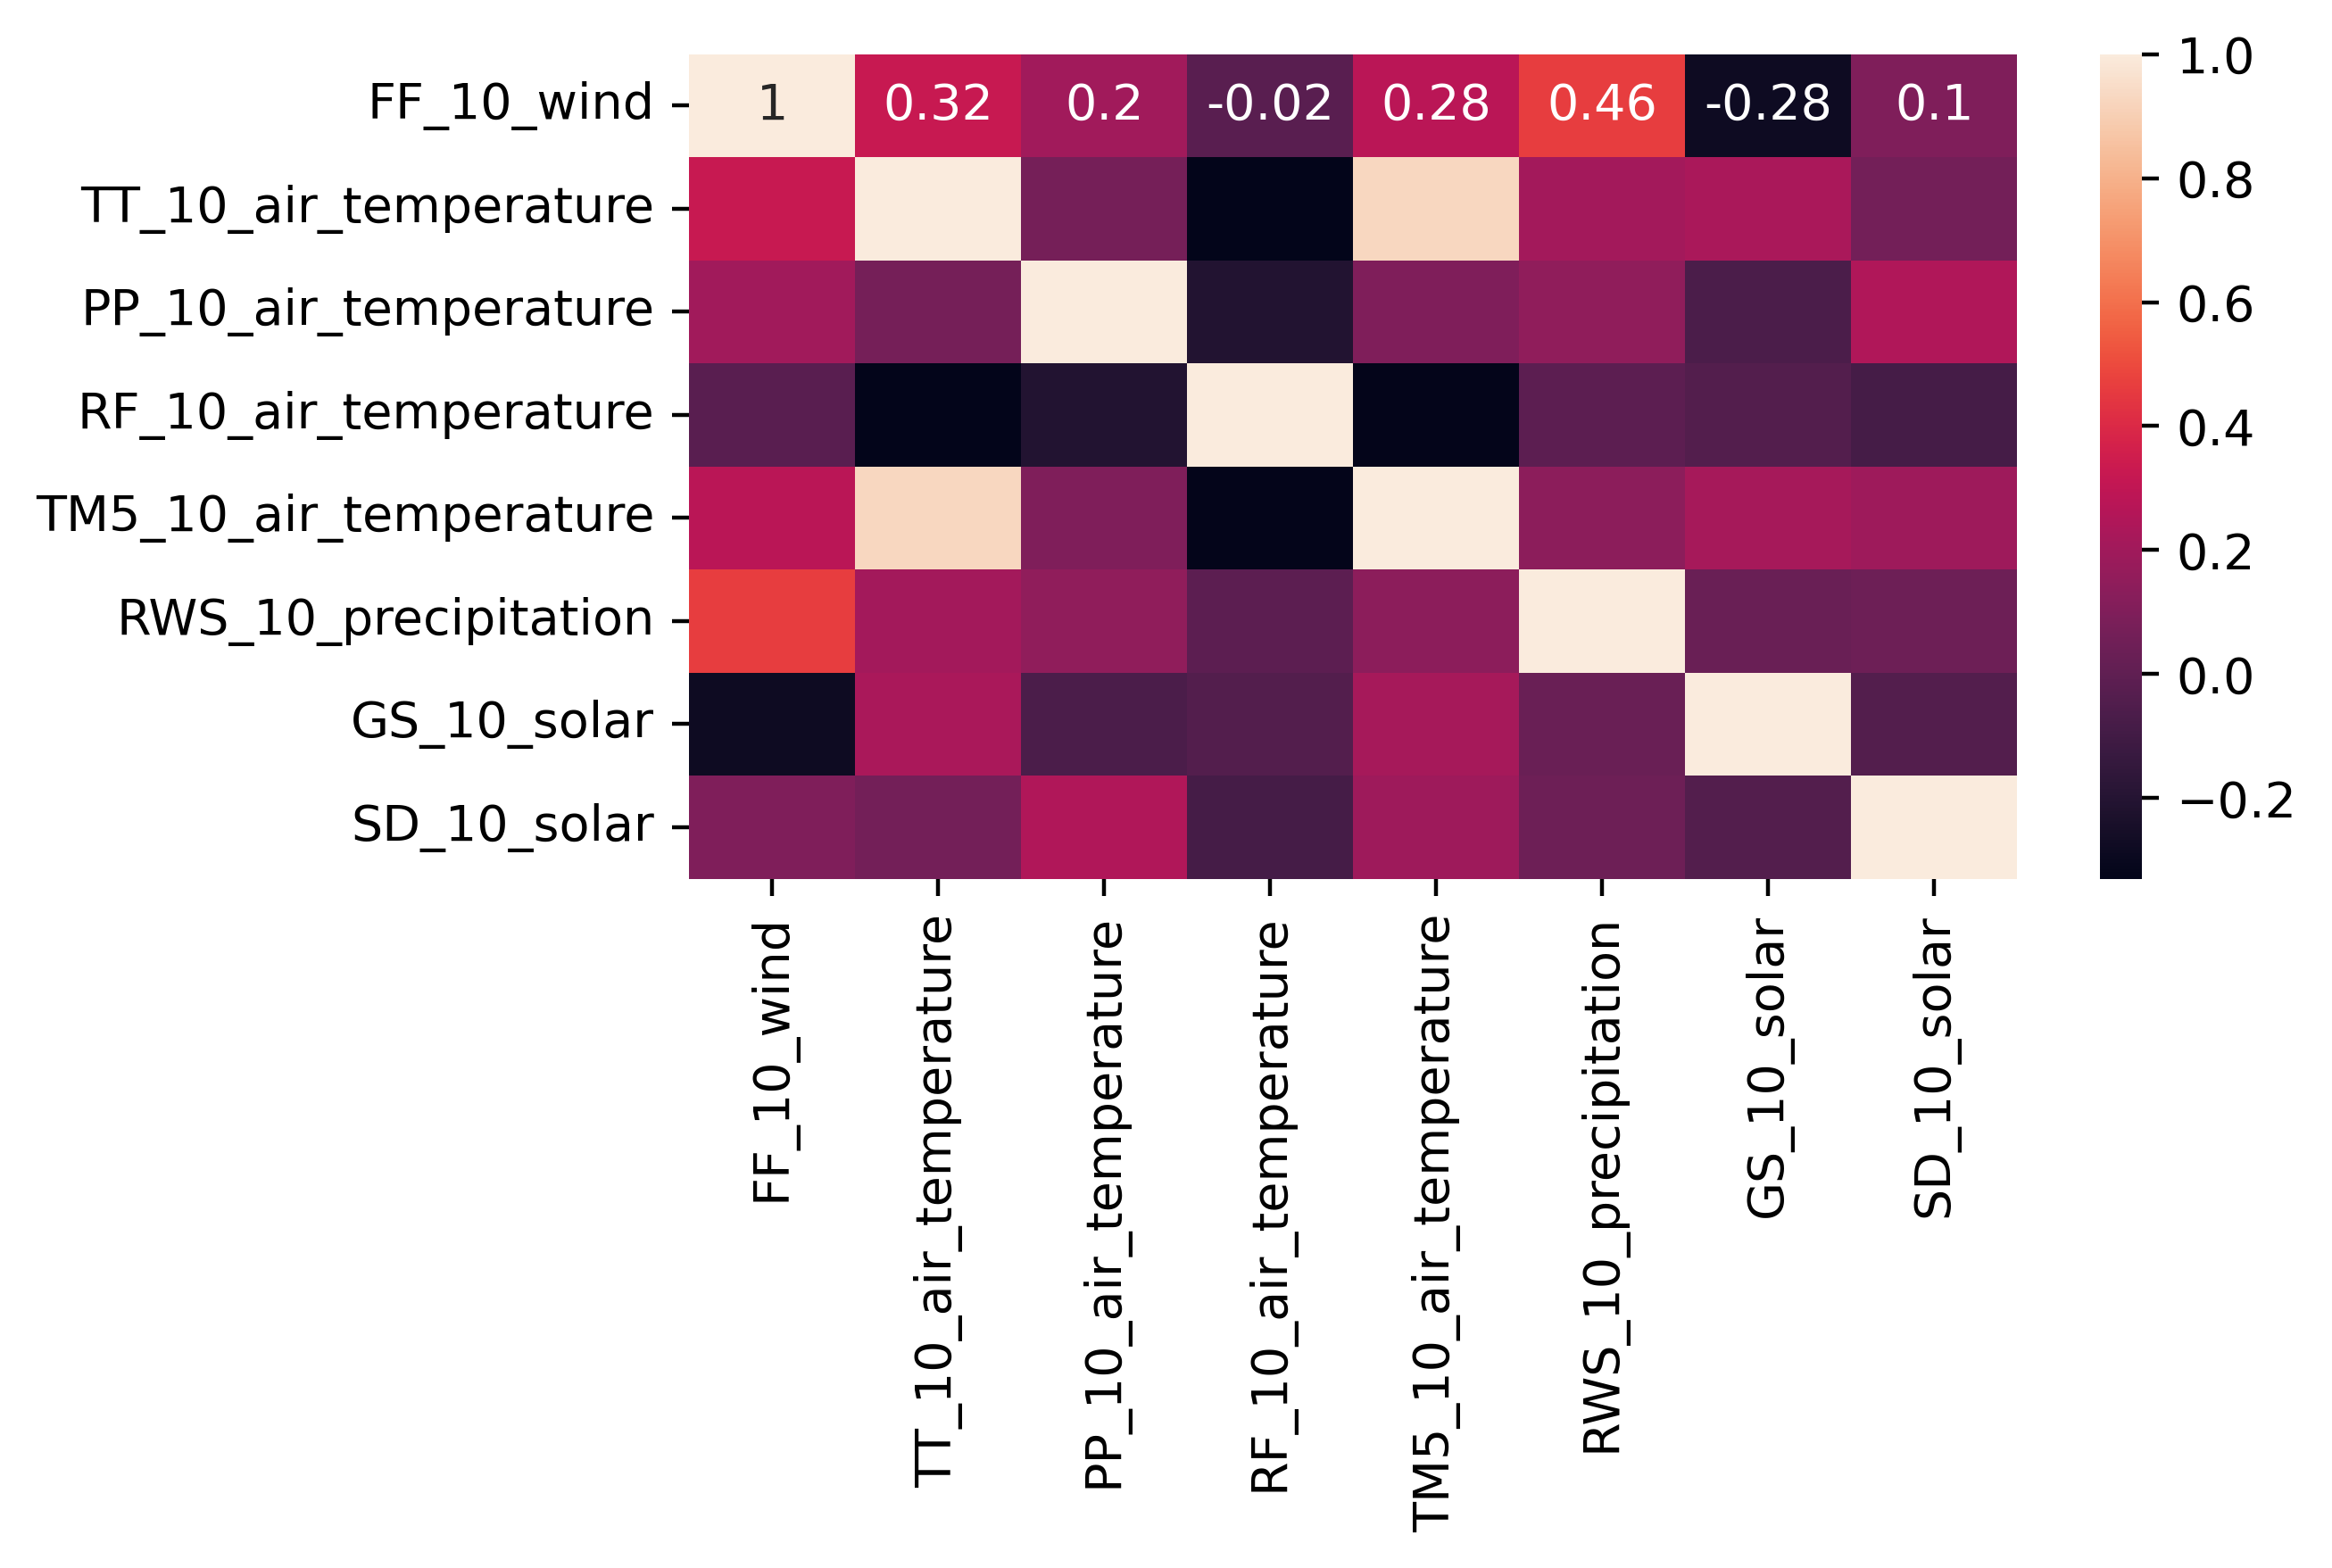

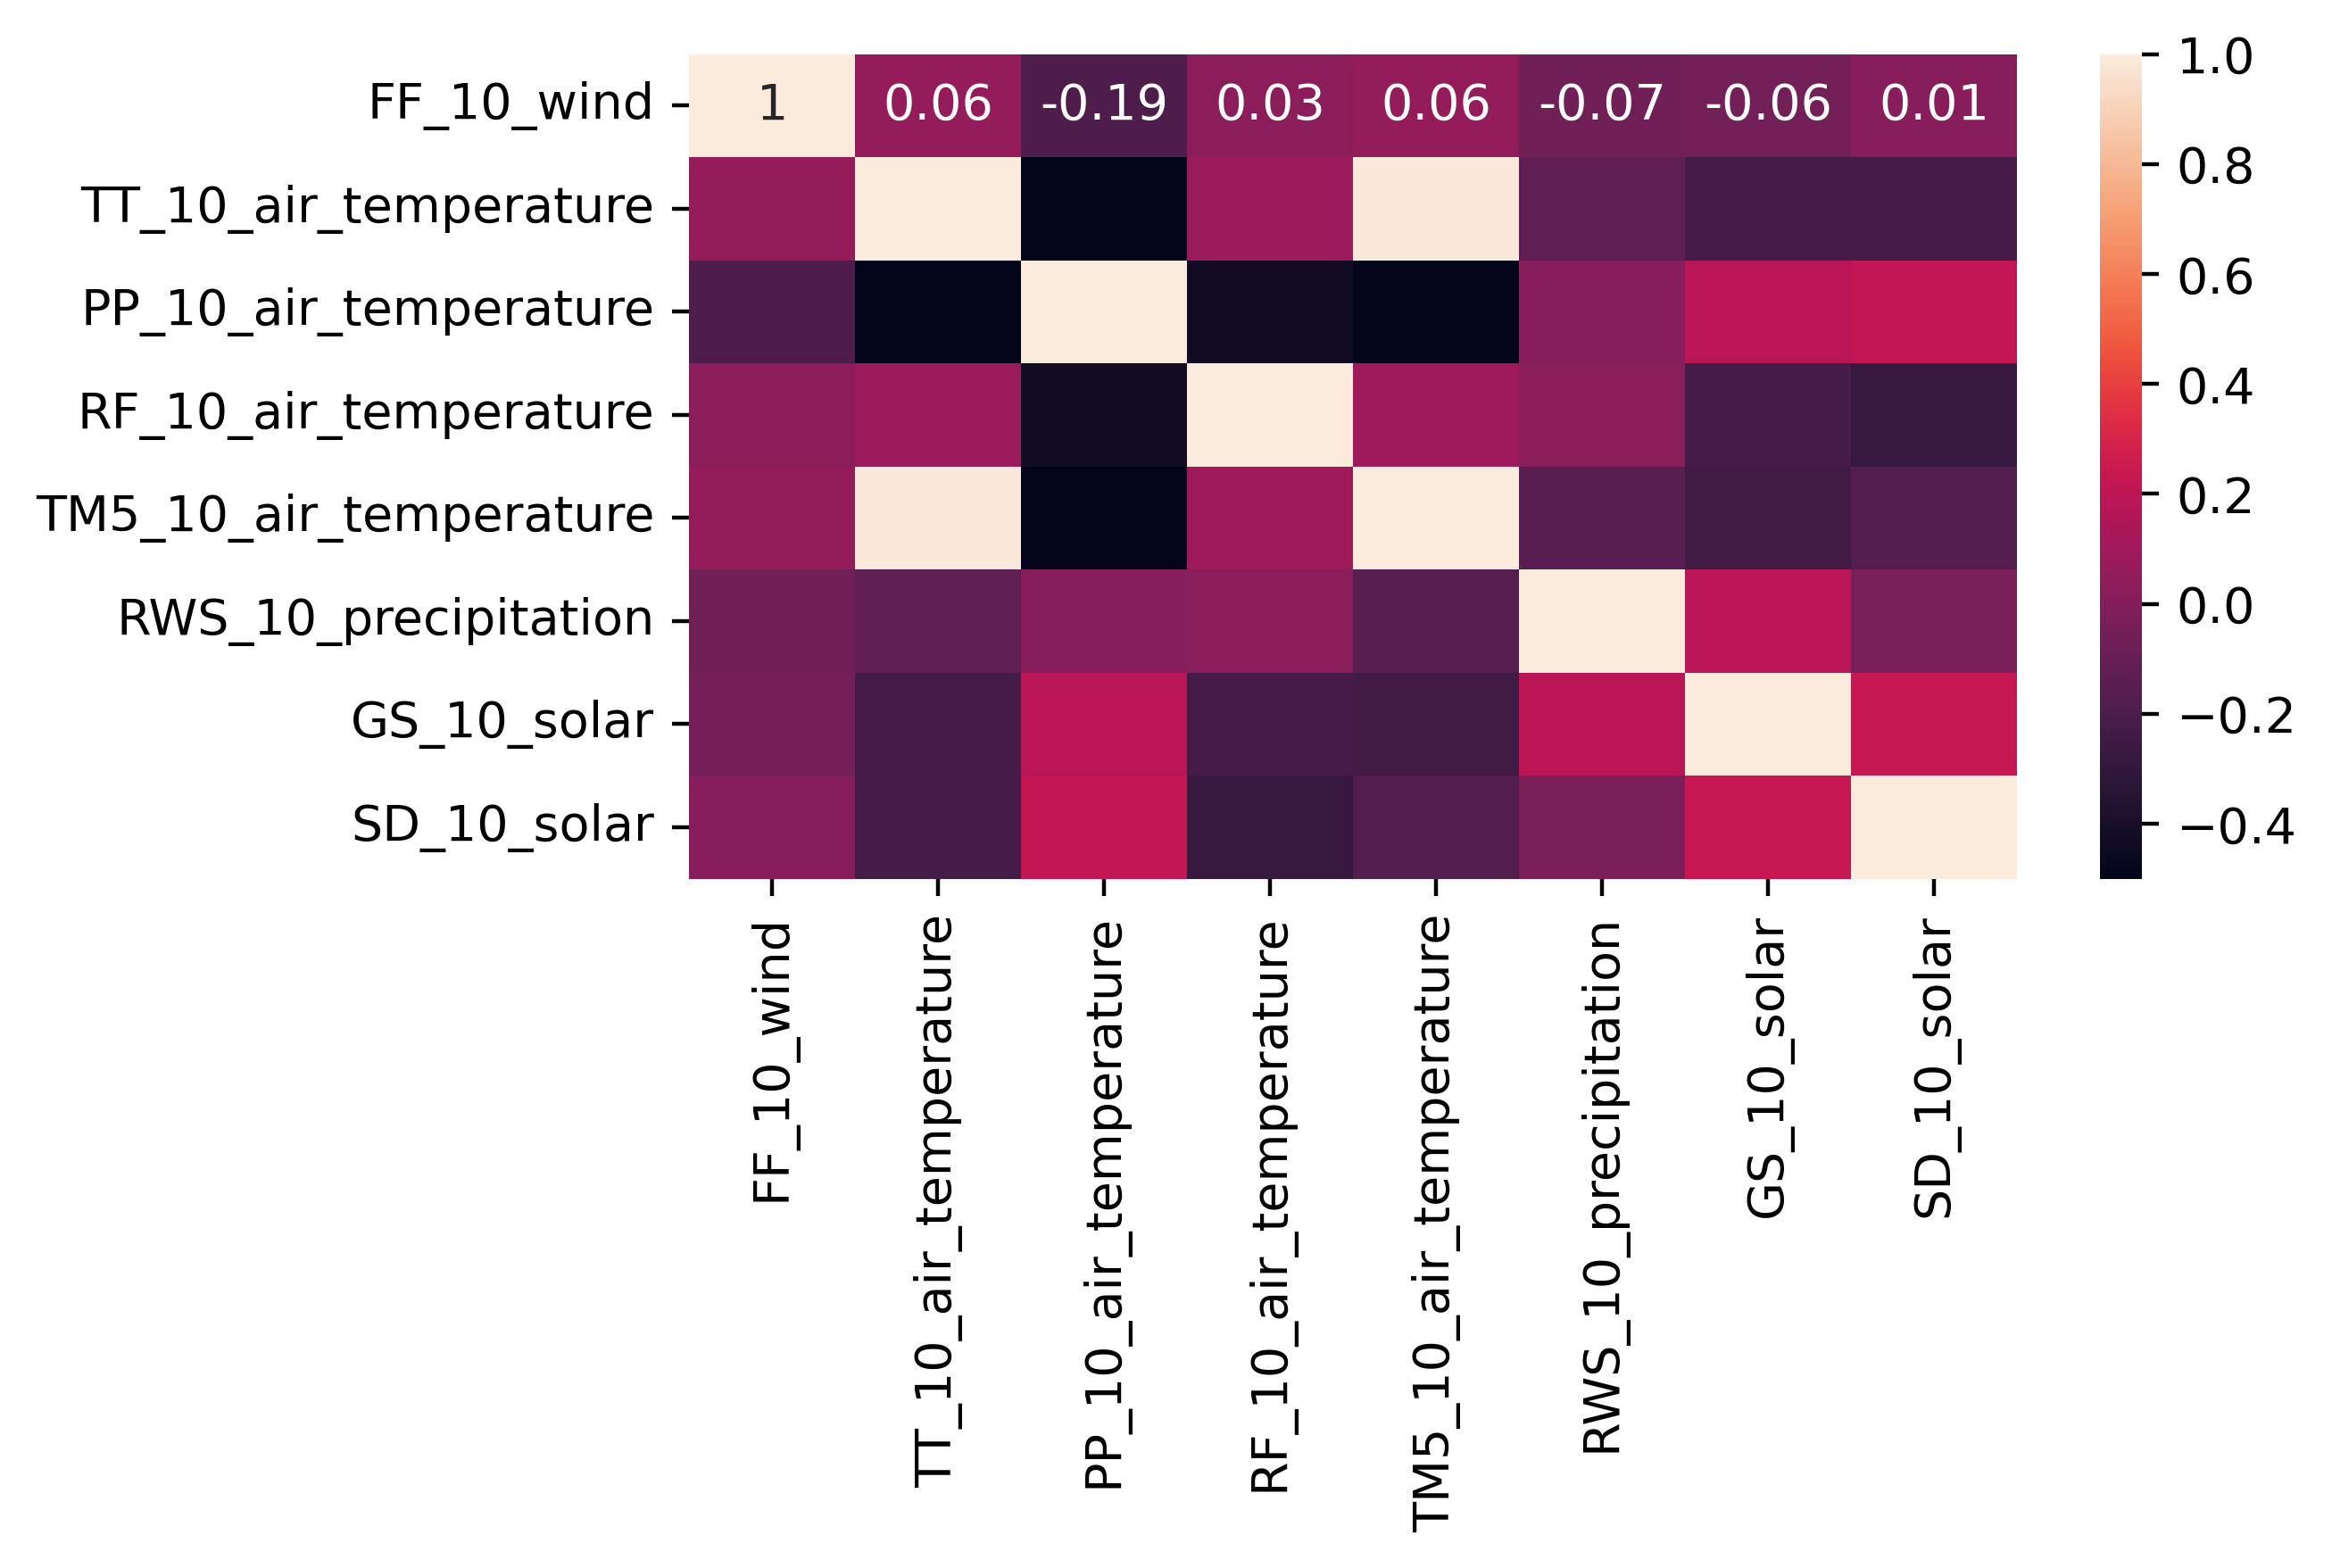

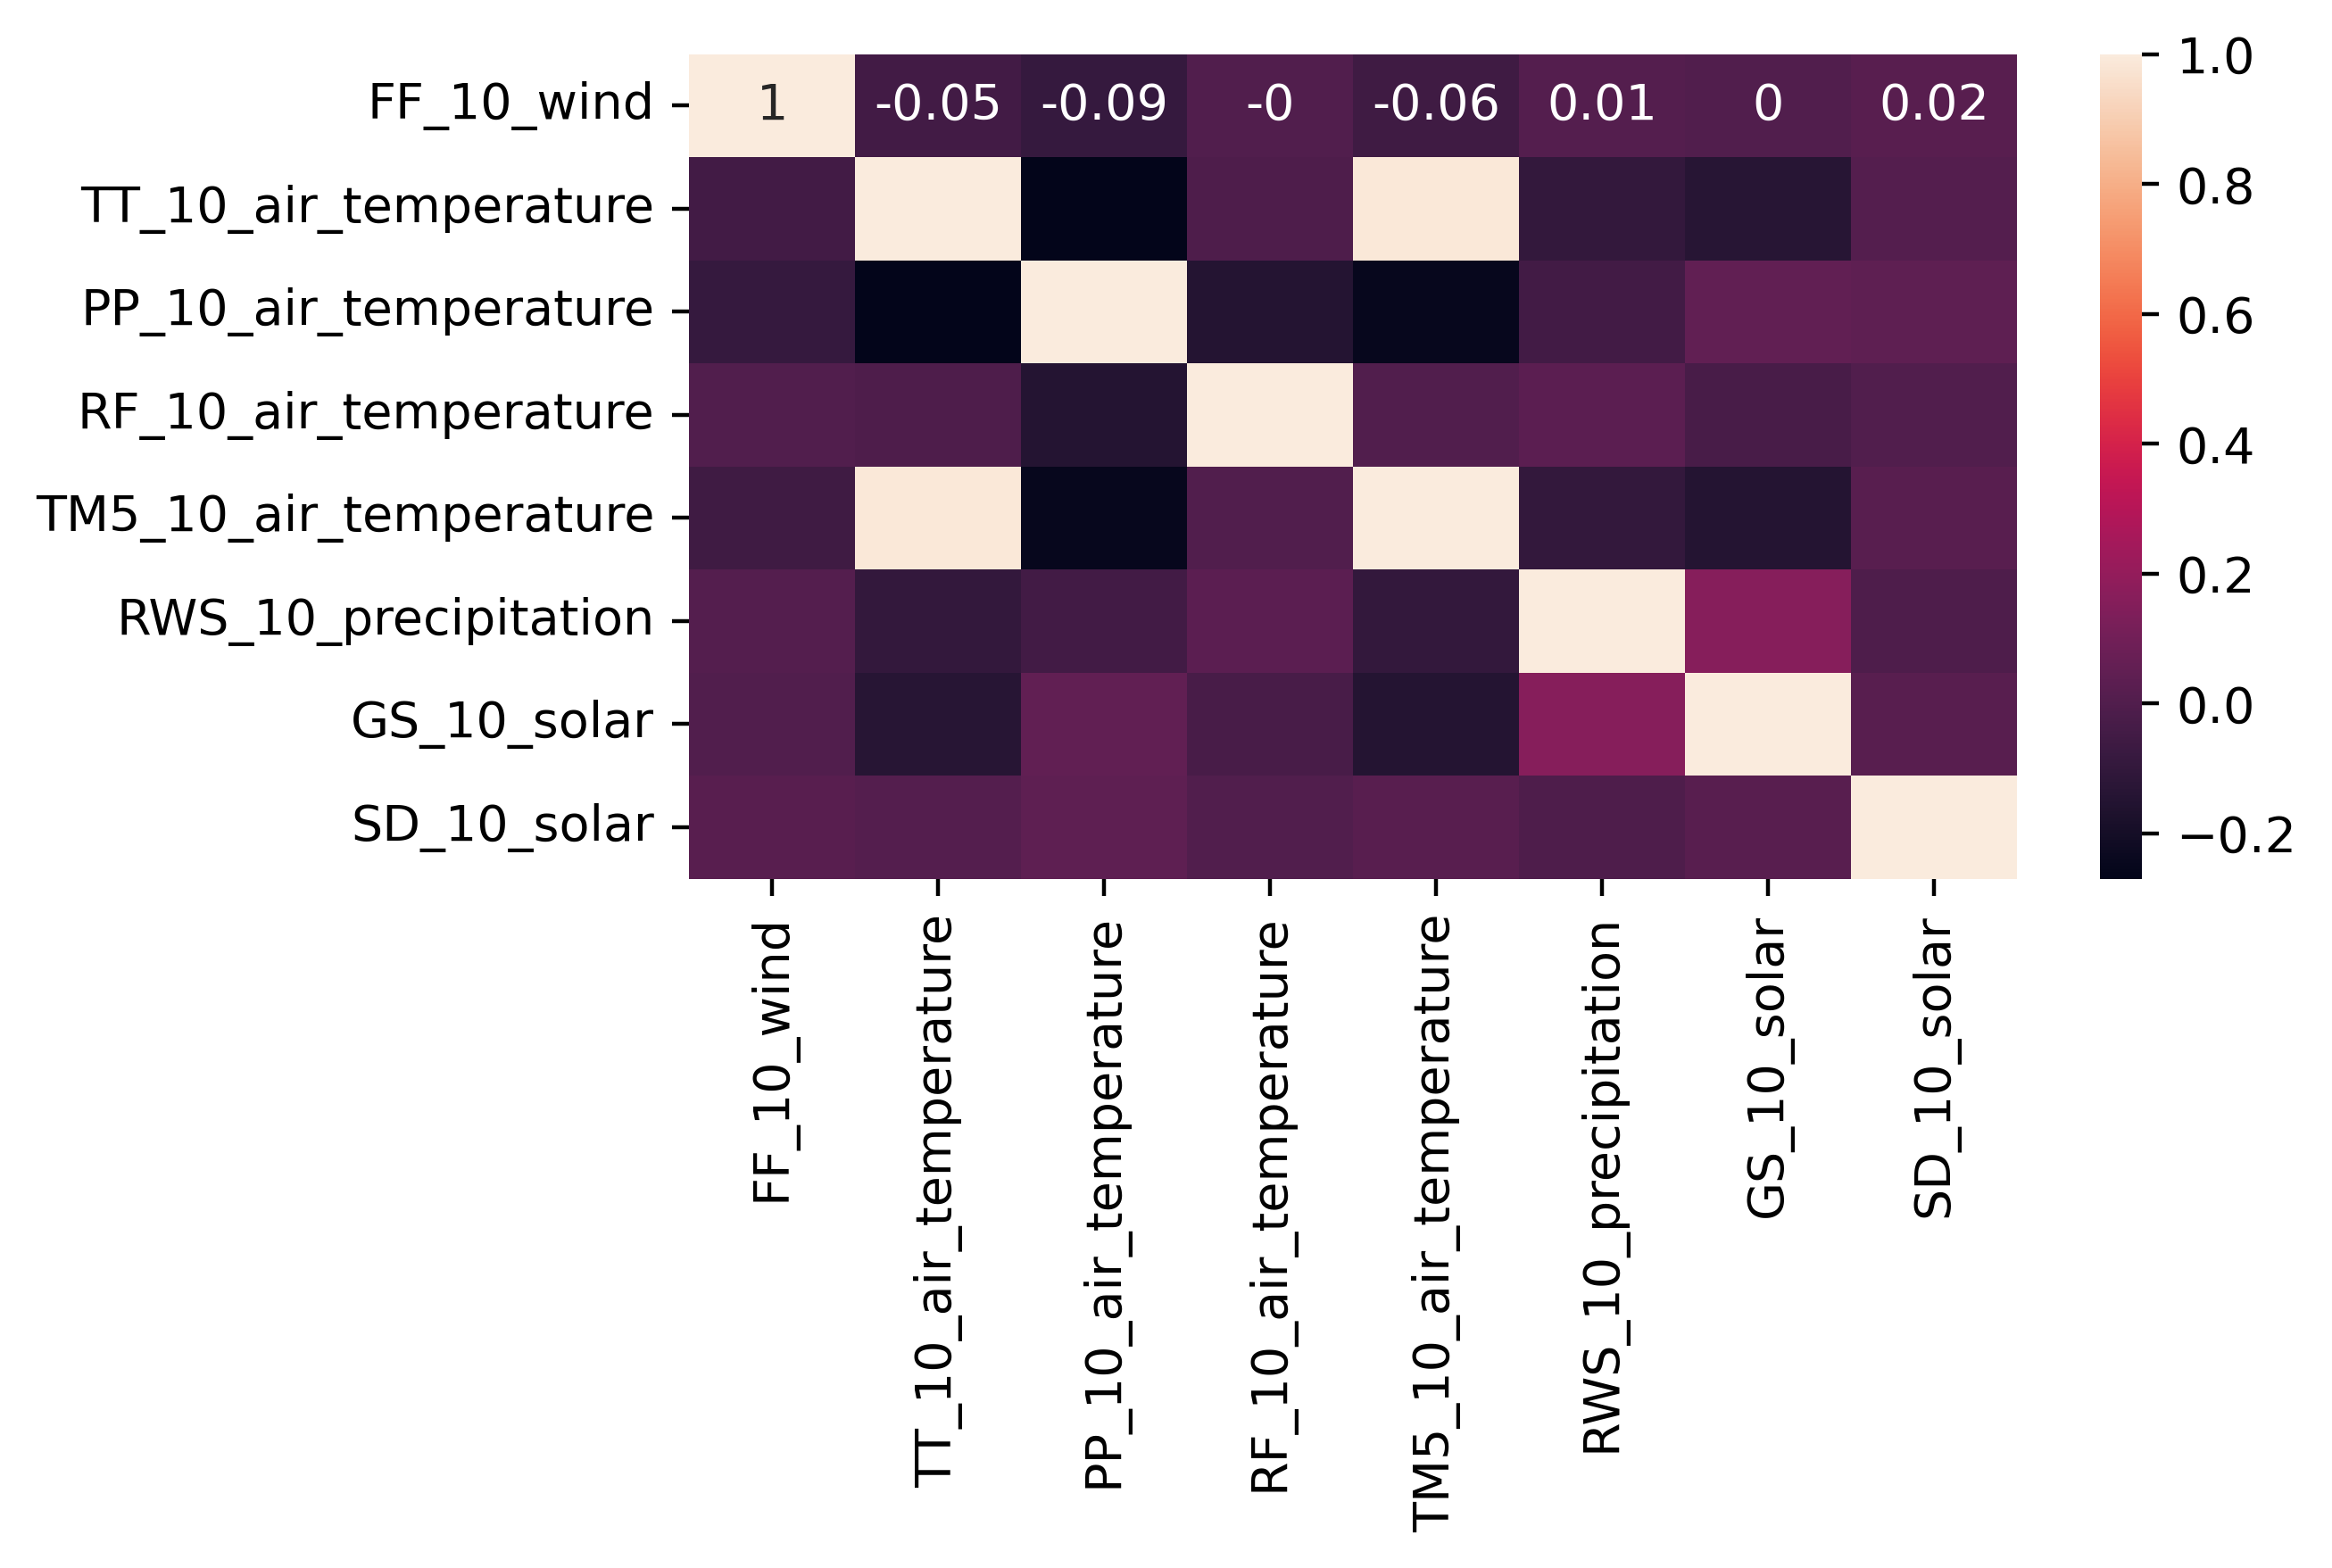

In [354]:
_ = plt.figure(figsize=(6, 3))
storm_corr_df = storm_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(storm_corr_df, annot=True)
plt.show()

_ = plt.figure(figsize=(6, 3))
bf9_corr_df = bf9_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(bf9_corr_df, annot=True)
plt.show()

_ = plt.figure(figsize=(6, 3))
bf8_corr_df = bf8_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(bf8_corr_df, annot=True)
plt.show()